# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

We will compute an approximate solution to the KdV equation, which models a wave propagation accpounting for nonlinear ansd dispersive effects : 

\begin{equation}
\begin{cases}
    u_t + au_x + b(u^2)_x + u_{xxx} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The constant coefficients $a$ and $b$ were introduced in order to analyze the influence of the phenomena acting in the model (pure advrection, nonlinearity and diffusion).

The kdV equation will be split in two equations, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + av_x + b(v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t + w_{xxx} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = av + bv^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(a+2bv)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{a+2b\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(v) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ be the Fourier coefficients of $w(x,t_n)$.  The Fourier transform of the equation

$w_t+w_{xxx}=0$

gives

$(\hat{w})_t(k,t) - ik^3\hat{w}(k,t)$ = 0

It is an ODE in $t$ which solution is
$\hat{w}(k,t) = e^{ik^3(t-t_n)}\hat{w}(k,t_n)$

The inverse Fourier transform using the coefficients $\hat{w}(k,t_{n+1})$ gives $w(x,t_{n+1})$

## Model functions

In [1]:
%%writefile kdv.py

import numpy as np
def Flux(u,a,b):
    return a*u + b*u*u
def Fluxder(u,a,b):
    return a + 2.0*b*u
def Fluxderinv(u,a,b):
    return (u-1.*a)/(2.*b)

Overwriting kdv.py


In [2]:
%%writefile kdv.py -a

def Riemann(u,x,t,a,b):
    uint = np.zeros_like(x)
    for  i in range(0,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um,a,b) - Flux(up,a,b))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um,a,b) :
                uint[i] = um
            elif incl > Fluxder(up,a,b) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl,a,b)
    #uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

Appending to kdv.py


In [3]:
%%writefile kdv.py -a

def Euler(u,dx,dt,periodic):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    else :
        umm[0] = u[0]
    
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

Appending to kdv.py


In [4]:
%%writefile kdv.py -a

def getRKCoef(u,x,t,dx,dt,a,b,periodic):
    uint = Riemann(u,x,t,a,b)
    uintmm = np.roll(uint,1)
    if periodic :
        uintmm[0] = uintmm[u.size-1]
    else :
        uintmm[0] = u[0]
        uint[u.size-1] = u[u.size-1]
        
    f = Flux(uint,a,b)
    fmm = Flux(uintmm,a,b)
    return dt*(fmm-f)/dx
        
def RK4(u,x,t,dx,dt,a,b,periodic):
        
    k1 = getRKCoef(u,x,t,dx,dt,a,b,periodic)
    k2 = getRKCoef(u+k1/2,x,t,dx,dt,a,b,periodic)
    k3 = getRKCoef(u+k2/2,x,t,dx,dt,a,b,periodic)
    k4 = getRKCoef(u+k3,x,t,dx,dt,a,b,periodic)
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

Appending to kdv.py


In [5]:
%%writefile kdv.py -a

def FourierSolver(u,t,dt,dx):
    nx = u.size-1
    #f0 = 1/dx
    #freq = np.linspace(0,nx,nx+1)*f0/(nx+1)
    #freq[(nx+1)/2+1:nx+1] = -np.flipud( freq[1:(nx+1)/2+1])
    uhat = np.fft.fft(u)
    uhat = uhat*np.exp(dt*1.j*np.power(np.fft.fftfreq(uhat.size,d=dt),3))
    #uhat = uhat*np.exp(dt*1.j*np.power(freq,3))
    u2 = np.fft.ifft(uhat)
#    if not (np.all(np.isreal(u2))):
#        print(u2)
#        sys.exit("Error in Fourier method")
    return np.real(u2)

Appending to kdv.py


In [6]:
%%writefile kdv.py -a

import numpy.polynomial.chebyshev as cheb

def computeChebMatrix(x,u):
    N = x.size-1
    a = x[0]
    b = x[N]
    lamb = 2./(b-a)
    roots = (2.*x-(b+a))/(b-a)

    T = np.diag(np.ones(N+1))
    Troots = cheb.chebval(roots,T)

    Txroots = np.zeros(Troots.shape)
    Txxroots = np.zeros(Troots.shape)
    
    A = np.zeros(Troots.shape)
    
    cc = np.ones(N+1)
    cc[0] = .5
    cc[N] = .5
    
    #for i in range(N+1):
    #    for j in range(N+1):
    #        for n in range(j):
    #            if (n+j)%2 == 1:
    #                Txroots[j,i] = Txroots[j,i] + cc[n]*Troots[n,i]
    #        Txroots[j,i] = Txroots[j,i]*2.*j*lamb
    
    ccM = np.tile(cc.transpose(),(N+1,1)).transpose()
    cT = ccM*Troots
    
    
    Z1 = np.array([0,1])
    Z1 = np.tile(Z1,N/2)
    Z2 = np.roll(Z1,-1)
    Z2[0] = 0
    Z3 = np.vstack((Z1,Z2)).transpose()
    Z3 = np.tile(Z3,(1,N/2))

    col = np.zeros((N,1))
    col[:,0] = Z3[:,N-2]
    Z3 = np.concatenate((Z3,col),axis=1)

    lig = np.zeros((1,N+1))
    lig[0,:] = Z3[N-2,:]
    Z3 = np.concatenate((Z3,lig),axis=0)

    Z = np.tril(Z3)

    ZcT = np.dot(Z,cT)
    
    D = np.linspace(0,N,N+1)
    D = np.tile(D,(N+1,1)).transpose()
    
    Txroots = 2.*lamb*D*ZcT
    
    #print(np.linalg.norm(Txroots-Txroots2))
    
    
    cTxroots = ccM*Txroots
    A = ccM.transpose()*2./N*np.dot(cTxroots.transpose(),Troots)
    
      
#    for i in range(N+1):
#        for n in range(N+1):
#            for j in range(N+1):
#                if j > 0 and j < N:
#                    A[i,n] = A[i,n] + Txroots[j,i]*Troots[j,n]
#                else:
#                    A[i,n] = A[i,n] + .5*Txroots[j,i]*Troots[j,n]
#            A[i,n] = A[i,n]*(2.*cc[n])/N
    
    
    B =  np.dot(A,A)
    Bb = np.dot(A[:,1:N],A[1:N,:])
    C = np.dot(A,Bb)
    
    return A,B,C


def ChebyshevSolver(x,u,dt,dx,A,B,C,cl) :
    
    N = x.size-1
    di = C[:,0]*cl[0] + C[:,N]*cl[1] + B[:,0]*cl[2] + B[:,N]*cl[3]
    
    F = - np.dot(C[:,1:N],u[1:N]) - di
    u2 = u + dt*F
    #F1 = - np.dot(C[:,1:N],u[1:N]) - di
    #F2 = - np.dot(C[:,1:N],u[1:N]+dt/2.*F1[1:N]) - di
    #F3 = - np.dot(C[:,1:N],u[1:N]+dt/2.*F2[1:N]) - di
    #F4 = - np.dot(C[:,1:N],u[1:N]+dt*F3[1:N]) - di
    
    #u2 = u + dt/6.*(F1 + 2.*F2 + 2.*F3 + F4)
    

    u2[0] = u2[1] - dx*cl[2]

    u2[N] = u2[N-1] + dx*cl[3]
    
    return u2

def ChebyshevSolver3(x,u,dt,dx,A,B,C,cl) :
    
    N = x.size-1
    
    M = dt*C + np.diag(np.ones(N+1))
    M[0,:] = A[0,:]
    M[N,:] = A[N,:]
    #M[0,:] = np.zeros(N+1)
    #M[0,1] = 1.
    #M[0,1] = -1.
    #M[N,:] = np.zeros(N+1)
    #M[N,N] = 1.
    #M[N,N-1] = -1.
    
    rhs = np.copy(u)
    
    rhs[0] = cl[2]
    rhs[N] = cl[3]
    
    u2 = np.linalg.solve(M,rhs)
    
    return u2

Appending to kdv.py


In [7]:
%%writefile kdv.py -a

import numpy.polynomial.chebyshev as cheb
import matplotlib.pyplot as plt


def ChebyshevSolver2(x,u,dt,dx) :
    
    nx = u.size-1
    a = x[0]
    b = x[nx]
    #roots = (2.*x-(b+a))/(b-a)
    #uroots = np.interp(roots,x,u)
    roots = x
    uroots = u
    plt.plot(roots,uroots)
    ucheb = cheb.chebfit(roots,uroots,nx)
    uxxxcheb = cheb.chebder(ucheb,m=3)
    
    uxxxcheb = np.append(uxxxcheb,[0,0,0])
    
    uxxx = cheb.chebval(x,uxxxcheb)
    
    u2 = u + dt*uxxx
    
    return u2

Appending to kdv.py


In [8]:
%%writefile kdv.py -a

def runRk4FVFourier(x,u,t0,tmax,a,b,periodic=1):
    t = t0
    tall = np.ones(1)*t0
    u0 = u
    uall = u
    u0min = np.amin(u)
    u0max = np.amax(u)
    dx = np.diff(x)[0]
    iter = 0
    eps = 1e-6

    ##### Parameters
    printstep = 5
    #a = 1
    #b = 1


    if not periodic:
        A,B,C = computeChebMatrix(x,u)
        
    while t<tmax:
        iter = iter + 1
        umax = np.amax(np.absolute(u))
        dt = dx/(1.*a+2*b*umax) - eps     # CFL CONDITION (???)
#         print dt
#         dt = 0.0020
        #dt = dx
        t = t+dt
        u = RK4(u,x,t,dx,dt,a,b,periodic)
        
        if periodic :
            u = FourierSolver(u,t,dt,dx)
        else :
            cl = [0,0,0,0]
            u = ChebyshevSolver3(x,u,dt,dx,A,B,C,cl)
            #u = ChebyshevSolver2(x,u,dt,dx)



        #if not periodic:
            #u[0] = uleft ## Boundary conditions ?
            #u[nx] = uright
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        if iter%100 == 0:
            print(iter,t)
    return uall,tall


Appending to kdv.py


In [9]:
%%writefile kdv.py -a

def discretizeSpace(xmin,xmax,dx) :
    nx = int((xmax-xmin)/dx)
    x = np.linspace(xmin, xmax,nx+1)    
    return x

Appending to kdv.py


In [10]:
#######

### def setProblem(xmin,xmax,dx,f,args)
### x = kdv.discretizeSpace(xmin,xmax,dx)
### u = f(args)
### return x,f

# Scale analysis

In order to correctly simulate the physical phenomena involved in the KdV equation, the initial solution must satisfy the assumptions made in the derivation of the model. Following this purpose, we perform an scale analysis following the arguments presented in the paper of BBM [ADD REFERENCE] which at the same time will be linked to the physical case of water surface waves of small amplitude. This analysis will allow us to derive a criteria for selecting the initial conditions of some example simulations. 


We will seek to write the KdV equation in the following dimensionless and scaled form, as described in BBM article ([BBM])
$$U_T + U_X + \frac{\epsilon}{2} (U^2)_X + \epsilon\alpha^2U_{XXX} = 0$$

and link it to the parameters involved in the model for surface water waves [Senthilkumar] in dimensional form

\begin{equation}
    u^*_{t^*} + c_0u^*_{x^*} + \frac{3}{4}\frac{c_0}{h_0}({u^*}^2)_{x^*} + \frac{1}{6}c_0h_0^2u^*_{x^*x^*x^*} = 0 
\end{equation}

where the $\cdot^*$ denotes the physical variables, $h_0$ the undisturbed water depth for flat bottom and $c_0 = \sqrt{gh_0}$  the long wave speed.

## Characterization of non linearity 

According to the paper of BBM (1971), nonlinearity is characterized by a parameter $\epsilon$ such that if characteristics are written in the form

$$ \frac{1}{c_0} \frac{dx}{dt} = 1+ bu$$

then one can choose an $\epsilon \ll 1$ such that $bu=\epsilon U$, with $U$ of order one. For the particular case of water waves this can be represented as

$$ \frac{1}{c_0} \frac{dx}{dt} = 1 + \frac{3}{2h_0}u$$

and thus $b = \frac{3}{2h_0}$. This parameter will be used in the next arguments.

## Characterization of dispersion

The characterization of the dispersion comes from the derivation of the KdV equation. According to BBM if the propagation of the wave follows a law of the form

$$ u^*_{t^*} + uu_x+(\mathcal{L} u^*)_{x^*} = 0$$


with $\mathcal{L}$ such that $$ \hat{\mathcal{L}u^*} = \frac{c(k)}{c_0} \hat{u^*}(k,t)$$ with $\hat \cdot$ the Fourier transform and $c(k)$ the phase celerity, which is equivalent to 

$$ \mathcal{L} u = \mathcal{F}^{-1}\left(\frac{c(k)}{c_0}\right) * u$$ 
where $\mathcal{F}^{-1}$ is the inverse Fourier transform operator, then new scaling based on the fact that for $\kappa$ suffiicently small, the wave speed $c(\kappa) = c_0 + c_0 \sum_{n=1}^{\infty}A_n\epsilon^n\kappa^{2n}$ can be approximated by $c(\kappa) = c_0(1-\kappa^2)$, which motivates replacing $x=\sqrt{\epsilon} X$, $t =c_0 \sqrt{\epsilon} T$, and $u = \frac{\epsilon}{ b} U$ to obtain the equivalent equation 

$$ U_T + \epsilon U U_x+(\mathcal{L}_{\epsilon} U)_{X} = 0$$
with $\mathcal{L}_\epsilon$ such that 

$$ \hat{\mathcal{L}_\epsilon U} = \frac{c(\epsilon^{1/2} K)}{c_0} \hat{U}(K,T)$$ 

with $K=\sqrt{\epsilon} k$, which after replacing the full series expansion of $c(k)$ leads to

\begin{align}
    \mathcal{L}_\epsilon U &=U +\sum_{n=1}^\infty (-1)^n A_n \epsilon^n \partial_X^{2n} U    
\end{align}

and if terms for $n\geq2$ are neglectable, which is the case for $\epsilon \ll 1 $ and if one supposes that all derivatives of $U$ are of the same order of magnitude, then one obtains that

\begin{align*}
    \mathcal{L}_\epsilon U &= U + A_n \epsilon \frac{\partial^2 U}{\partial x^2} \\
    &= U - \alpha^2 \epsilon \frac{\partial^2 U}{\partial x^2} \\
\end{align*}
with $\alpha^2 = - A_n$. Replacing in the scaled equation results in

$$U_T + U_X + \frac{\epsilon}{2} (U^2)_X + \epsilon\alpha^2U_{XXX} = 0$$

Applying the same scaling $x=\sqrt{\epsilon} X$, $t =c_0 \sqrt{\epsilon} T$, and $u = \frac{\epsilon}{ b} U$ to the physical equation leads to $$U_T + U_X + \frac{3\epsilon}{4b} (U^2)_X + \frac{h_0^2\epsilon}{6}U_{XXX} = 0$$
from where one concludes that $ \alpha^2 = \frac{h_0^2}{6} $

## Choice of the wavelength

A sufficient condition for the terms of order greater than 1 in the power series expansion of $\mathcal{L}_\epsilon$ to be neglectable is that those terms are also neglectable for $c(k)$, given that that all the derivatives of $U$ have an order of magnitude 1

A key point in the derivation of the KdV equation is to assure that the terms for the higher derivatives (for $n > 1$) are small enough to be neglected. Firstly, [BBM] assumes that all this derivatives have have an order of magnitude 1. Secondly, a sufficient condition for this is that those terms are also neglectable in the series expansion of $c(k)$. Thirdly, also accordingly to [BBM], the following form is applicable to surface waves : 

$c(\kappa) = c_0 \left(\frac{tanh(\kappa h_0)}{\kappa h_0}\right) = c_0 \left(1 - \frac{1}{6}(\kappa h_0)^2 + \frac{19}{360}(\kappa h_0)^2 + ... \right) $

from where we can see that we must choose $\kappa h_0 \ll 1$

Denoting $\lambda$ as the wavelength, and choosing a constant $B$ such that $\kappa h_0  =  B \ll 1$, it follows that $h_0 = \frac{B\lambda}{2\pi}$, and, from the relation $\alpha^2 = \frac{h_0^2}{6}$, we get $\alpha^2 = \frac{B^2\lambda^2}{6(2\pi)^2}$.

### Choice of the wave amplitude

From $bu^* = \epsilon U$, with $U$ of unit order magnitude, and since $b = \frac{3}{2h_0}$, the physical variable is written as $u^* = \frac{2}{3}h_0\epsilon U, \ (\epsilon > 0)$, thus if $\epsilon$ represents the amplitud of the wave, $\frac{2}{3}\epsilon h_0$ is the wave amplitude (as done in the scale study). Accordingly to [BBM], the nonlinearity in the KdV equation is valid for $\epsilon \ll 1$. Therefore, $\epsilon$ will be chosen taking in account this condition.

### The criteria

In resume, the proposed criteria to construct the initial data is : 

1. Adopt a water depth $h_0$ (e.g. from the data)
2. Choose a wave amplitude  $A = \frac{2}{3}h_0\epsilon$, then the restriction $\epsilon \ll 1$ translates to $\frac{A}{h_0} = \frac{2}{3}\epsilon \ll 1$.
3. Choose a wavelength $\lambda$ such that $\kappa h_0 = \frac{2\pi}{\lambda}h_0 = B \ll 1$, which translates to $\frac{h_0}{\lambda} = \frac{B}{2\pi} \ll 1$
4. The effect of dispersion over non linearity can be measured by taking the quotient of their coefficients $\frac{\epsilon \alpha^2}{\epsilon} = \alpha^2$.

From another point of view, one can define a wave of amplitude $A$ and wavelength $\lambda$ and compute the range of depths in which this initial condition is valid, for a given precision $(B,\epsilon)$ : $\left[\frac{3}{2}\frac{A}{\epsilon},\frac{B\lambda}{2\pi} \right]$. This is consistent with the fact that the KdV model is valid for waves with small amplitude and large wavelenght [BBM].

### Simulations using the criteria

The criteria described above was used to generate the initial solutions of the following simulations. These tests were based in those presented in http://www.bu.edu/pasi-tsunami/files/2013/01/day-1.pdf and http://www.bu.edu/pasi-tsunami/files/2013/01/daytwo12.pdf ; even if they have not used the same model, we can qualitatively compare the solution depending on the characteristics of the initial wave.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import kdv

%matplotlib inline

#### Test 1 : same eps and B

In [ ]:
### Wave 1
eps = 0.001
B = 0.1
A = .1
wvl = 25000.0
h0min = 1.5*A/eps
h0max = B*wvl/(2.*np.pi)
h0 = 0.5*(h0min+h0max)
alpha2 = h0*h0/6.

L = 5*wvl
xmin = -L
xmax = L
N = 1000
dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)

print(r'*** Wave 1 ***')
print(r'Amplitude : %f' %A)
print(r'Wavelength : %f' %wvl)
print(r'1/(2.*Wavelength^2) : %f' %(1./(2.*wvl*wvl)))
print(r'h0min : %f' %h0min)
print(r'h0max : %f' %h0max)
print(r'eps : %f' %eps)
print(r'B : %f' %B)
print(r'alpha^2 : %f' %alpha2)
print(r'Space steps : %d' %x.size)

In [ ]:
u = np.zeros_like(x)
#u = np.where( (x>=-.5*wvl)*(x<=.5*wvl), A, u)   #### Square wave not valid!!!!
u = A*np.exp(-(x-0.)**2/(2.*wvl*wvl))
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=1000,a=1,b=1, periodic = 0)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, xmax), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    title.set_text('t=%.3f'%(tall[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=300)

In [ ]:
### Wave 2
eps = 0.001
B = 0.1
A = .00010
wvl = 100
h0min = 1.5*A/eps
h0max = B*wvl/(2.*np.pi)
h0 = 0.5*(h0min+h0max)
alpha2 = h0*h0/6.

L = 10.*wvl
xmin = -L
xmax = L
N = 1000
dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)

print(r'*** Wave 2 ***')
print(r'Amplitude : %f' %A)
print(r'Wavelength : %f' %wvl)
print(r'1/(2.*Wavelength^2) : %f' %(1./(2.*wvl*wvl)))
print(r'h0min : %f' %h0min)
print(r'h0max : %f' %h0max)
print(r'eps : %f' %eps)
print(r'B : %f' %B)
print(r'alpha^2 : %f' %alpha2)
print(r'Space steps : %d' %x.size)

In [ ]:
u = np.zeros_like(x)
#u = np.where( (x>=-.5*wvl)*(x<=.5*wvl), A, u)   #### Square wave not valid!!!!
u = A*np.exp(-(x-0.)**2/(2.*wvl*wvl))
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=1000,a=1,b=1, periodic=0)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, xmax), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    title.set_text('t=%.3f'%(tall[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=300)

In [12]:
### Wave 3
eps = 0.001
B = 0.1
A = .00010
wvl = 10
h0min = 1.5*A/eps
h0max = B*wvl/(2.*np.pi)
h0 = 0.5*(h0min+h0max)
alpha2 = h0*h0/6.

L = 10.*wvl
xmin = -L
xmax = L
N = 1000
dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)

print(r'*** Wave 3 ***')
print(r'Amplitude : %f' %A)
print(r'Wavelength : %f' %wvl)
print(r'1/(2.*Wavelength^2) : %f' %(1./(2.*wvl*wvl)))
print(r'h0min : %f' %h0min)
print(r'h0max : %f' %h0max)
print(r'eps : %f' %eps)
print(r'B : %f' %B)
print(r'alpha^2 : %f' %alpha2)
print(r'Space steps : %d' %x.size)

*** Wave 3 ***
Amplitude : 0.000100
Wavelength : 10.000000
1/(2.*Wavelength^2) : 0.005000
h0min : 0.150000
h0max : 0.159155
eps : 0.001000
B : 0.100000
alpha^2 : 0.003982
Space steps : 1001


In [13]:
u = np.zeros_like(x)
#u = np.where( (x>=-.5*wvl)*(x<=.5*wvl), A, u)   #### Square wave not valid!!!!
u = A*np.exp(-(x-0.)**2/(2.*wvl*wvl))
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=100,a=1,b=1,periodic=0)

(100, 19.995965009324909)
(200, 39.992100140579318)
(300, 59.988401981420267)
(400, 79.984838694230305)
(500, 99.980859833750714)



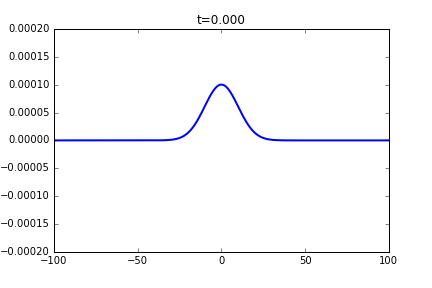
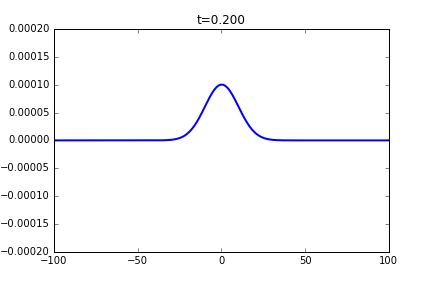
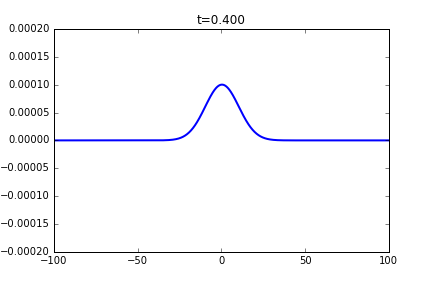
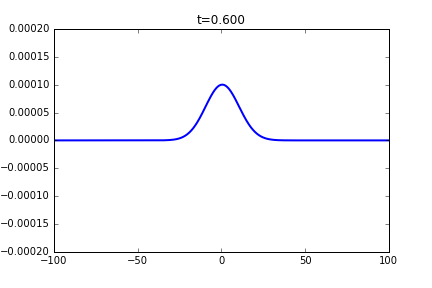
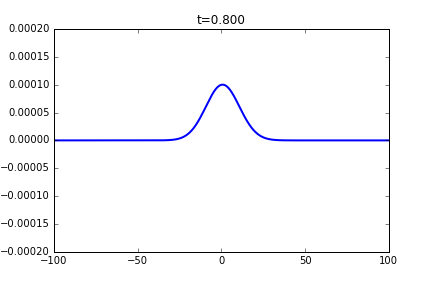
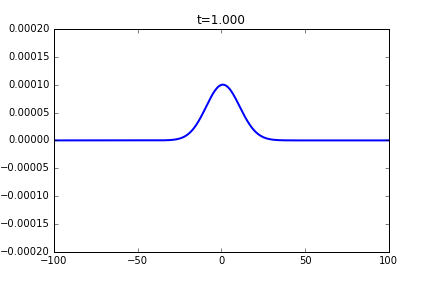
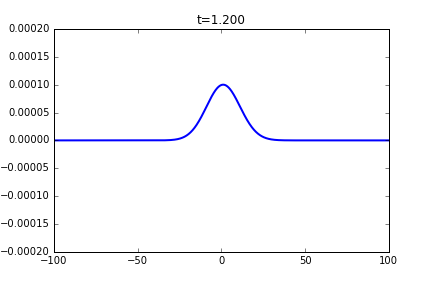
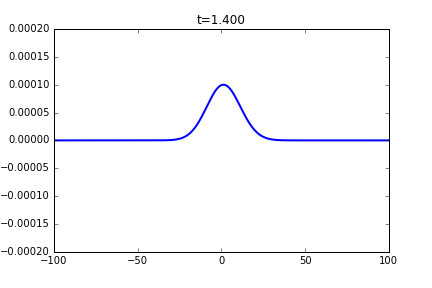
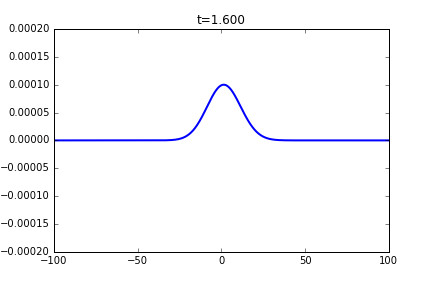
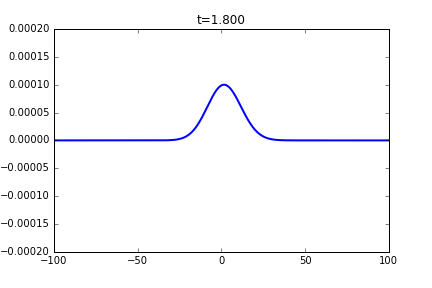
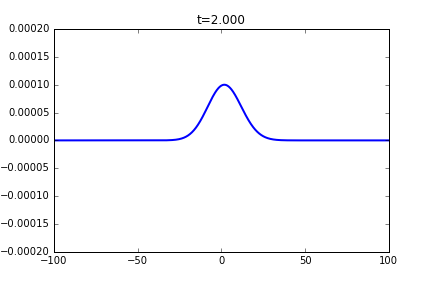
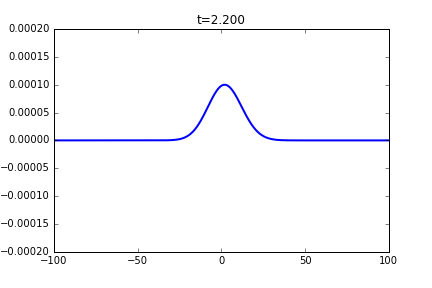
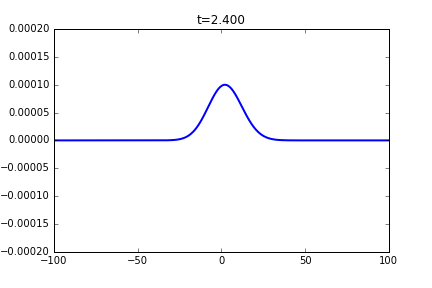
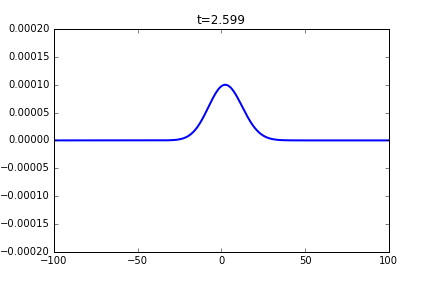
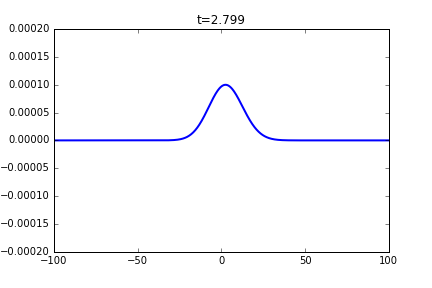
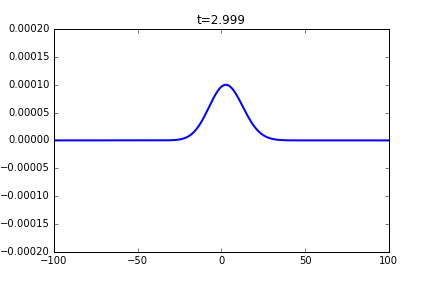
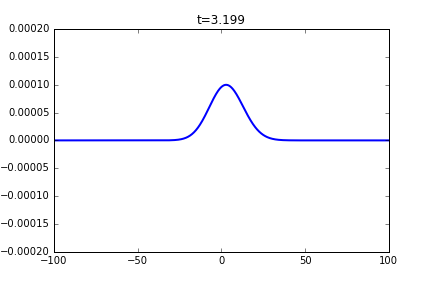
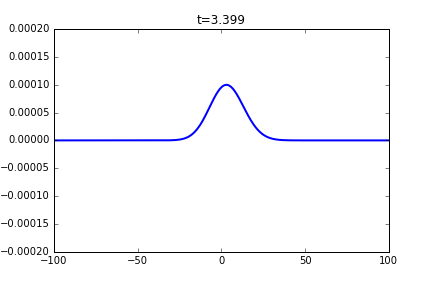
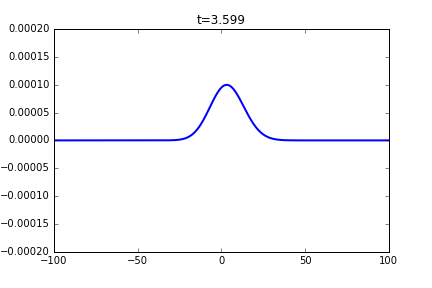
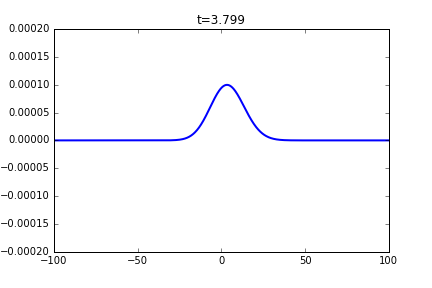
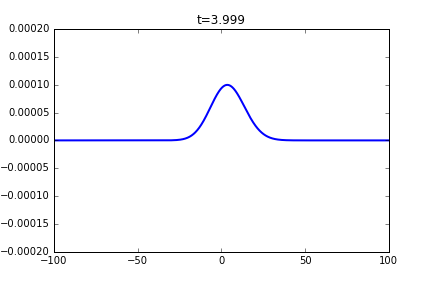
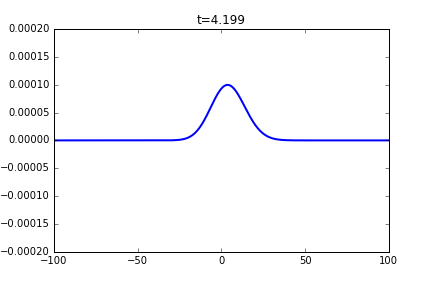
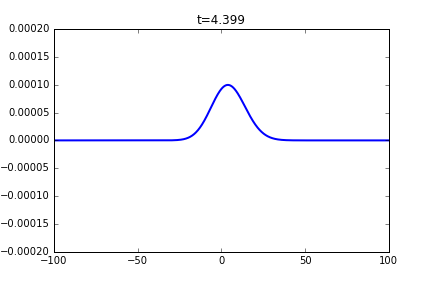
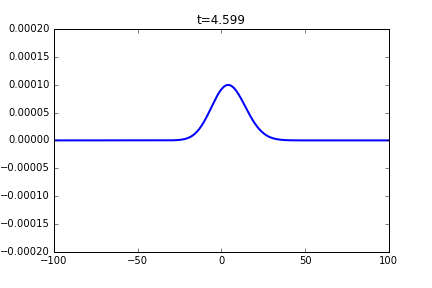
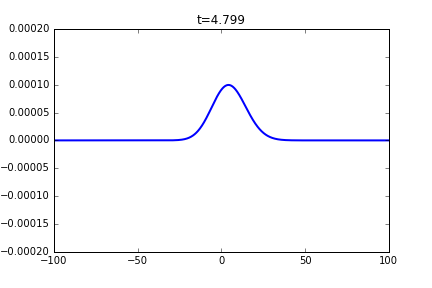
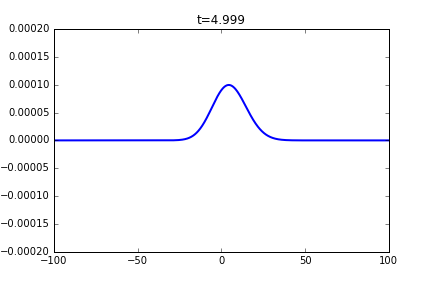
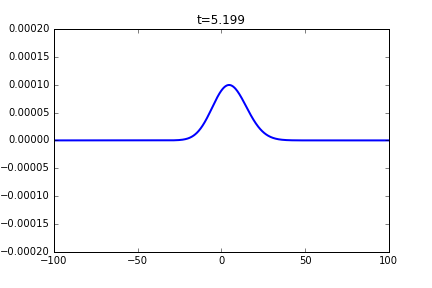
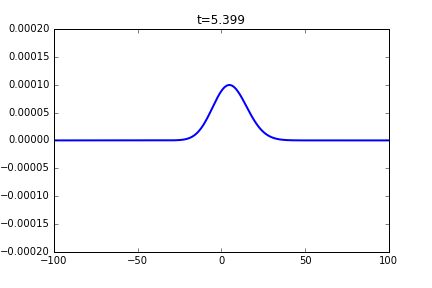
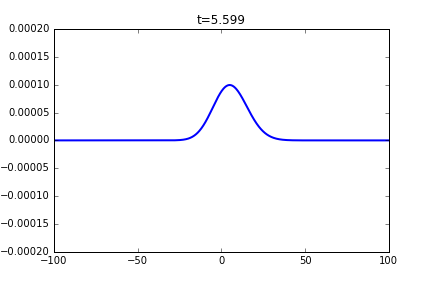
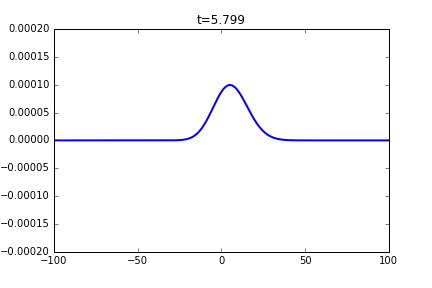
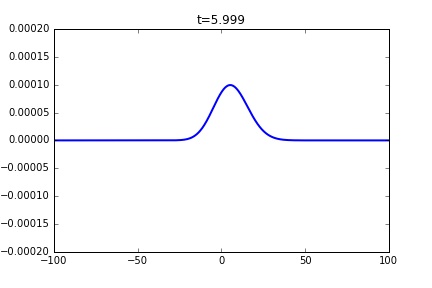
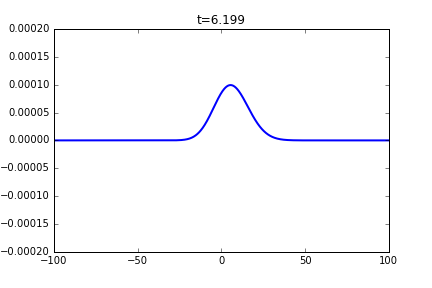
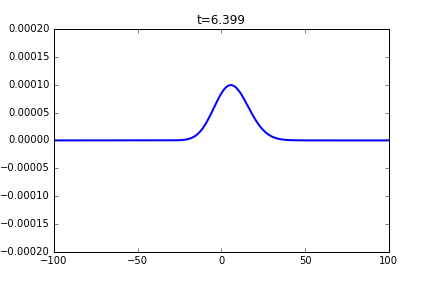
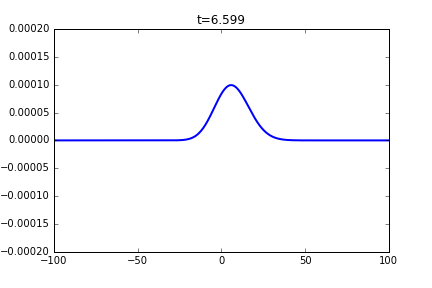
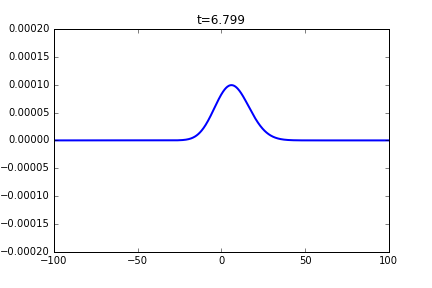
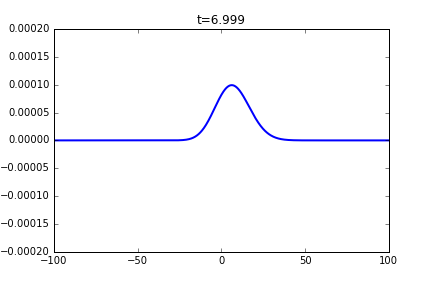
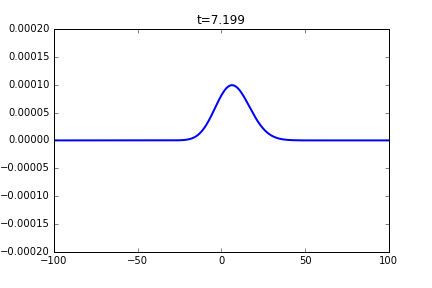
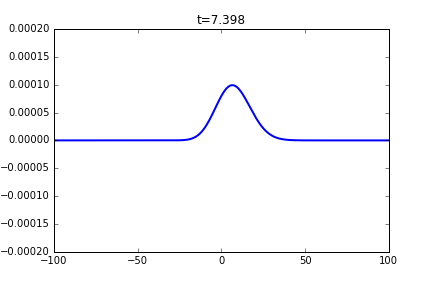
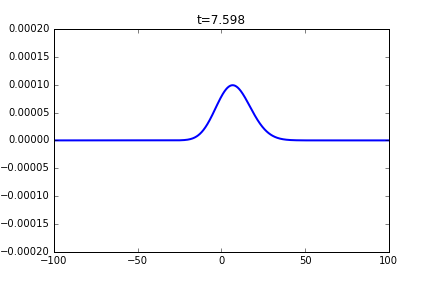
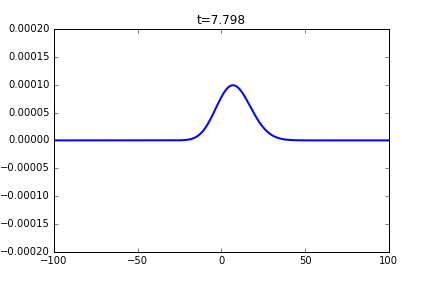
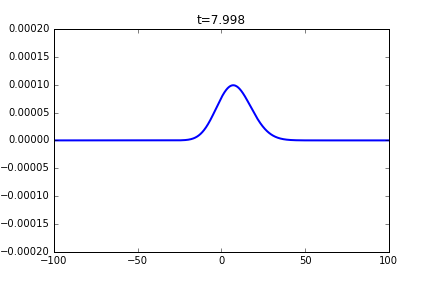
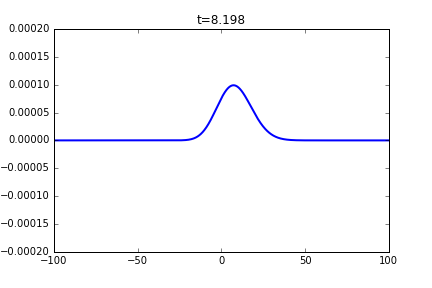
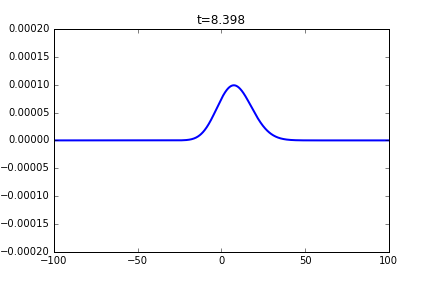
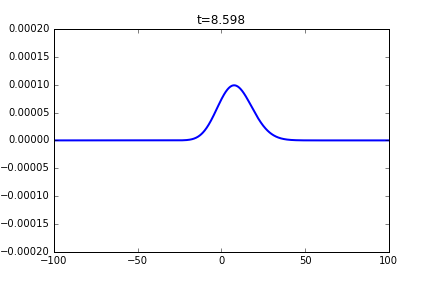
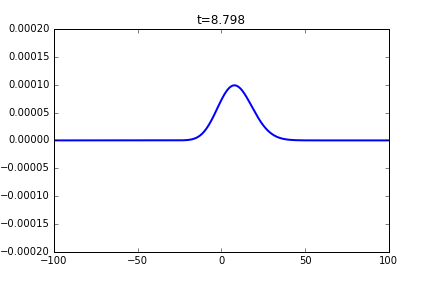
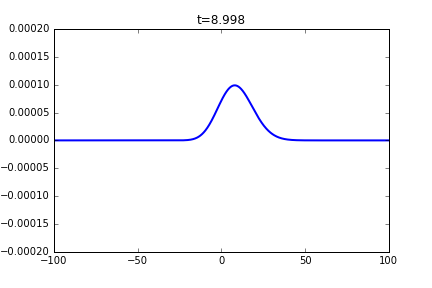
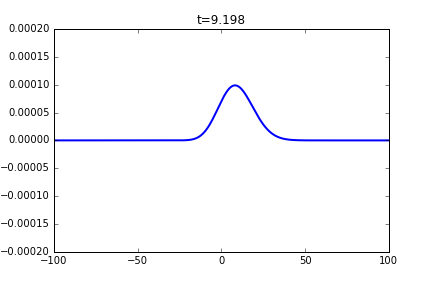
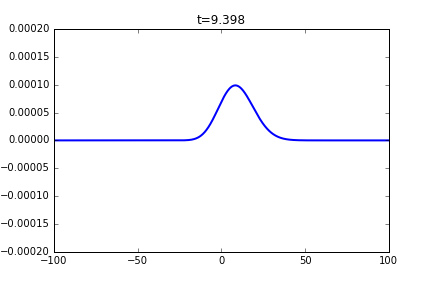
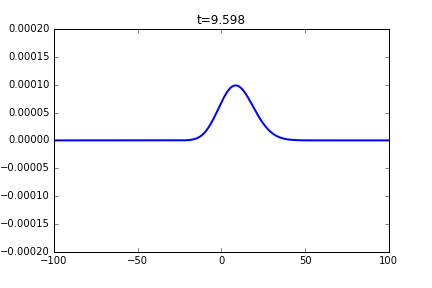
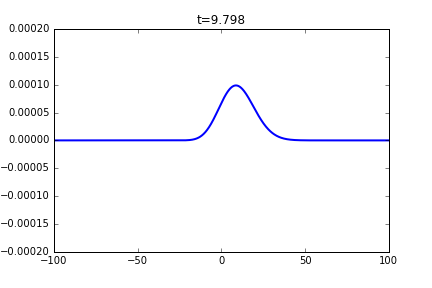
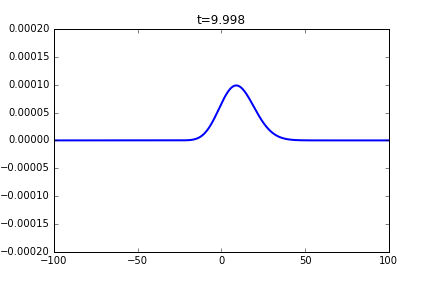
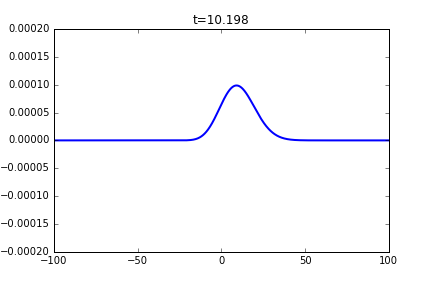
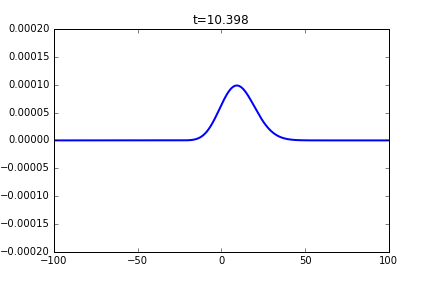
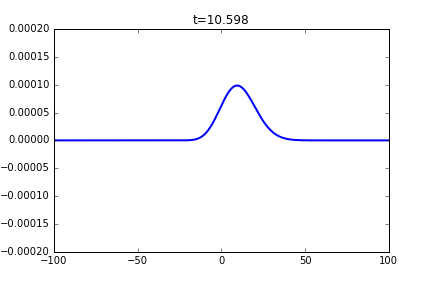
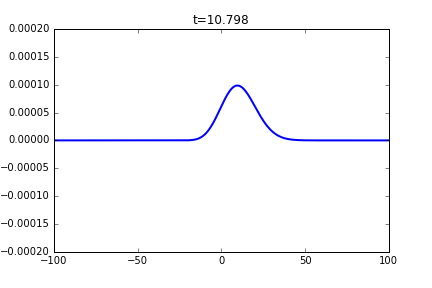
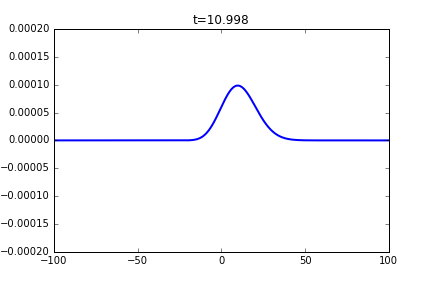
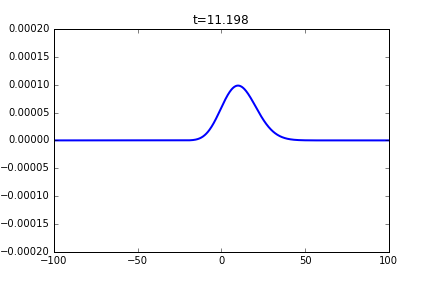
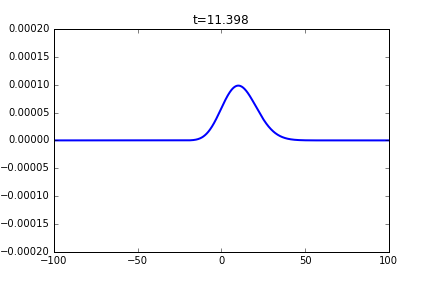
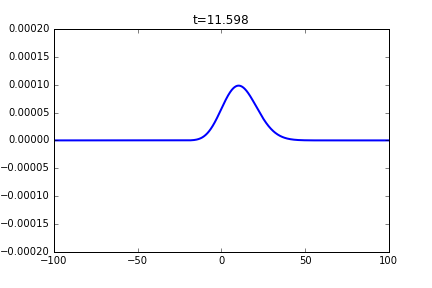
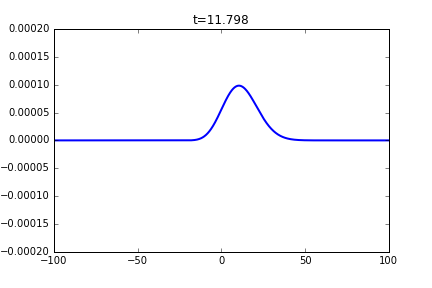
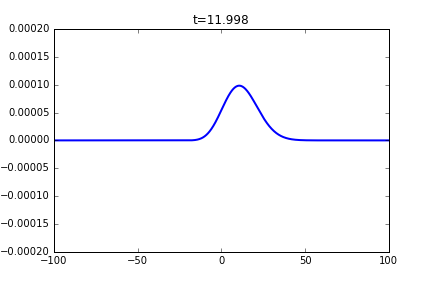
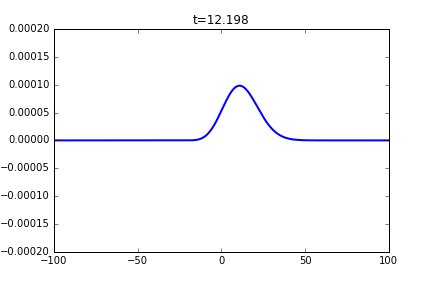
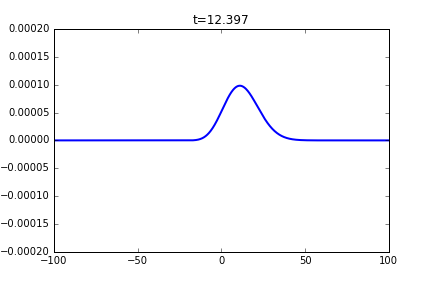
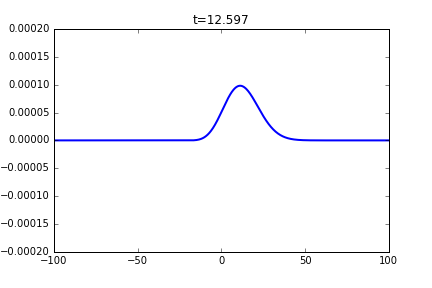
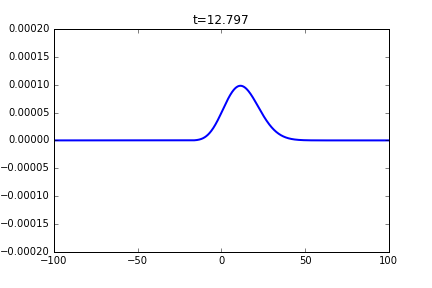
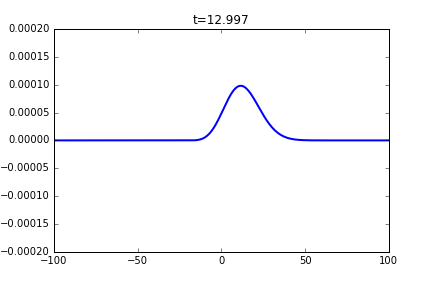
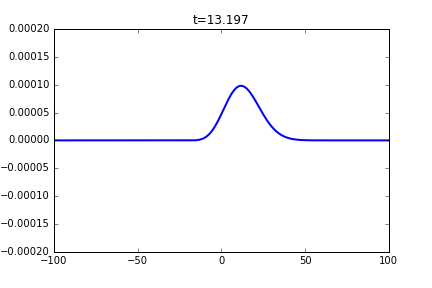
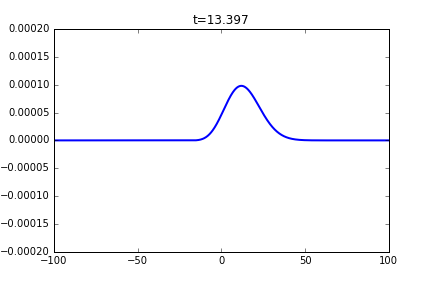
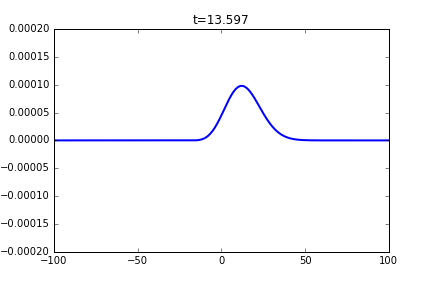
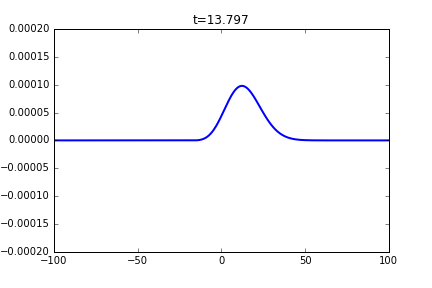
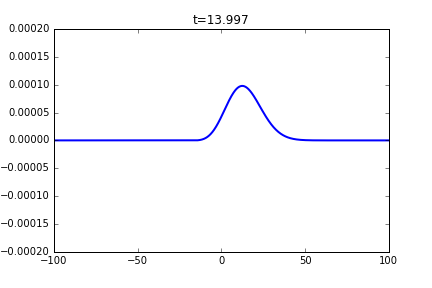
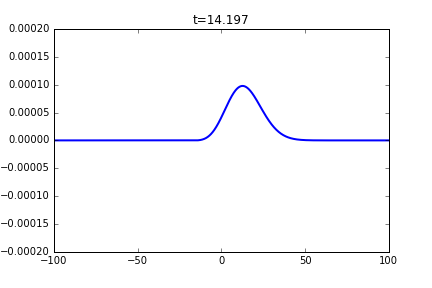
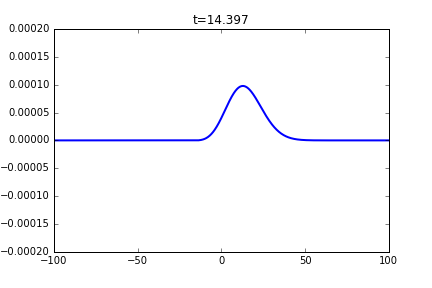
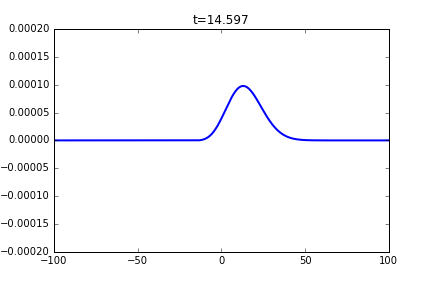
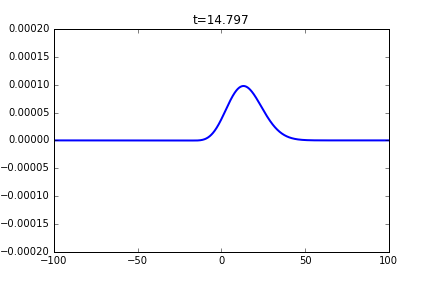
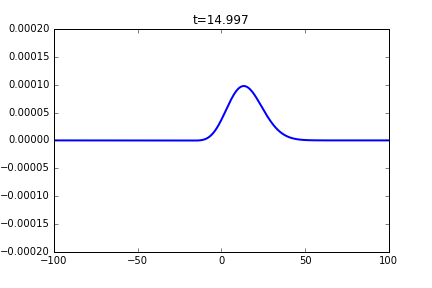
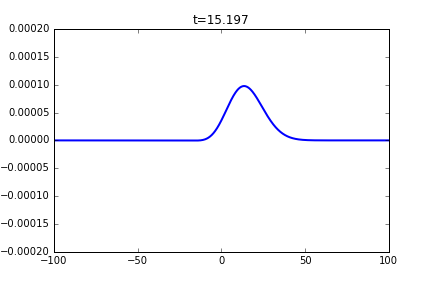
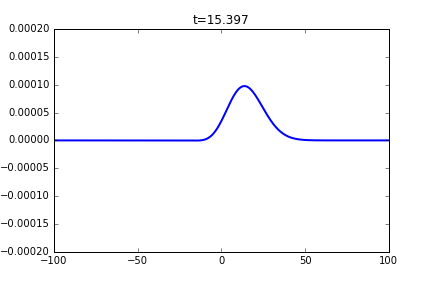
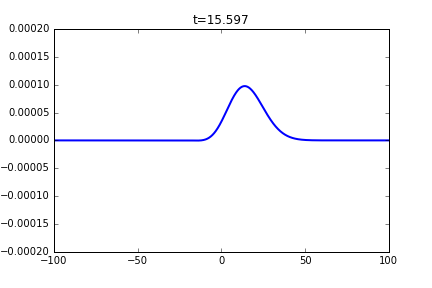
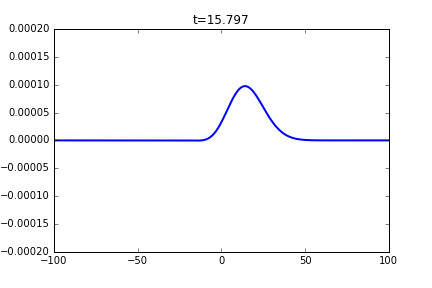
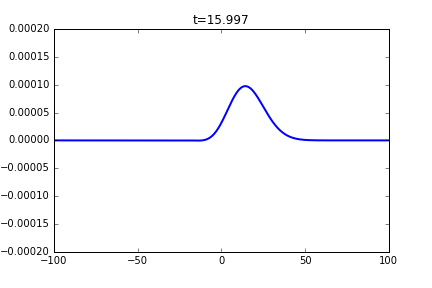
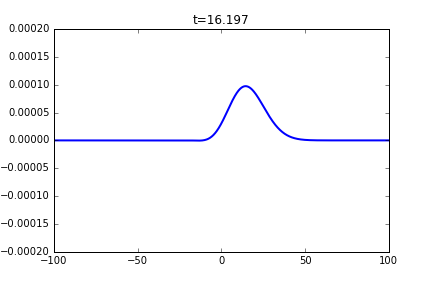
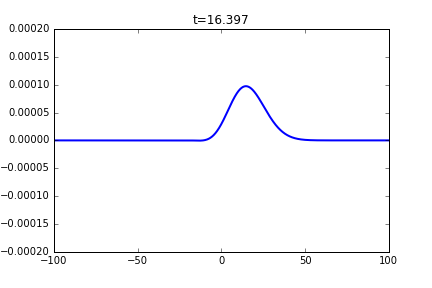
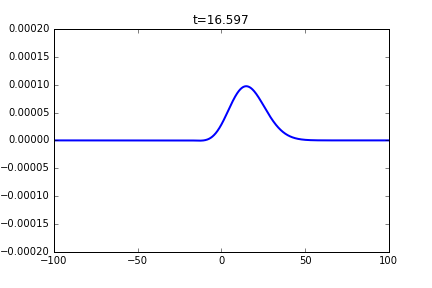
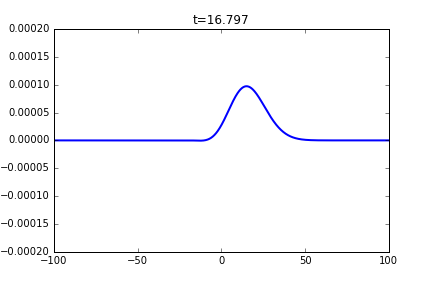
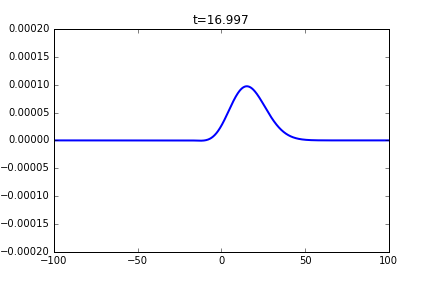
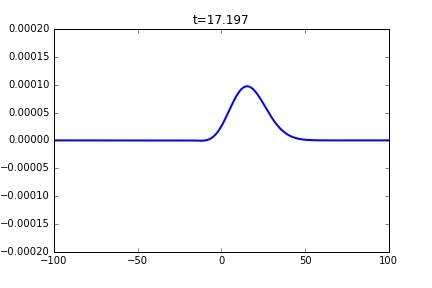
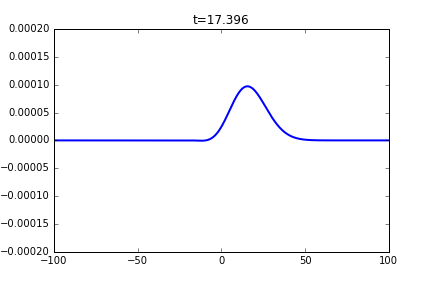
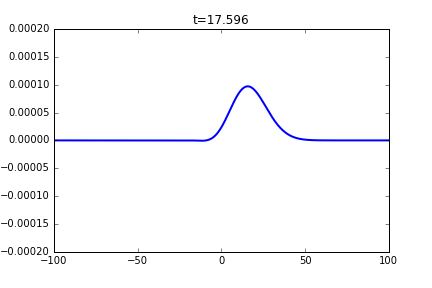
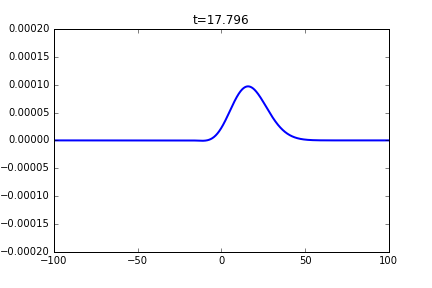
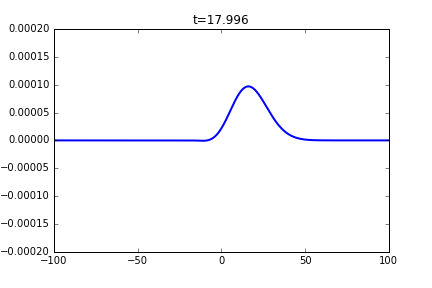
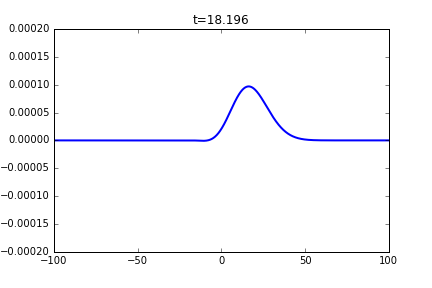
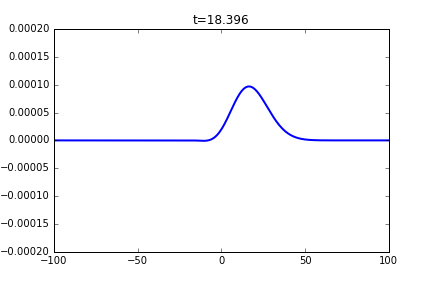
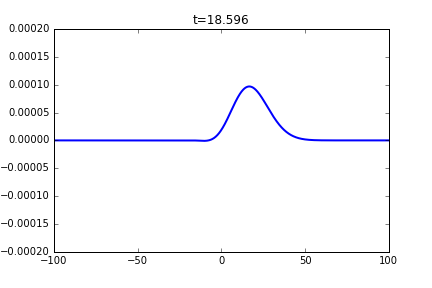
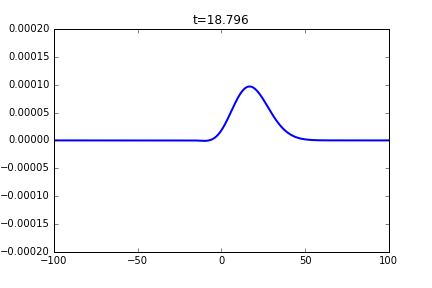
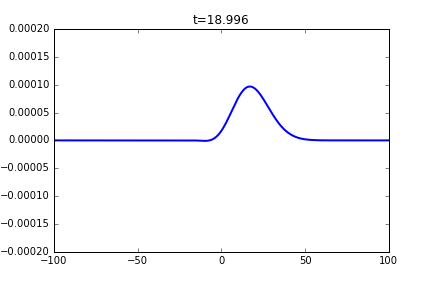
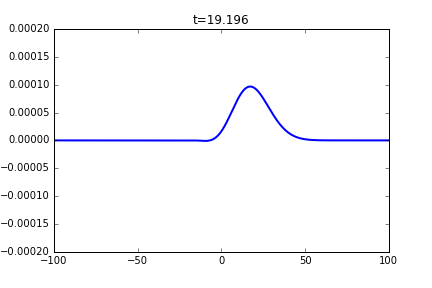
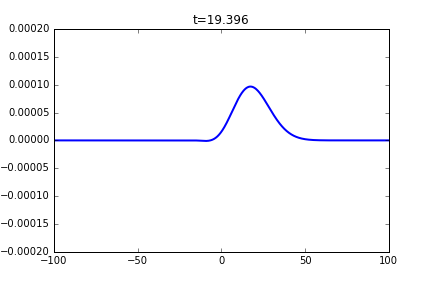
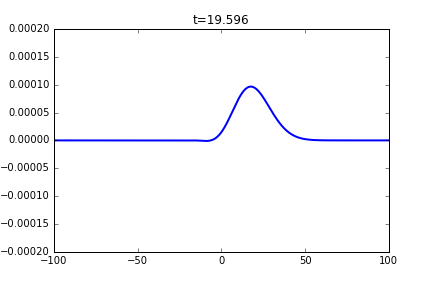
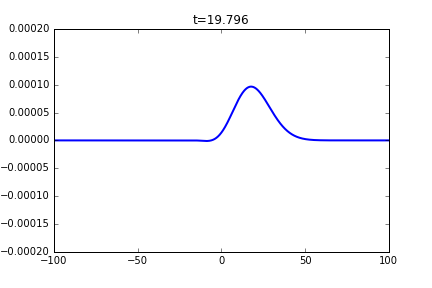
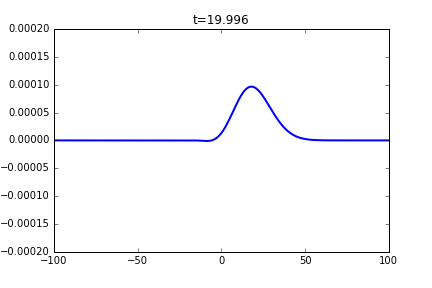
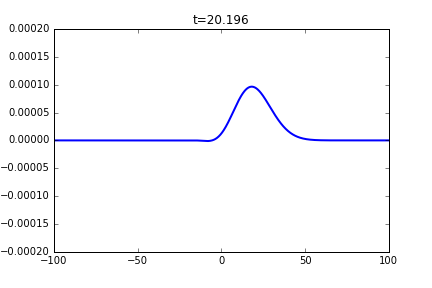
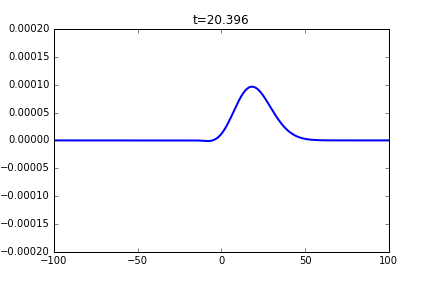
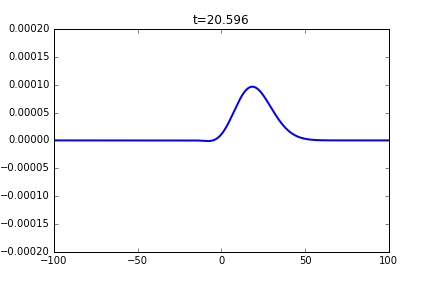
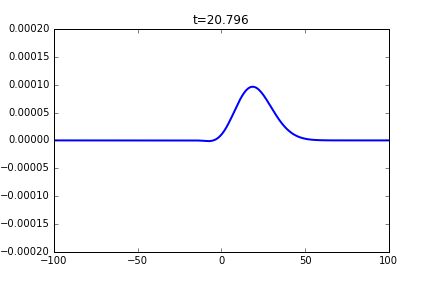
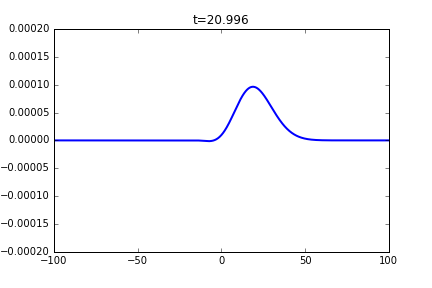
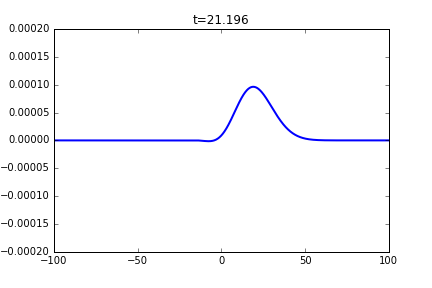
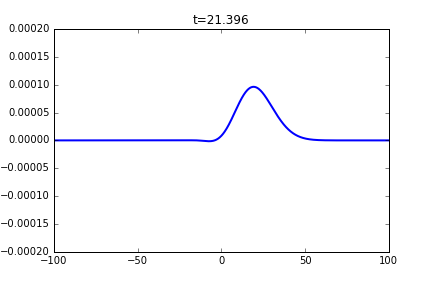
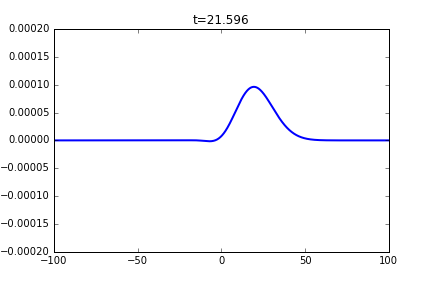
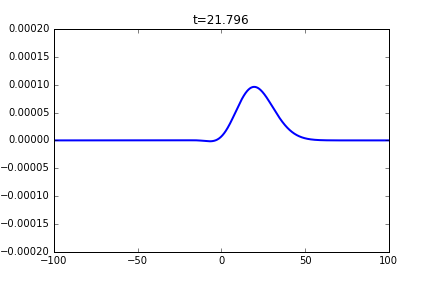
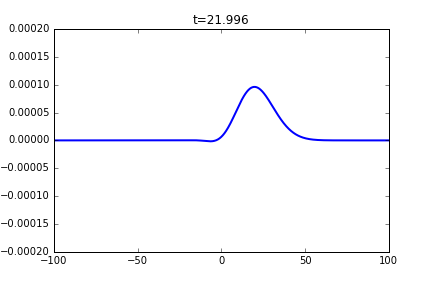
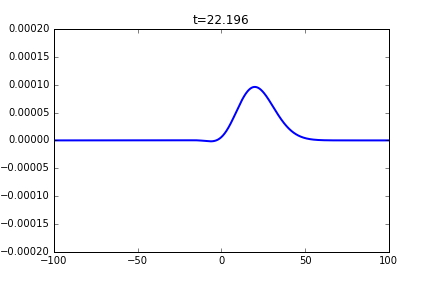
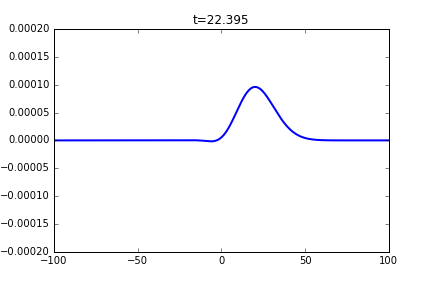
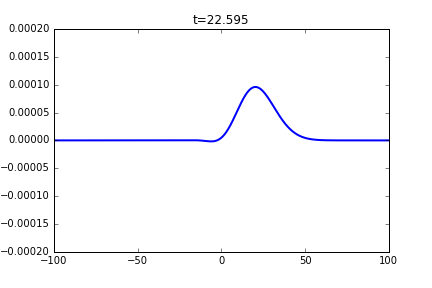
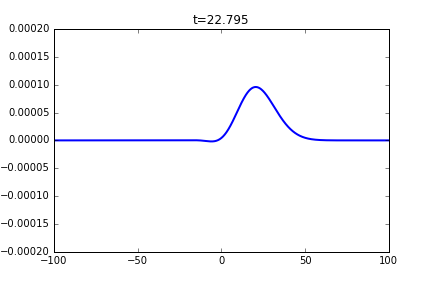
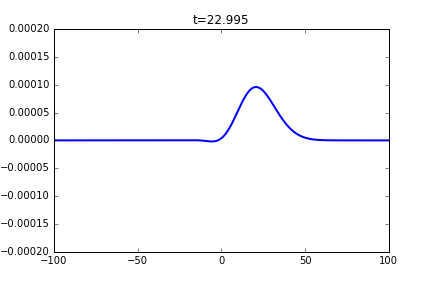
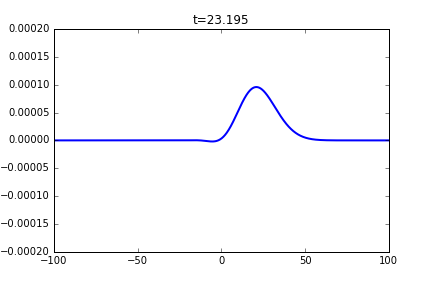
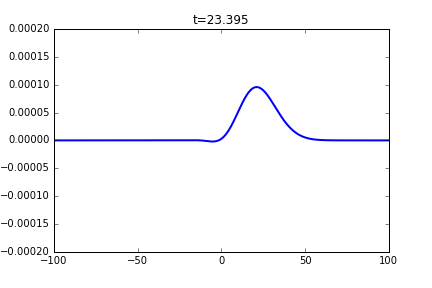
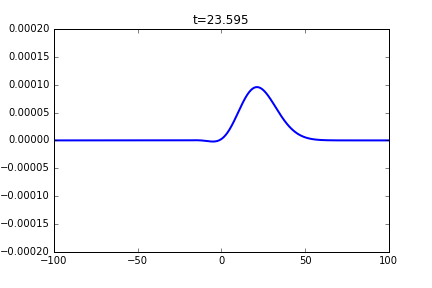
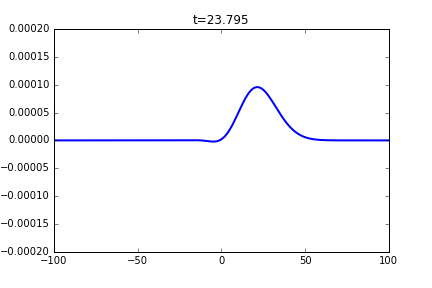
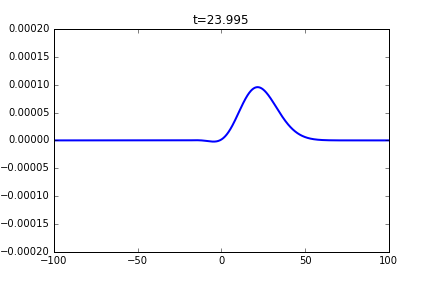
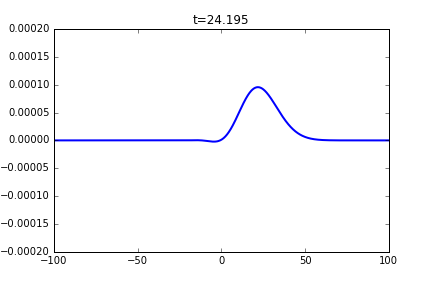
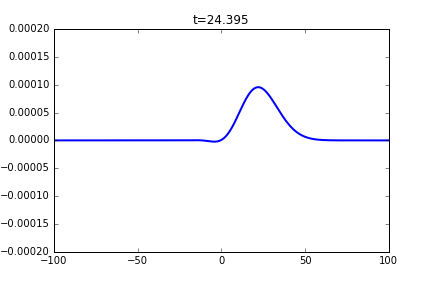
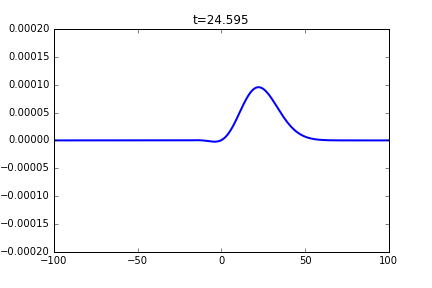
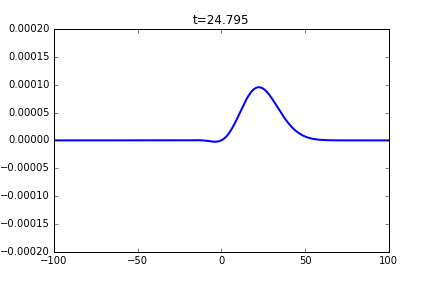
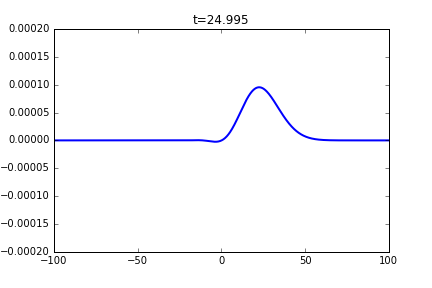
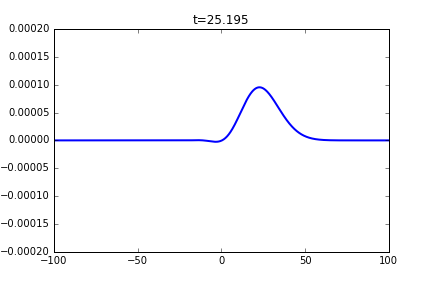
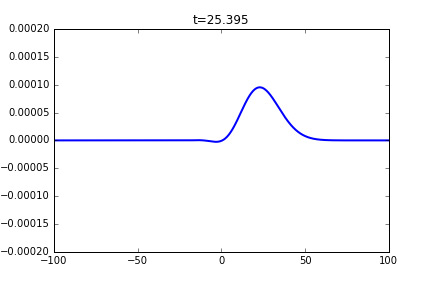
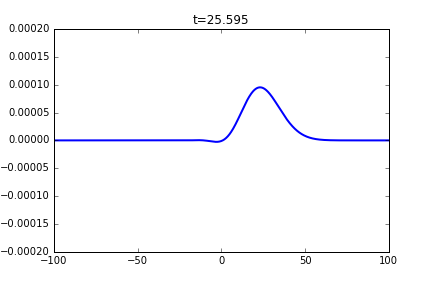
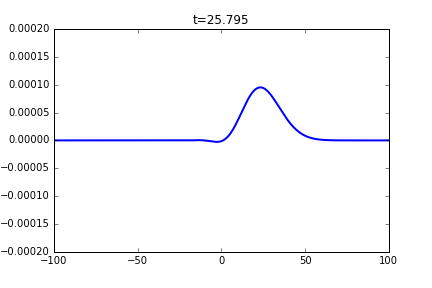
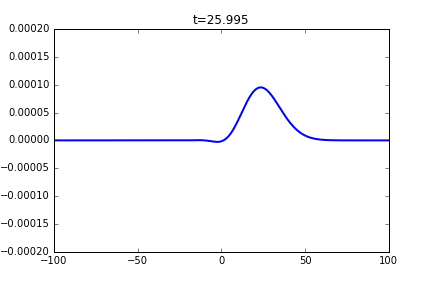
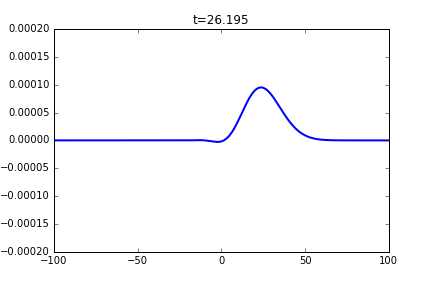
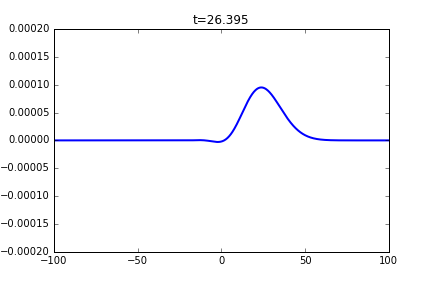
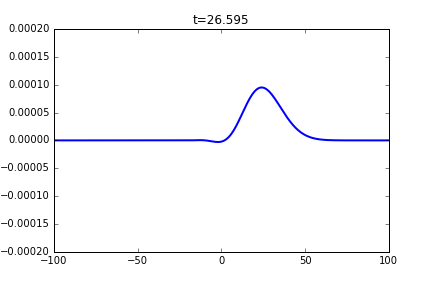
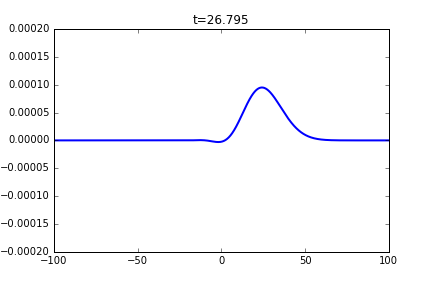
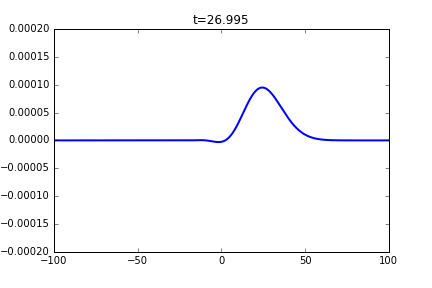
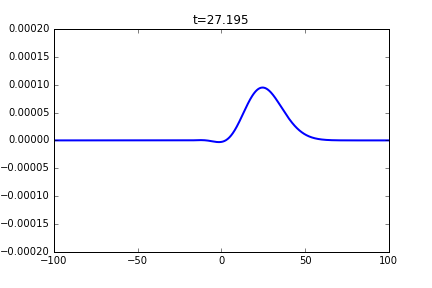
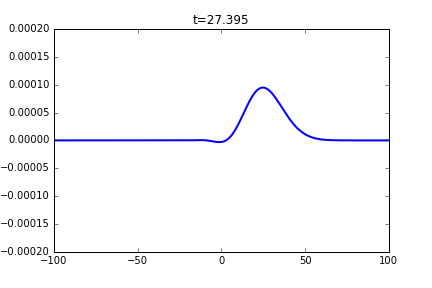
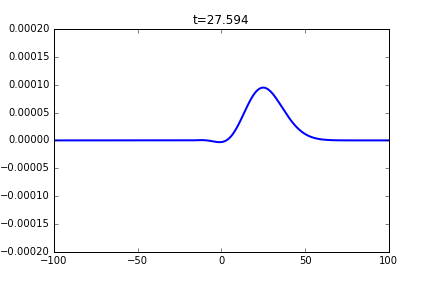
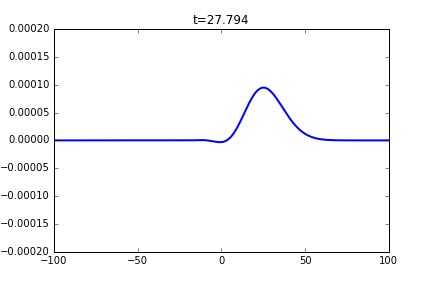
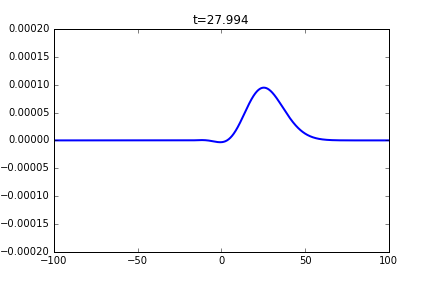
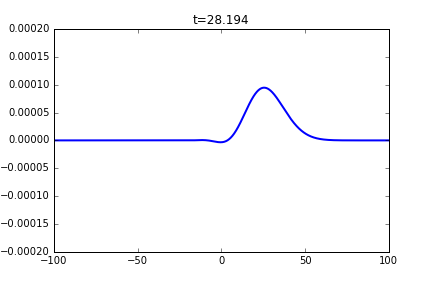
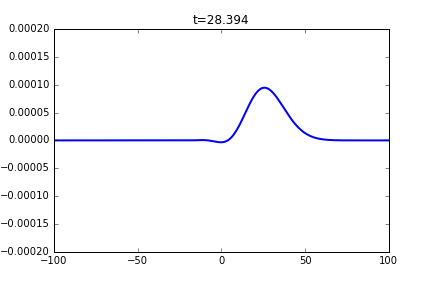
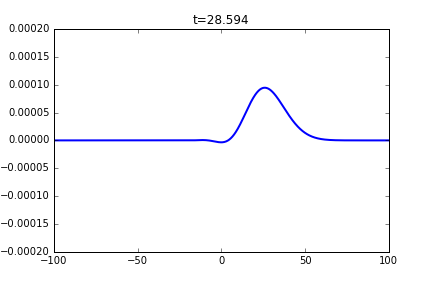
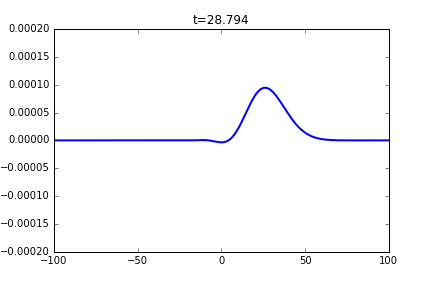
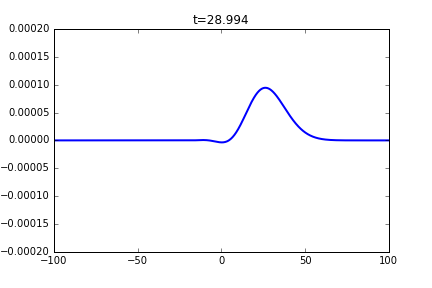
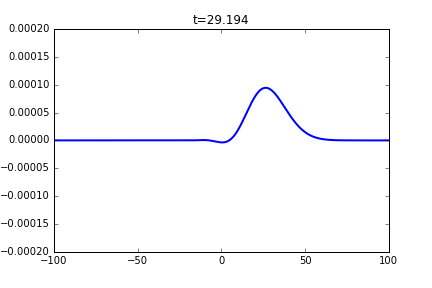
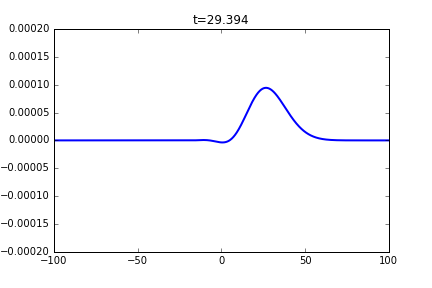
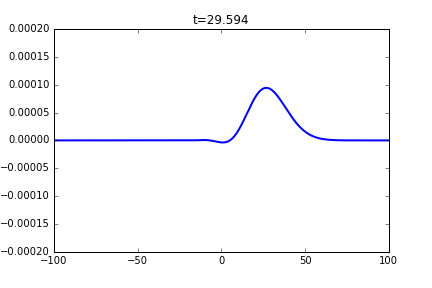
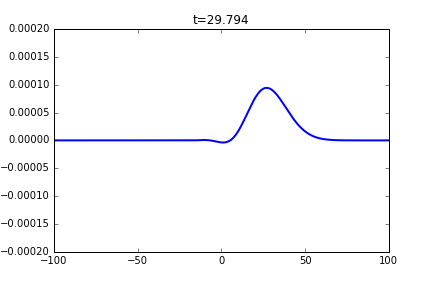
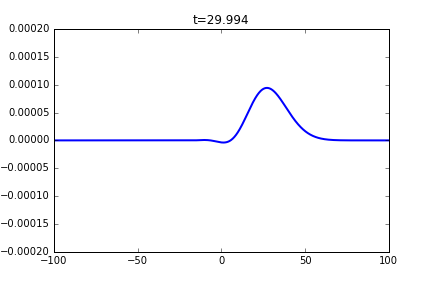
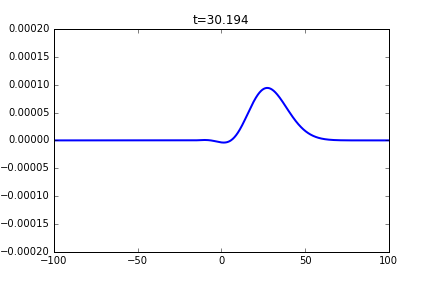
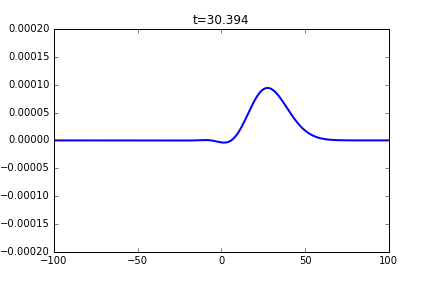
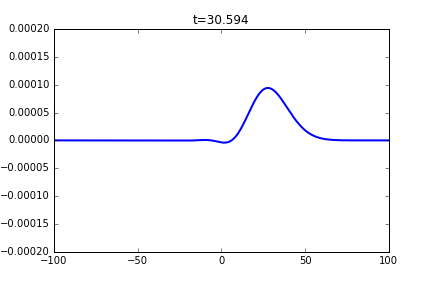
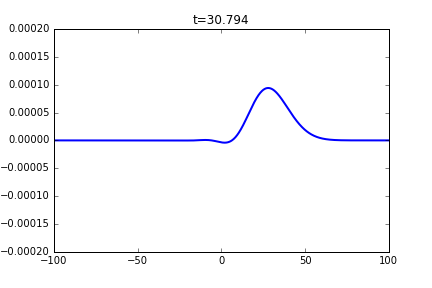
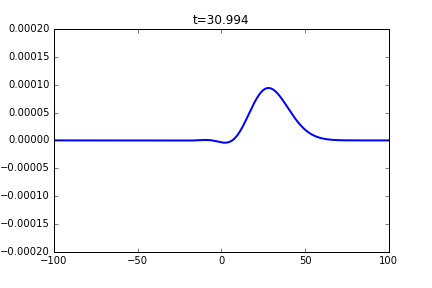
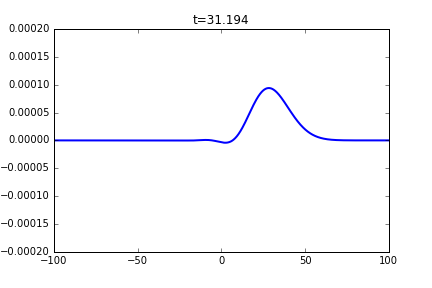
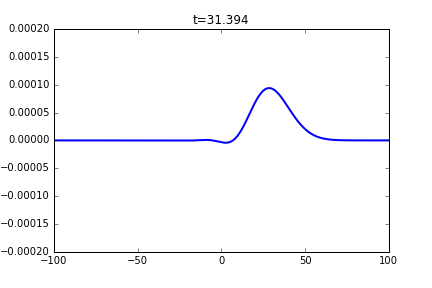
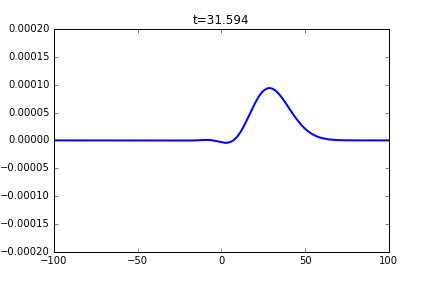
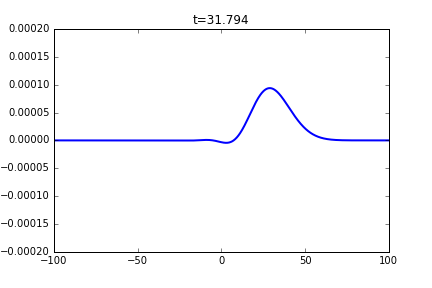
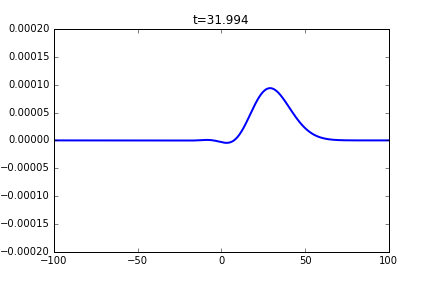
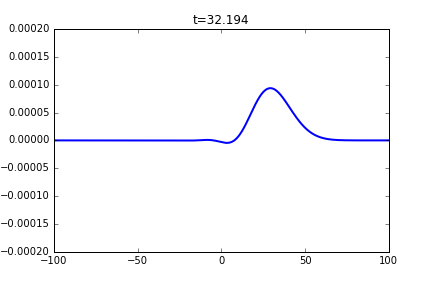
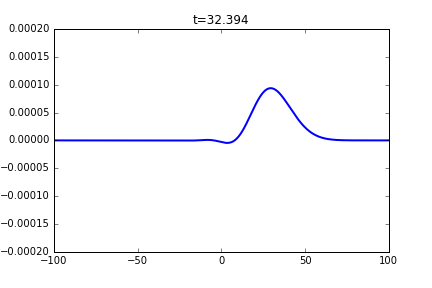
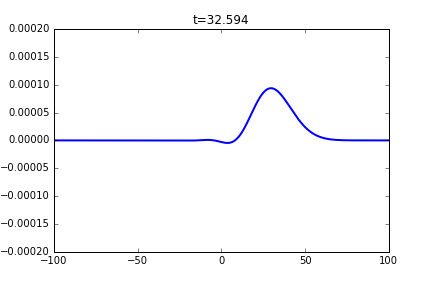
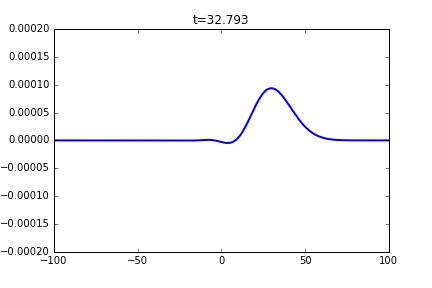
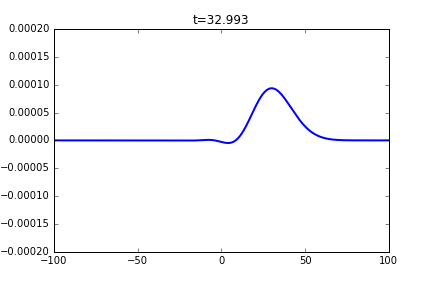
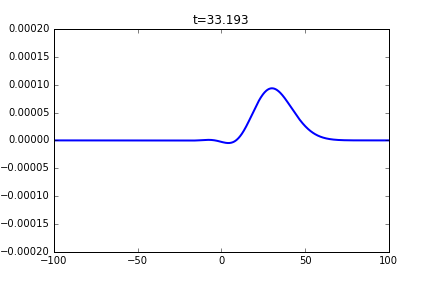
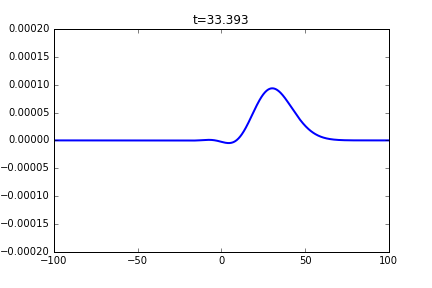
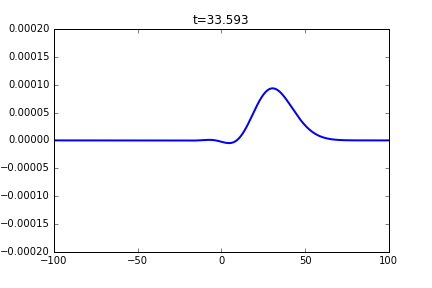
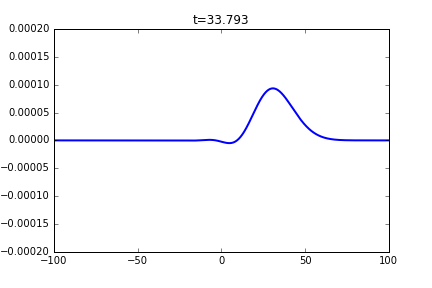
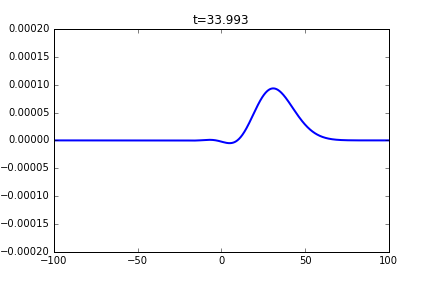
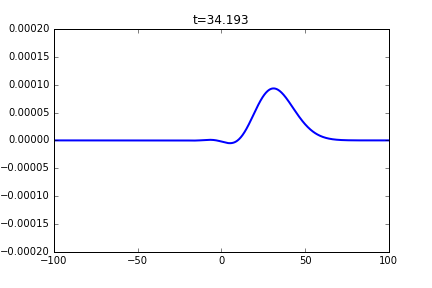
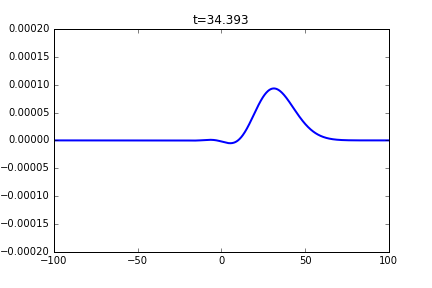
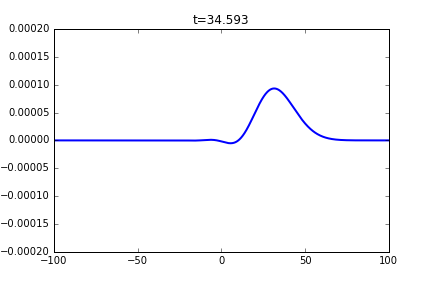
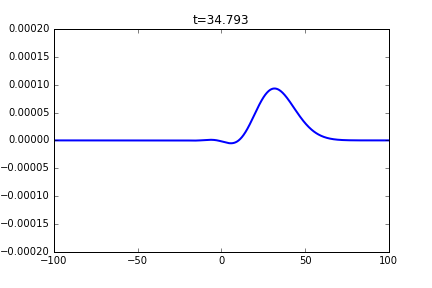
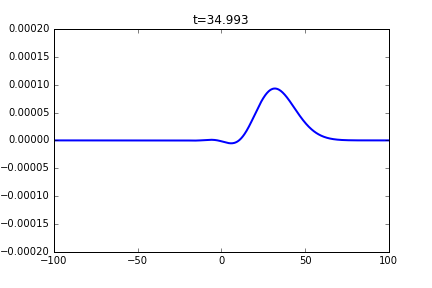
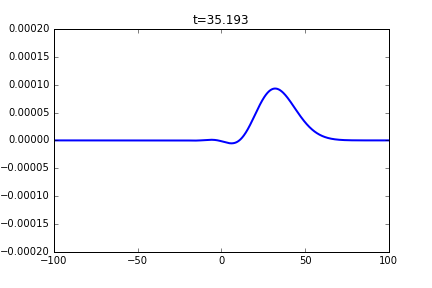
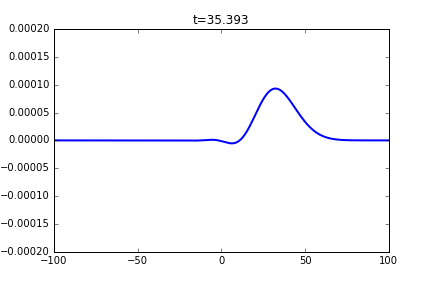
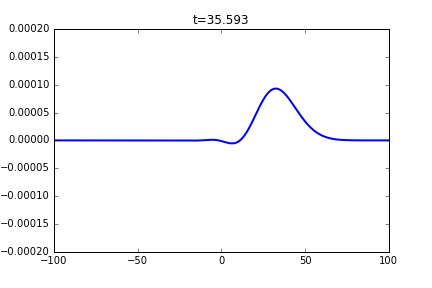
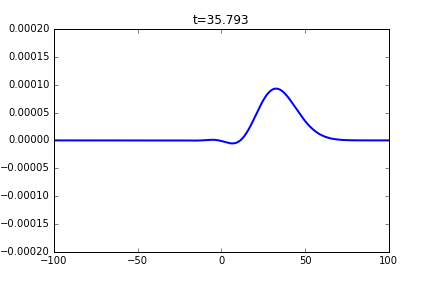
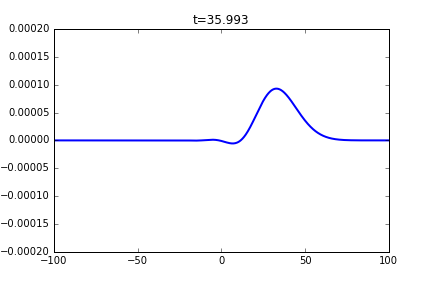
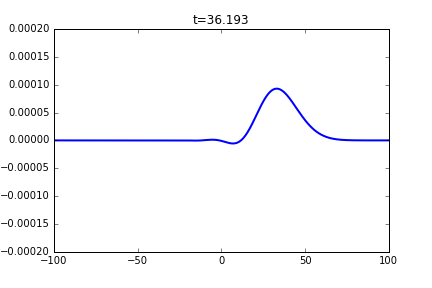
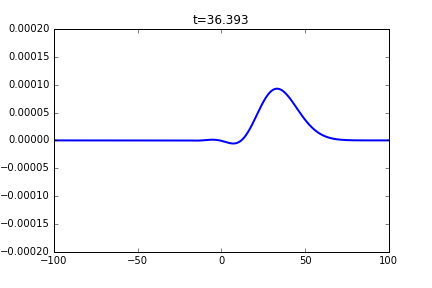
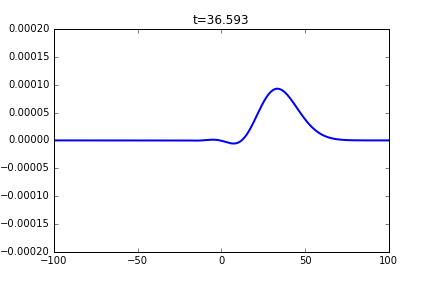
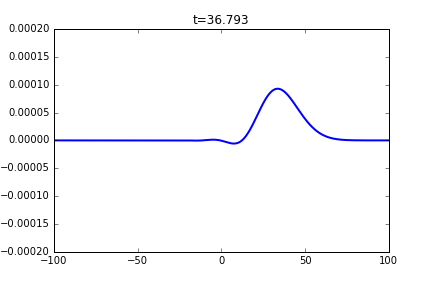
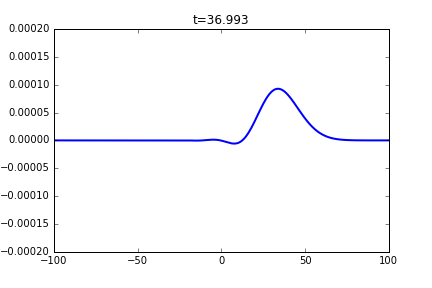
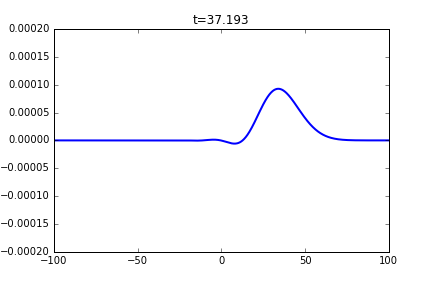
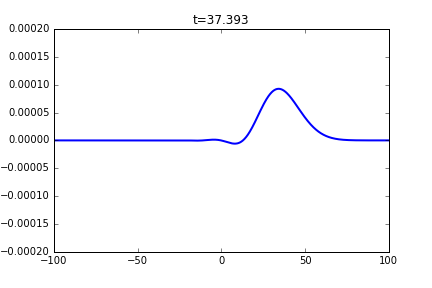
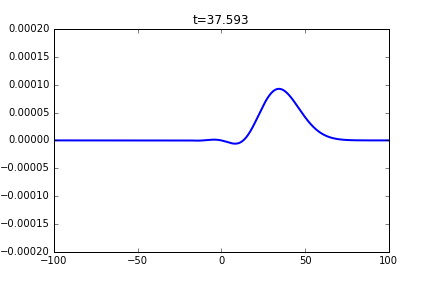
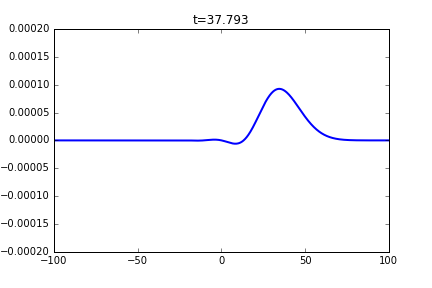
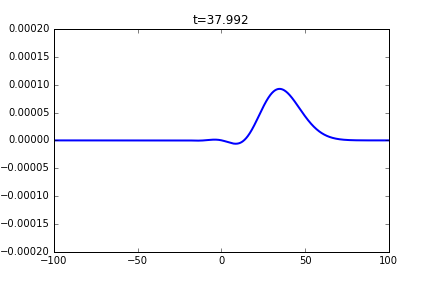
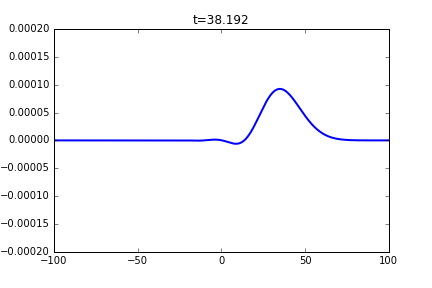
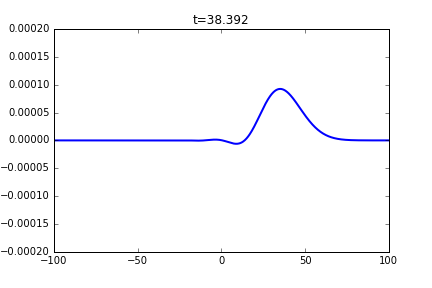
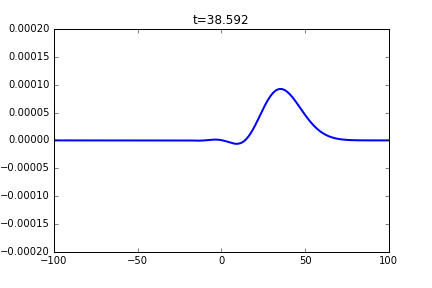
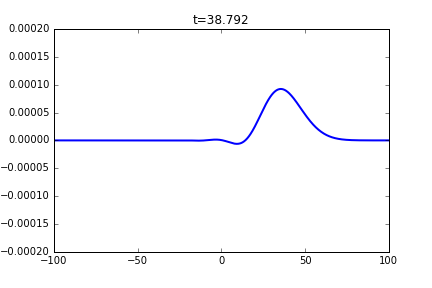
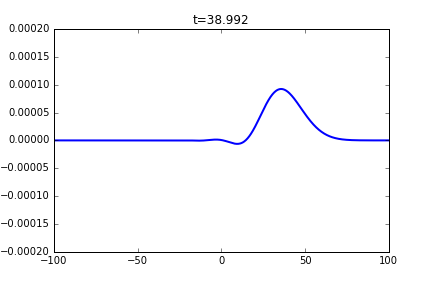
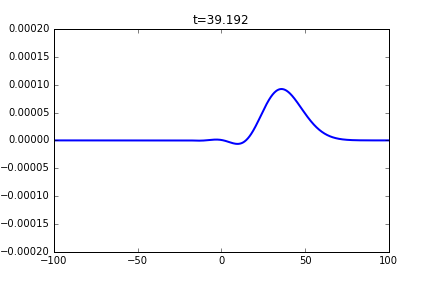
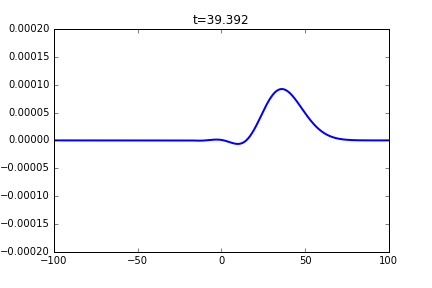
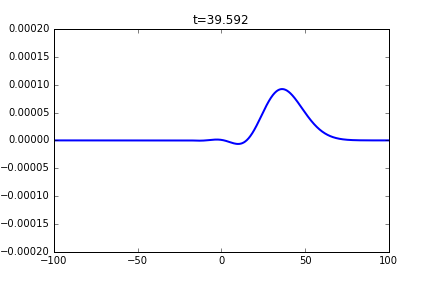
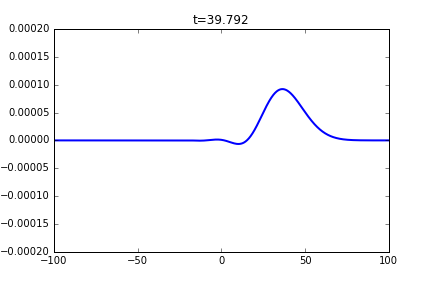
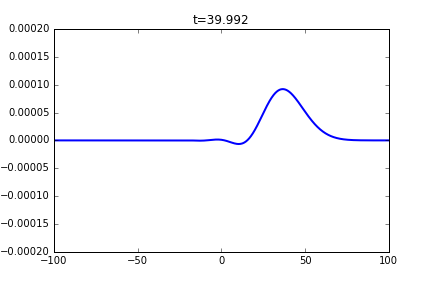
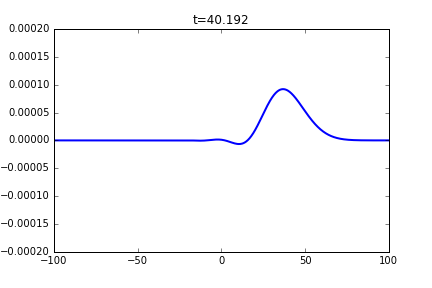
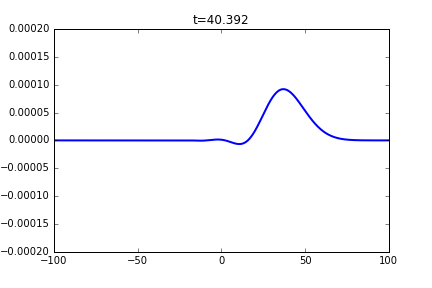
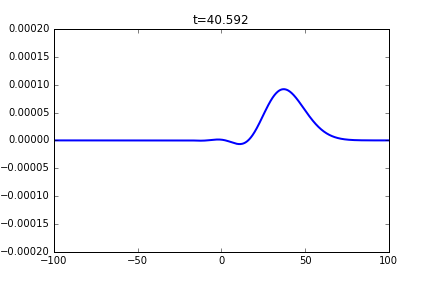
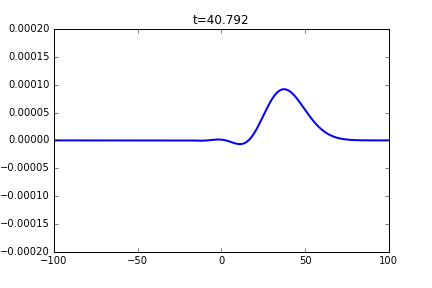
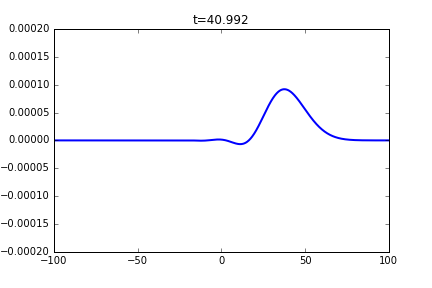
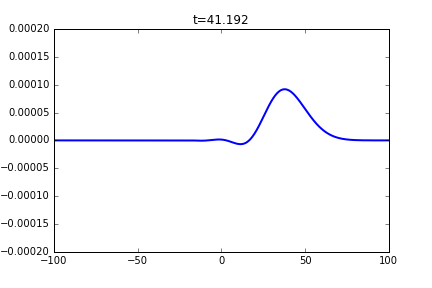
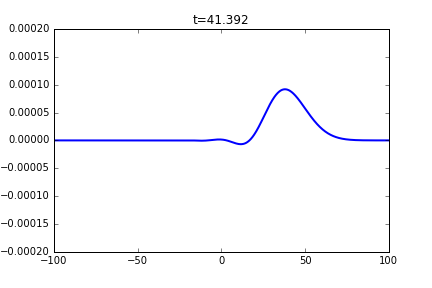
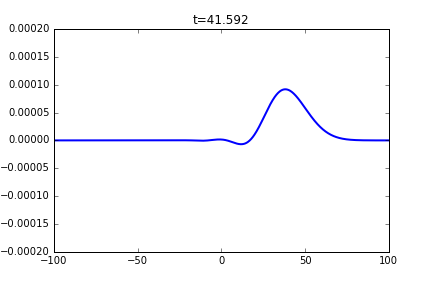
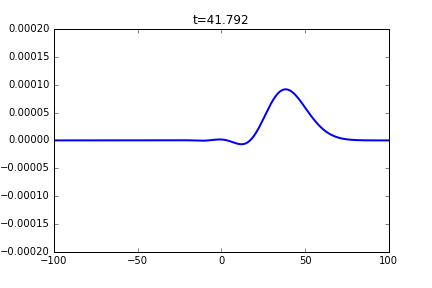
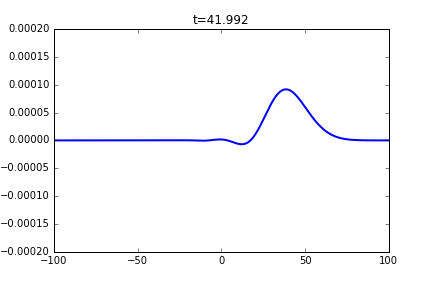
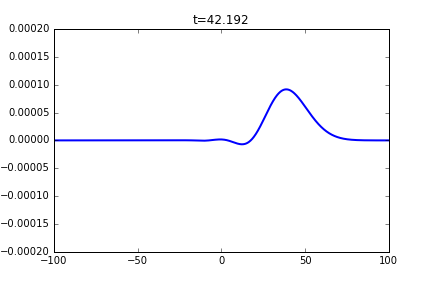
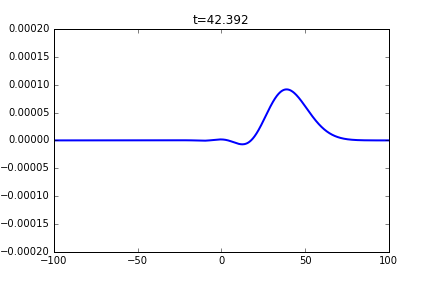
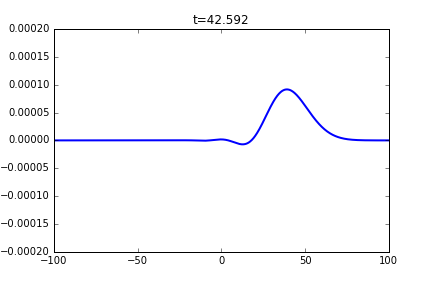
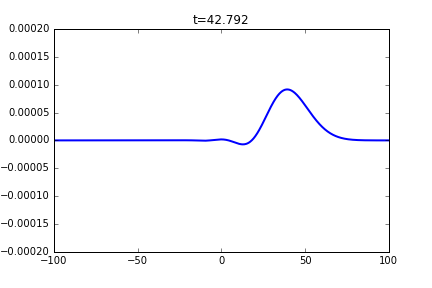
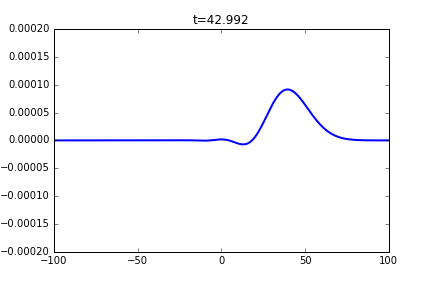
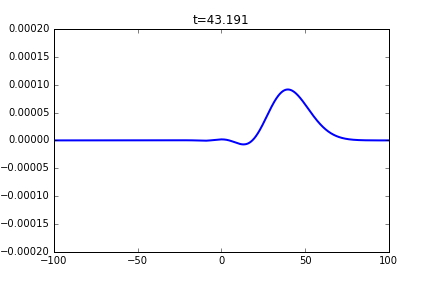
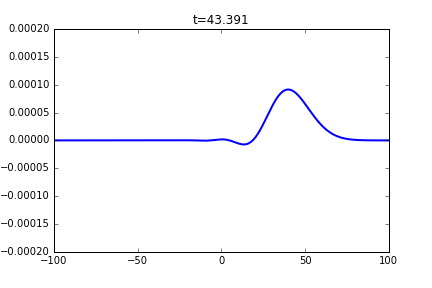
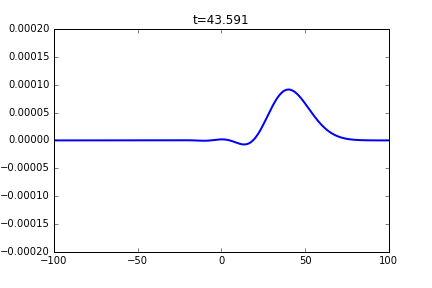
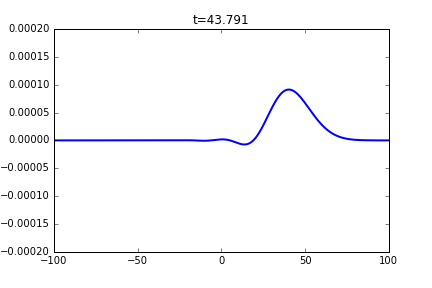
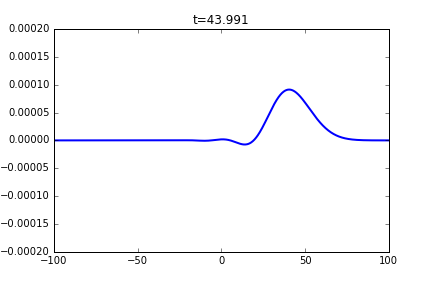
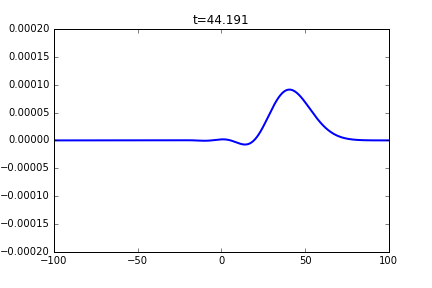
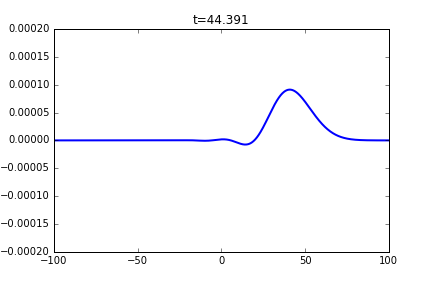
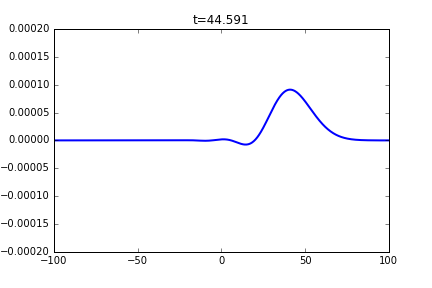
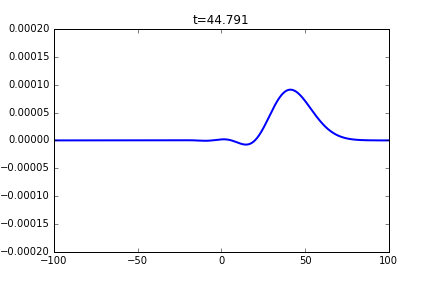
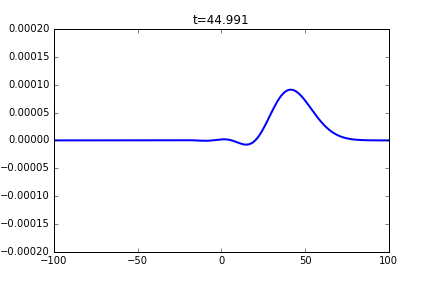
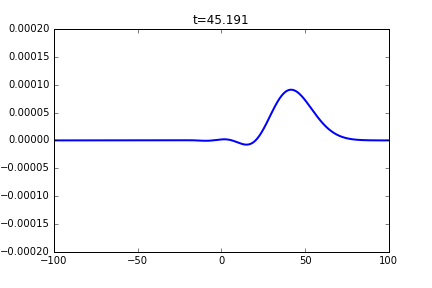
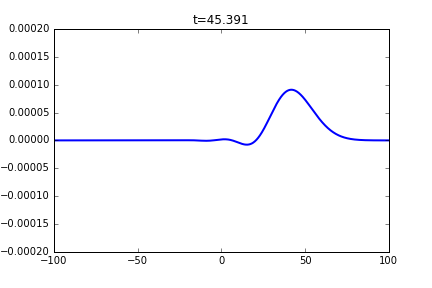
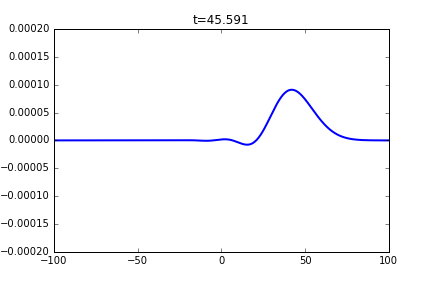
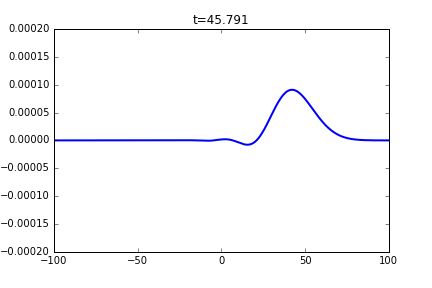
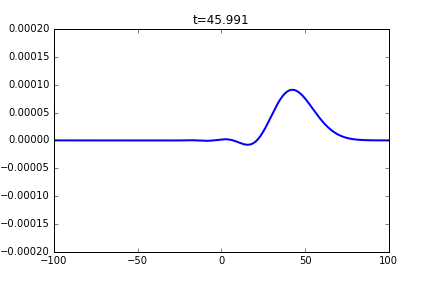
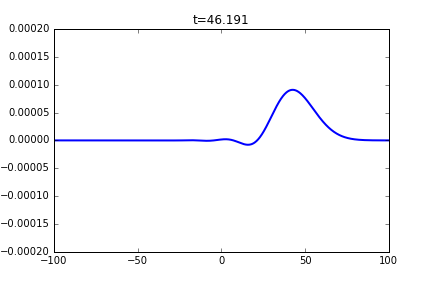
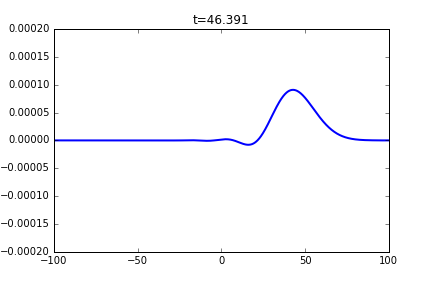
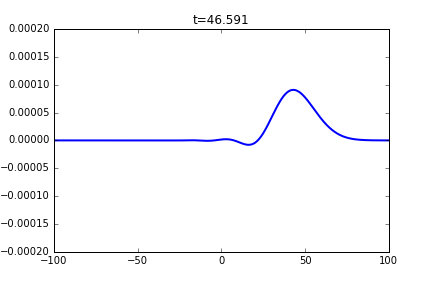
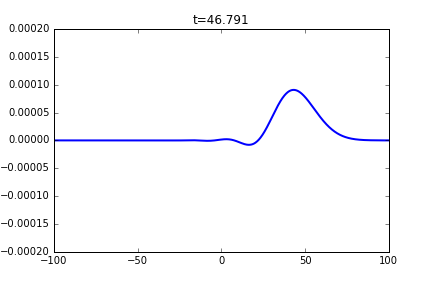
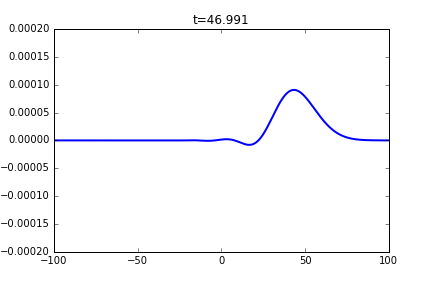
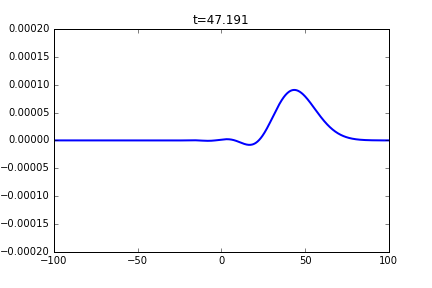
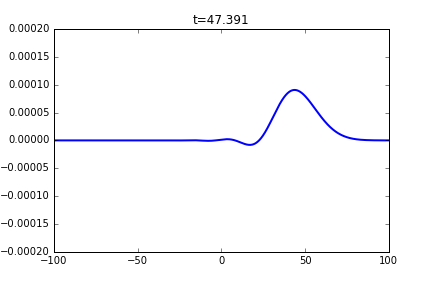
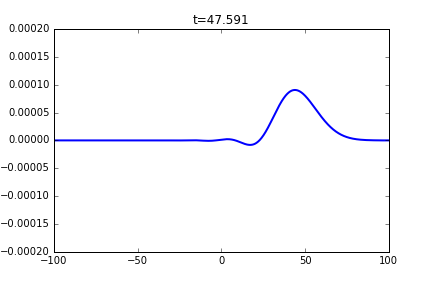
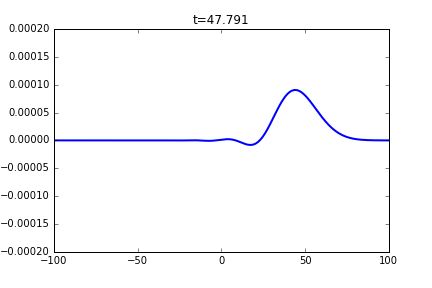
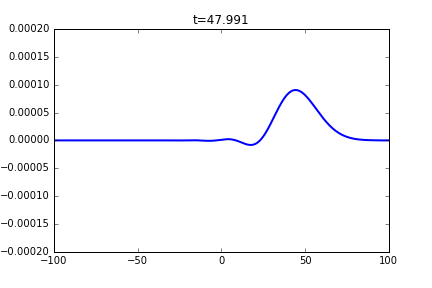
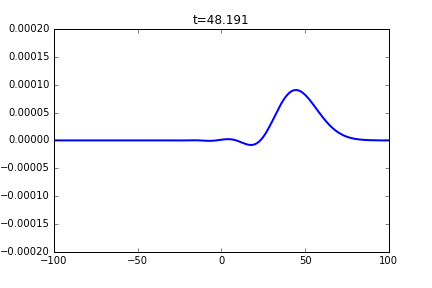
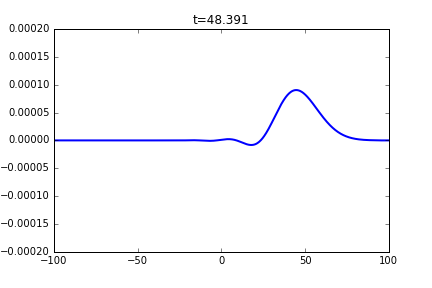
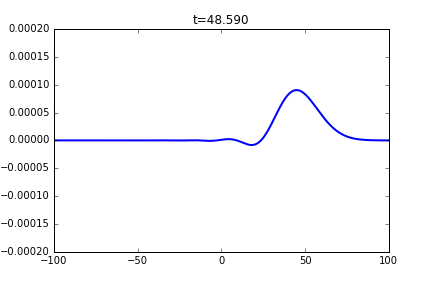
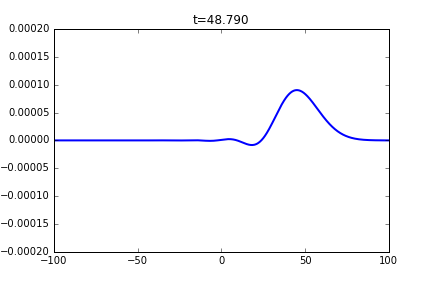
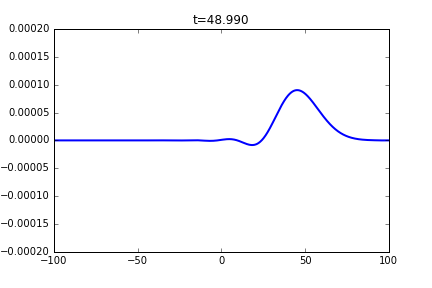
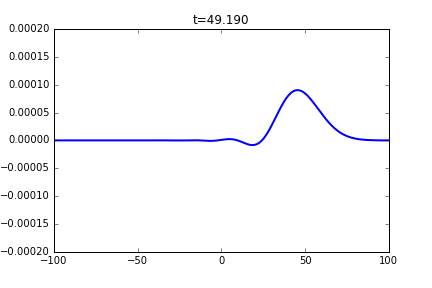
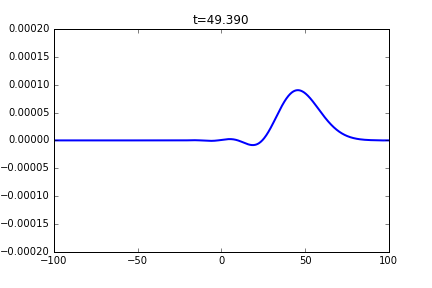
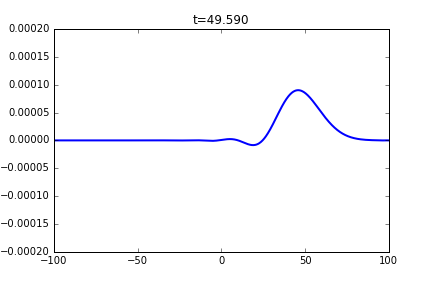
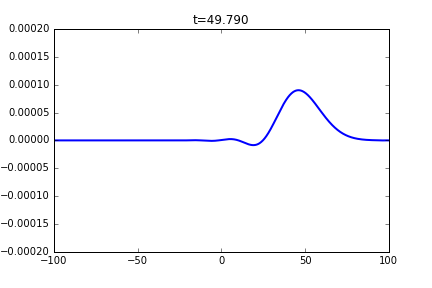
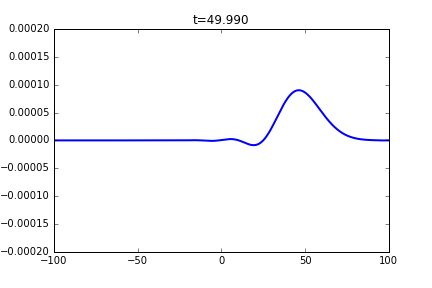
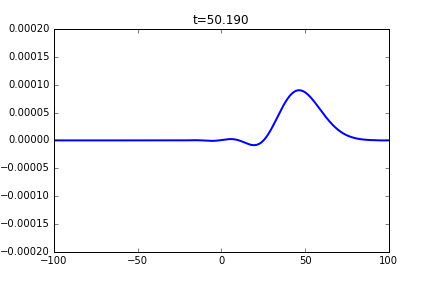
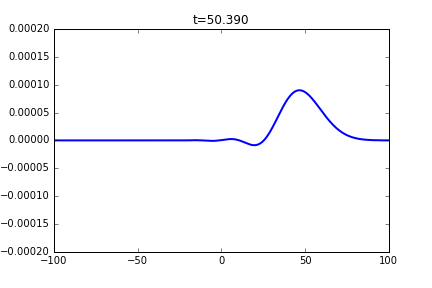
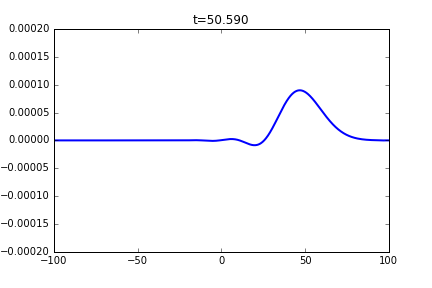
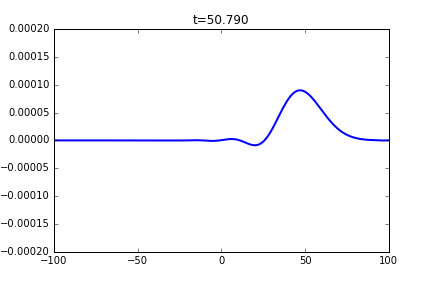
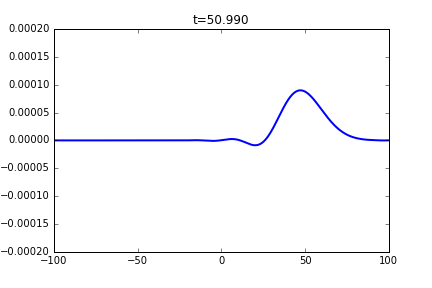
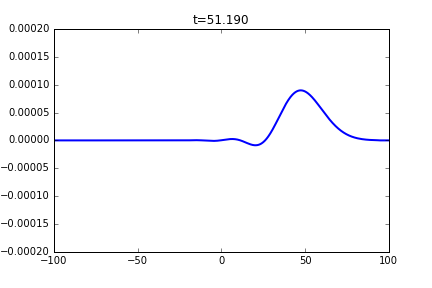
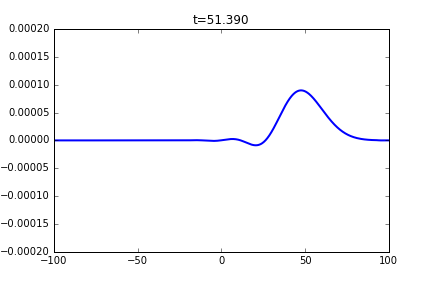
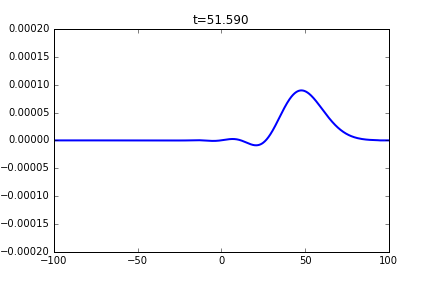
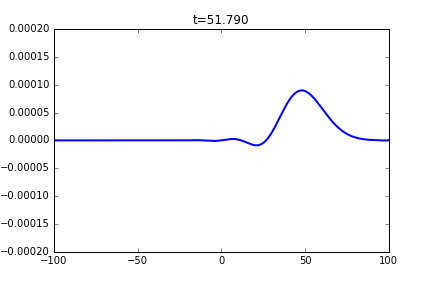
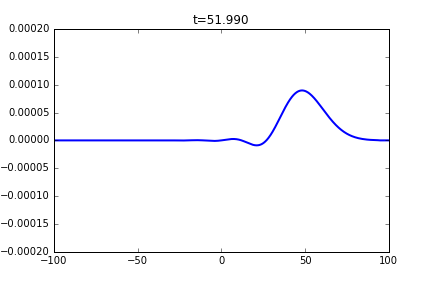
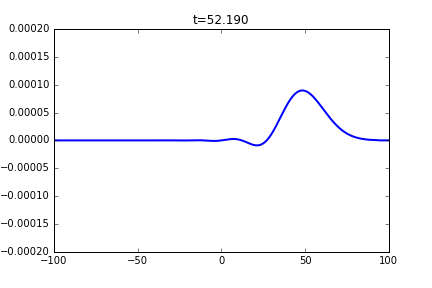
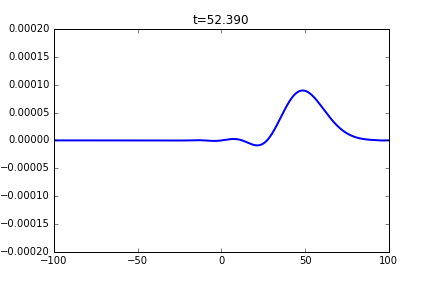
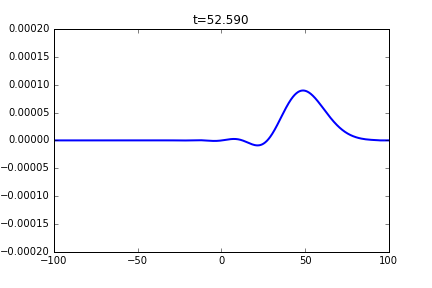
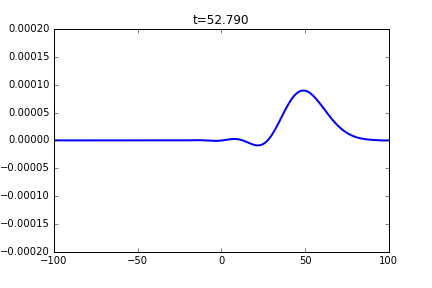
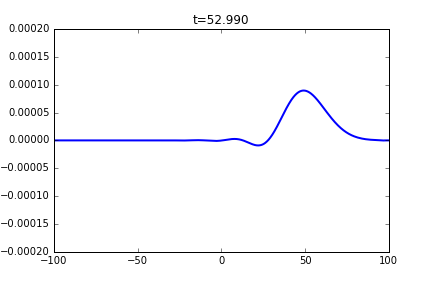
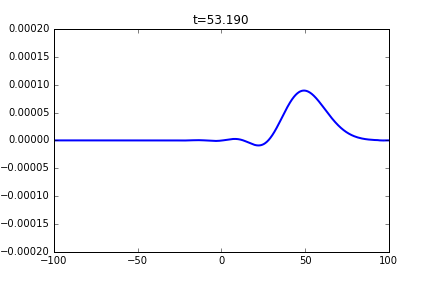
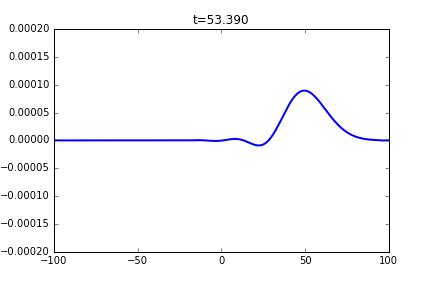
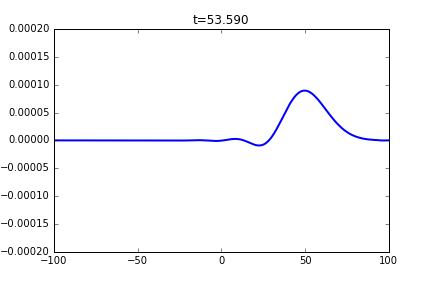
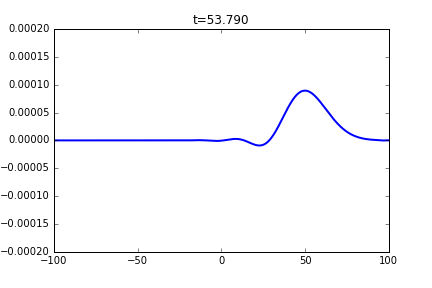
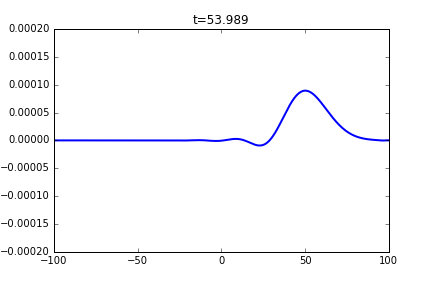
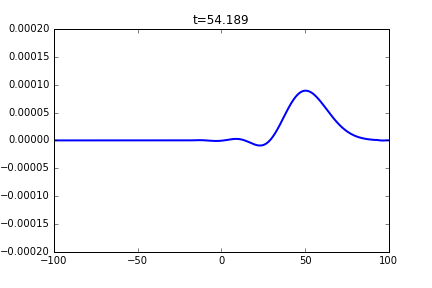
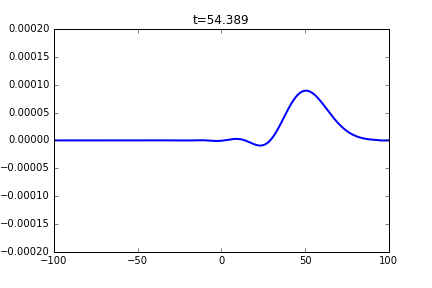
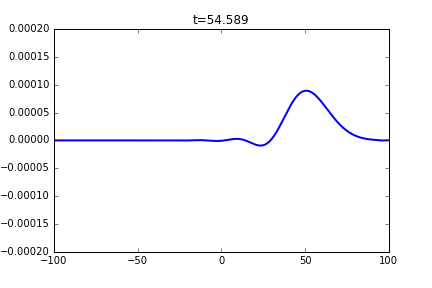
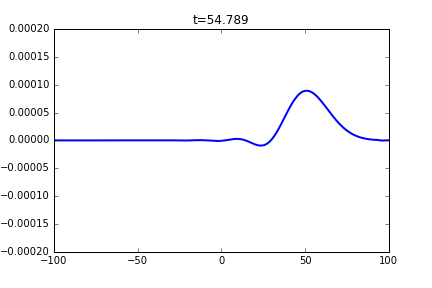
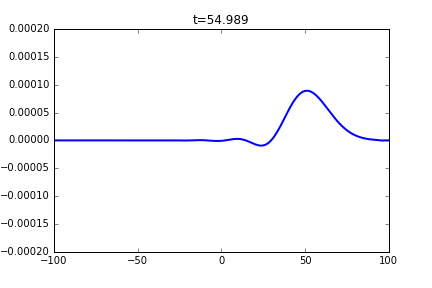
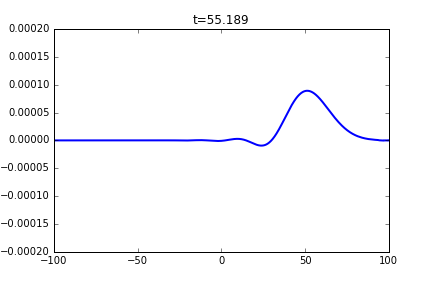
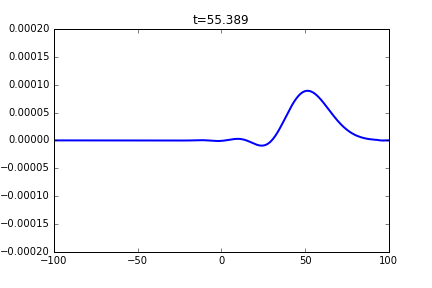
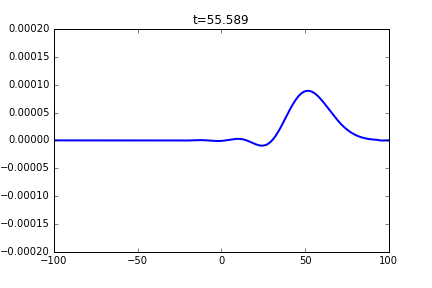
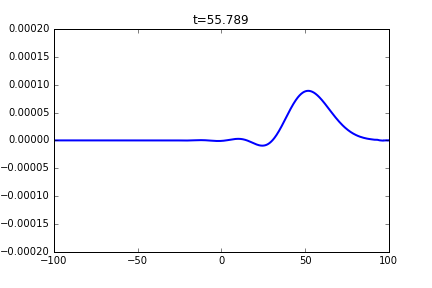
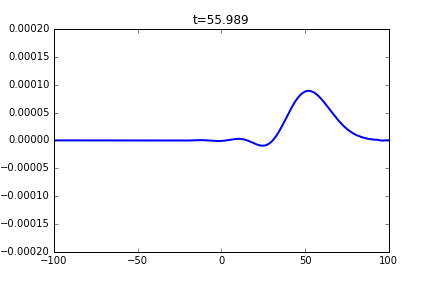
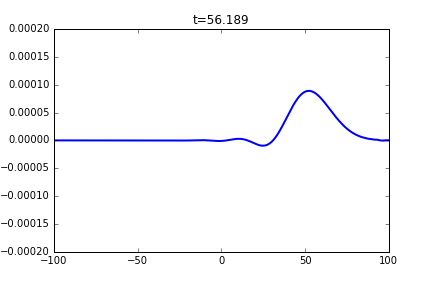
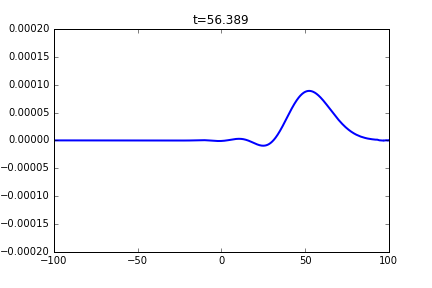
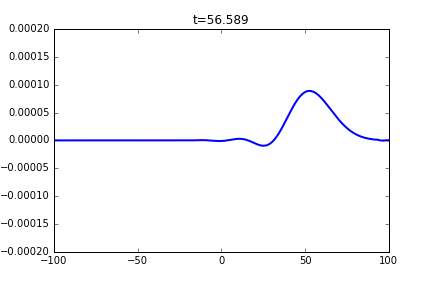
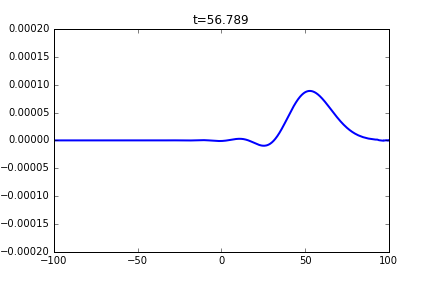
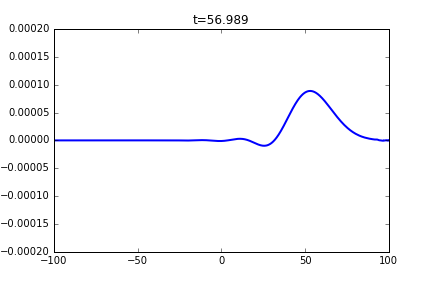
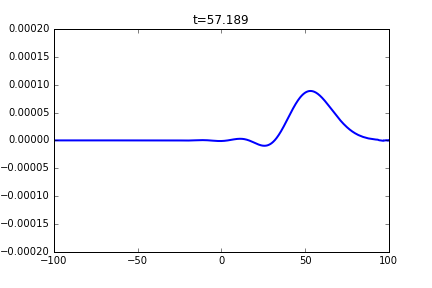
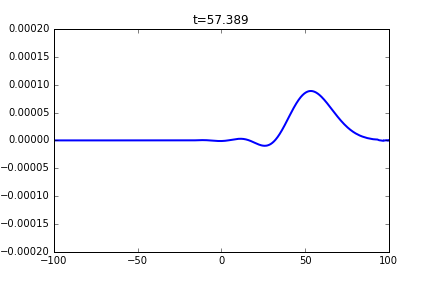
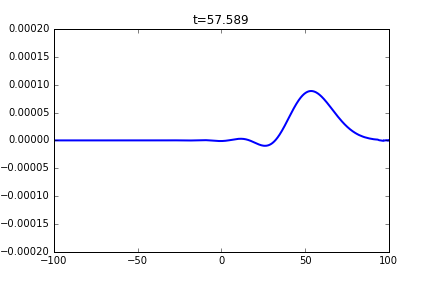
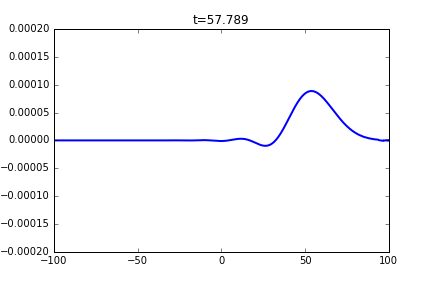
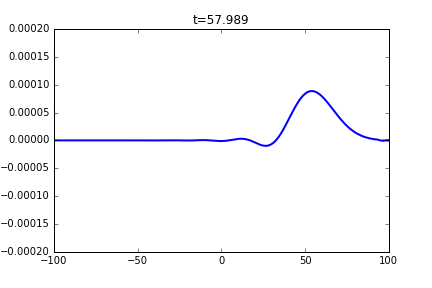
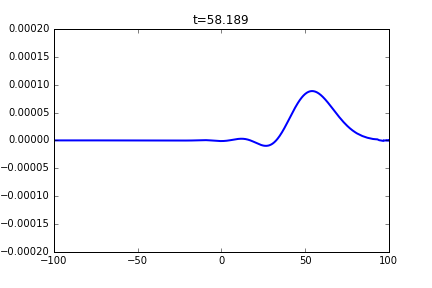
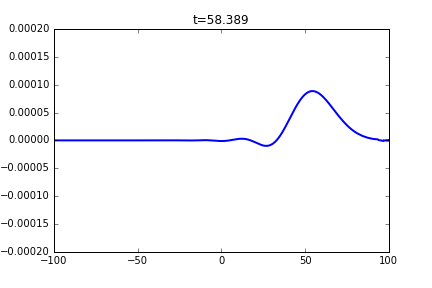
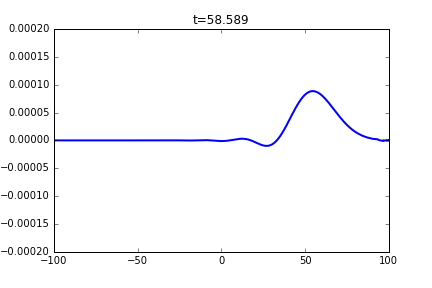
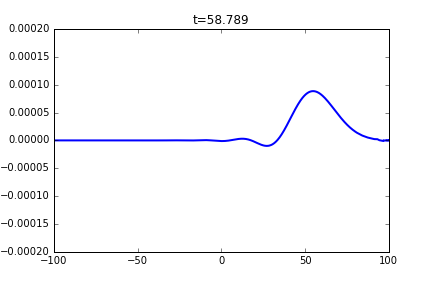
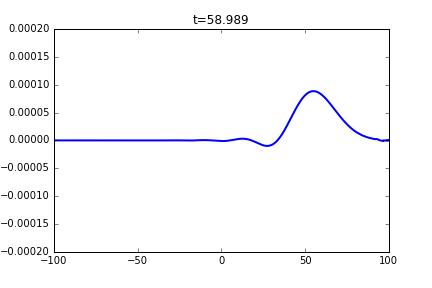
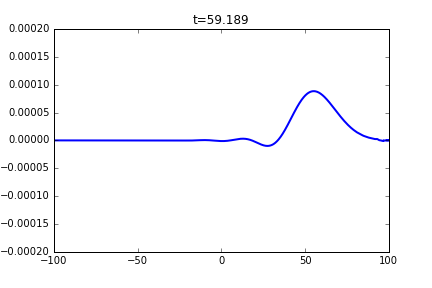
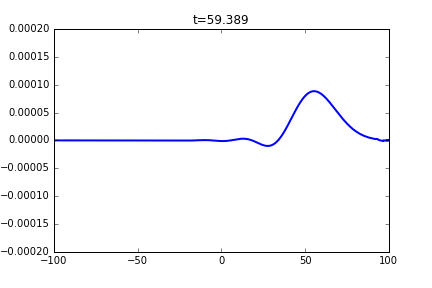
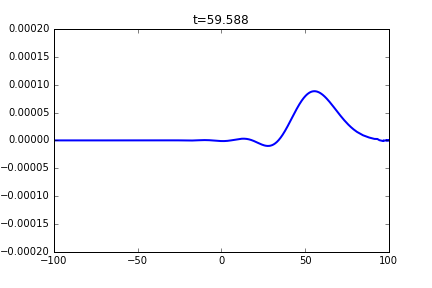
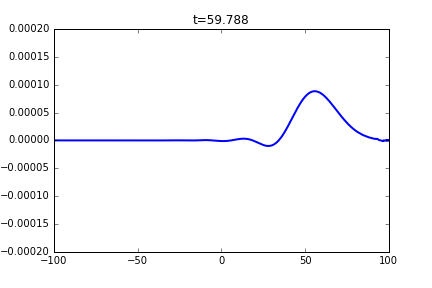
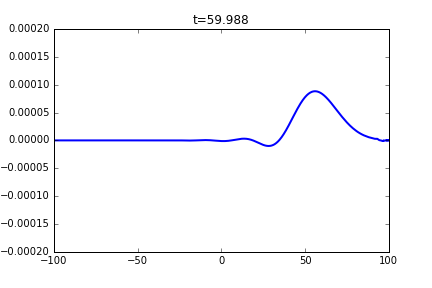
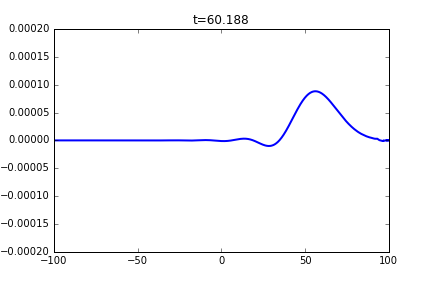
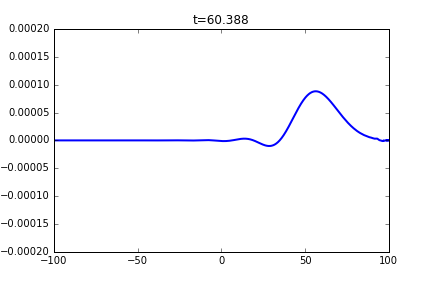
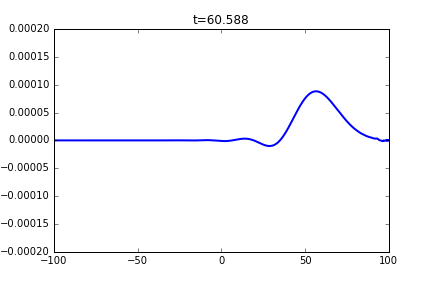
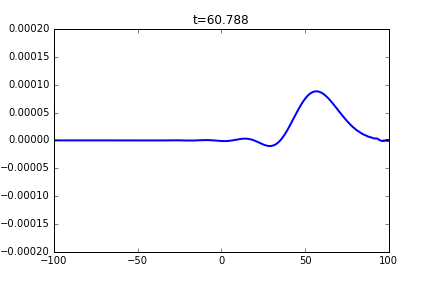
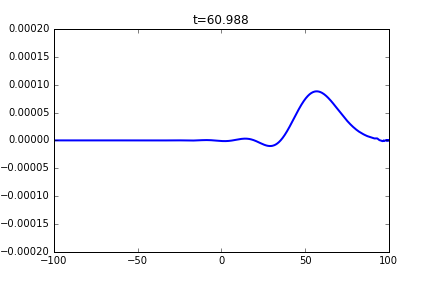
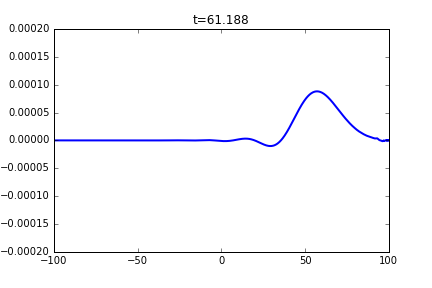
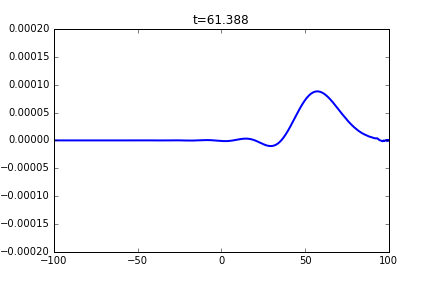
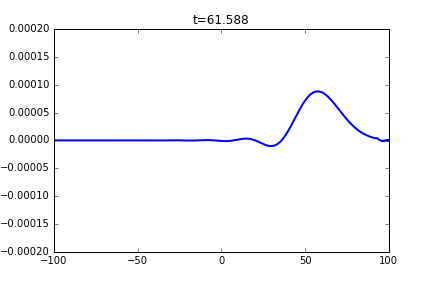
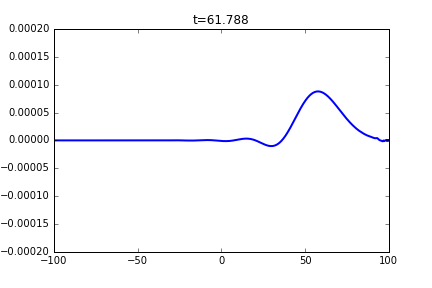
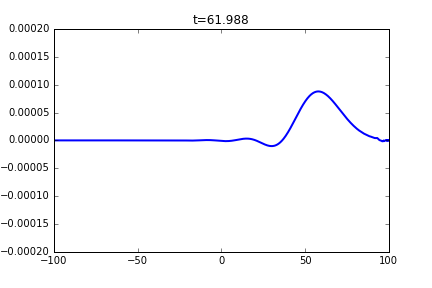
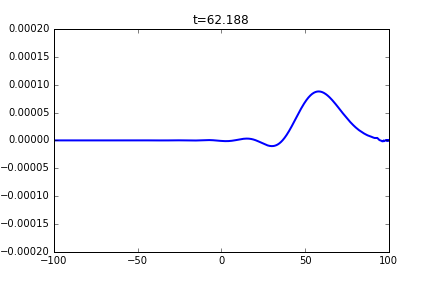
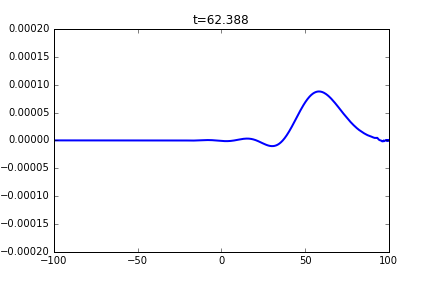
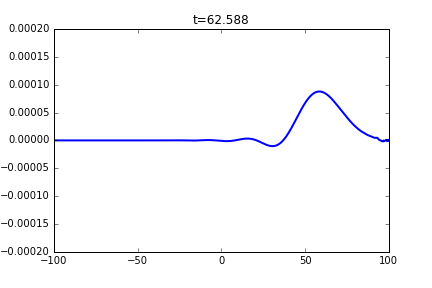
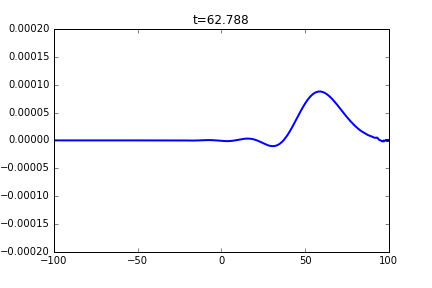
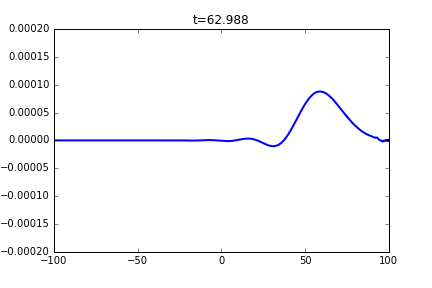
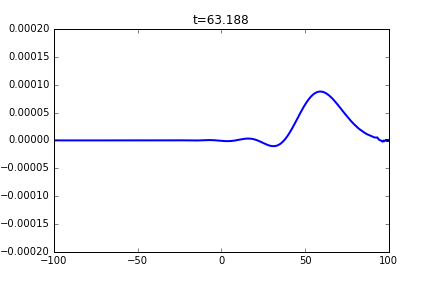
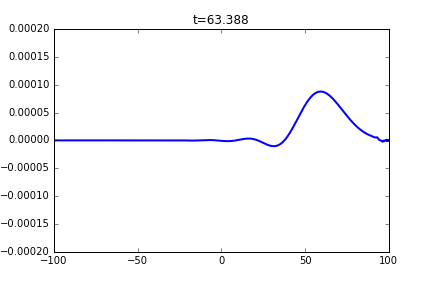
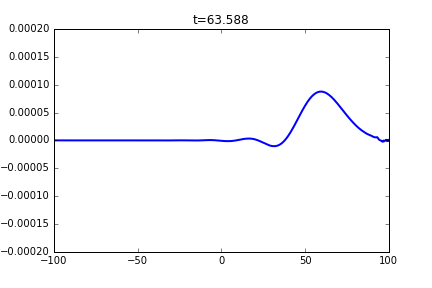
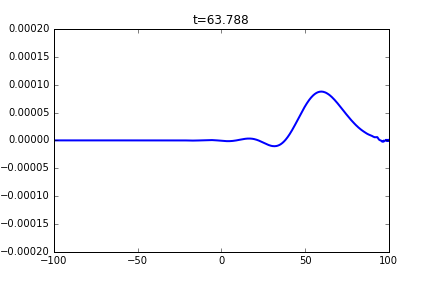
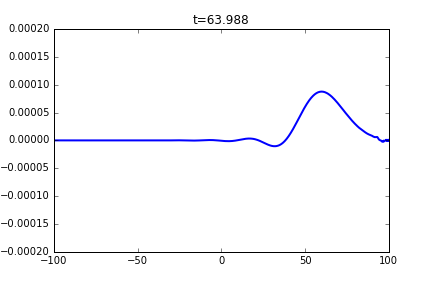
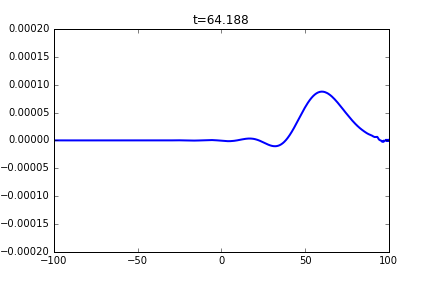
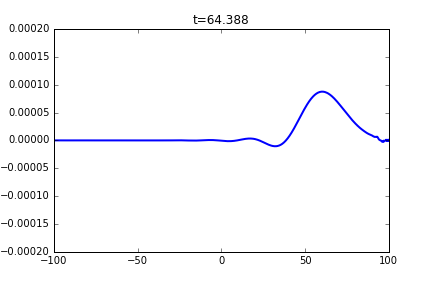
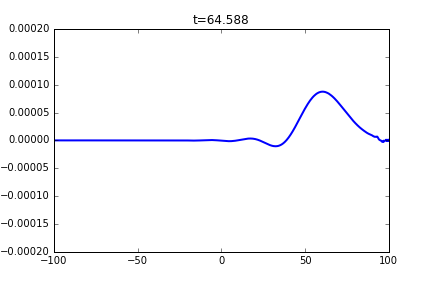
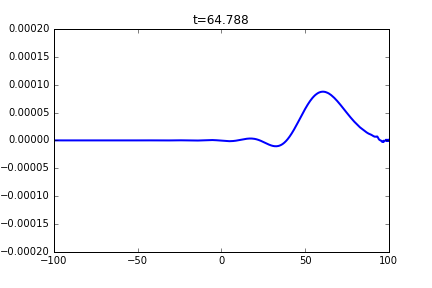
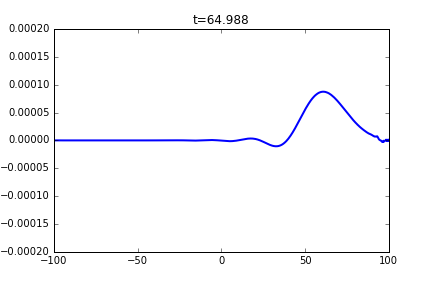
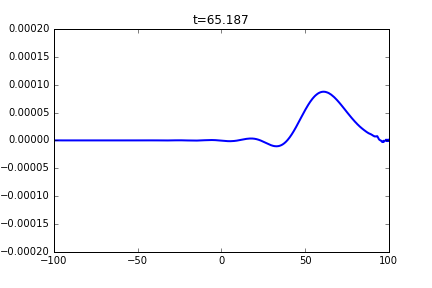
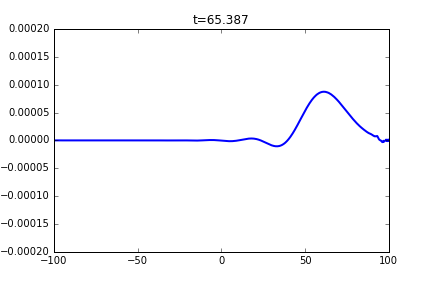
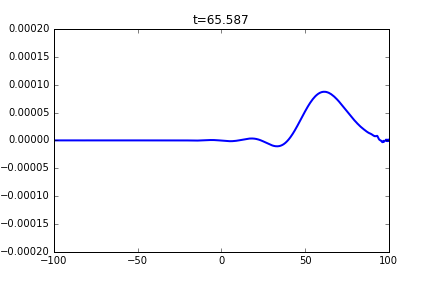
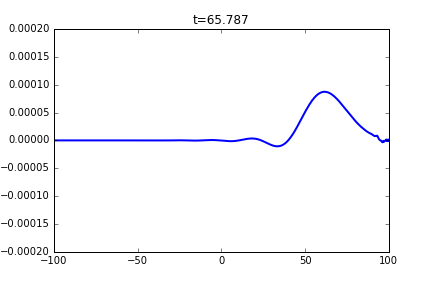
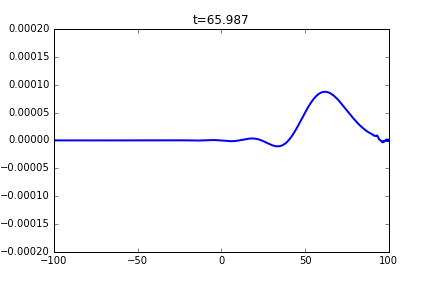
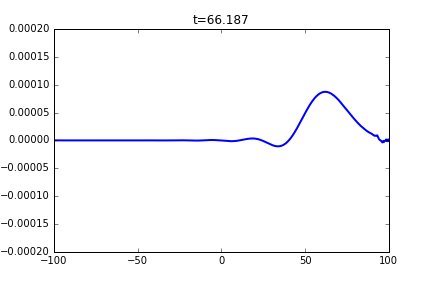
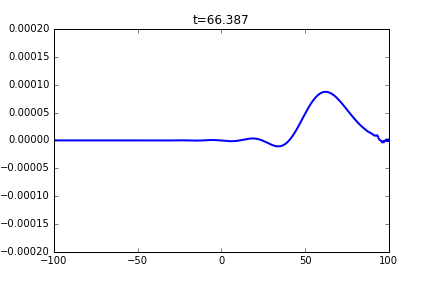
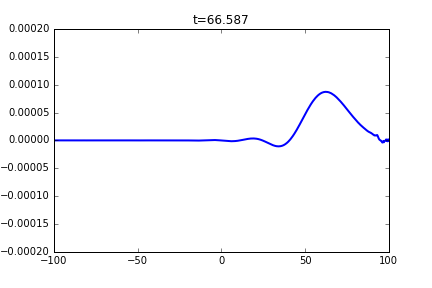
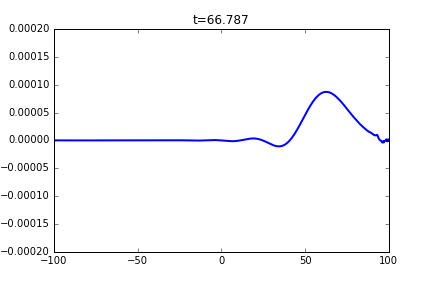
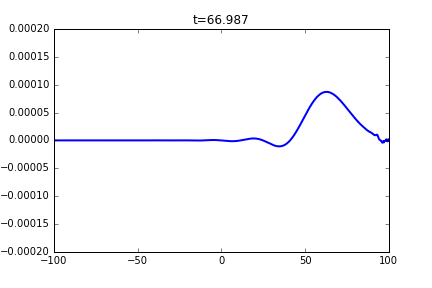
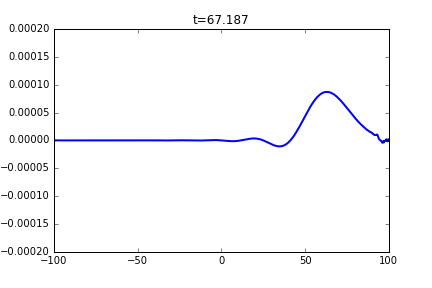
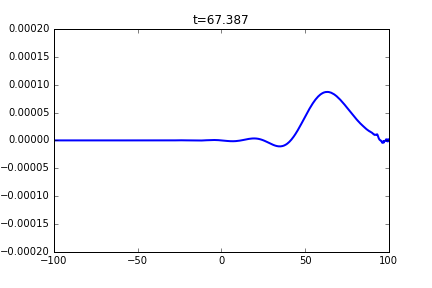
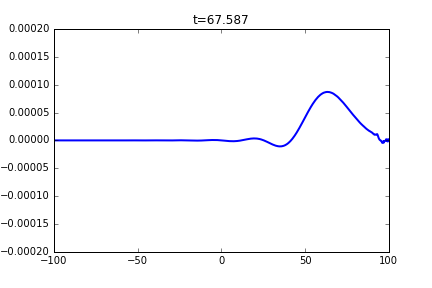
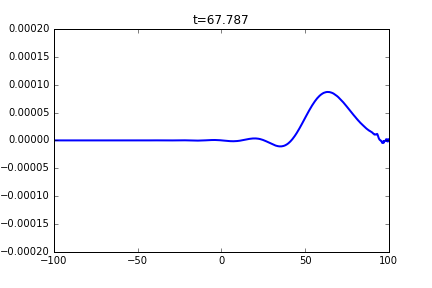
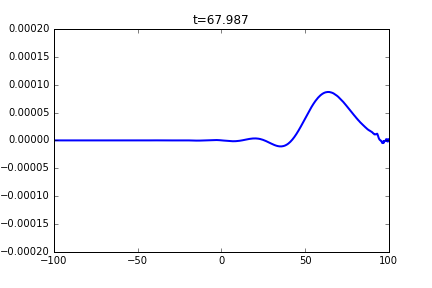
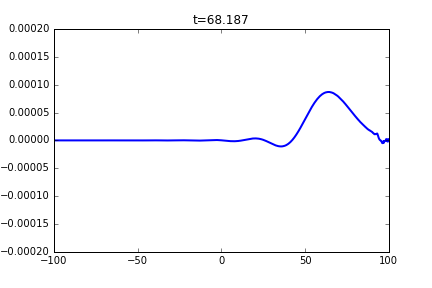
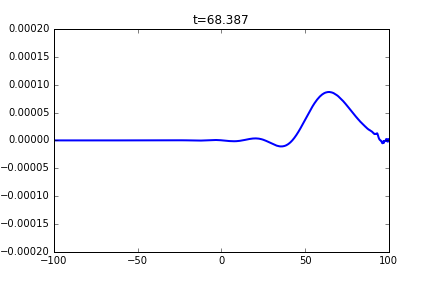
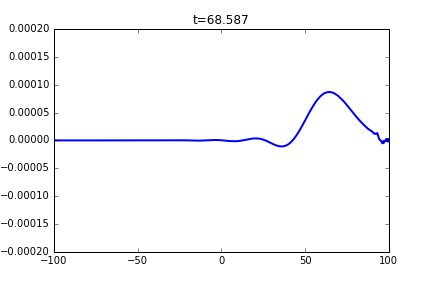
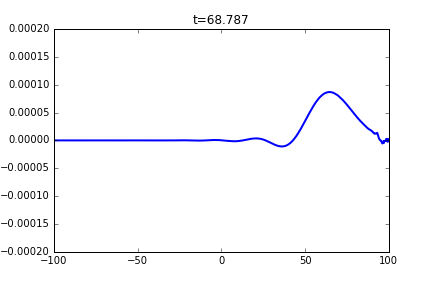
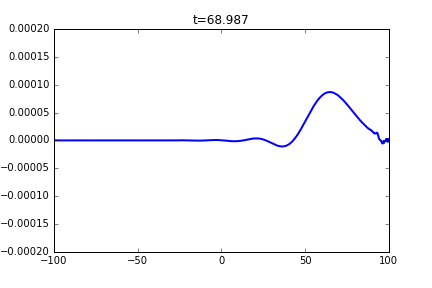
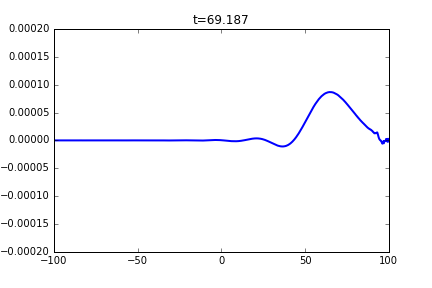
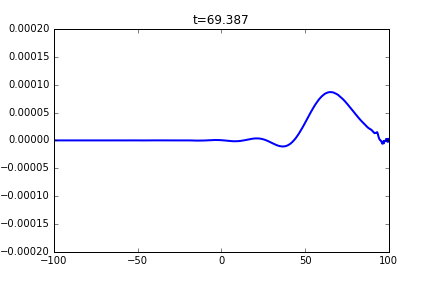
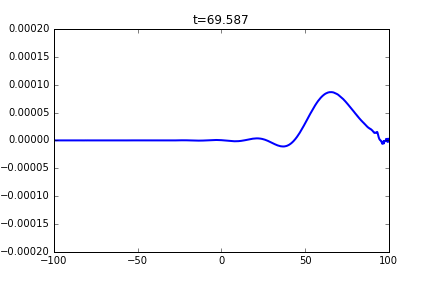
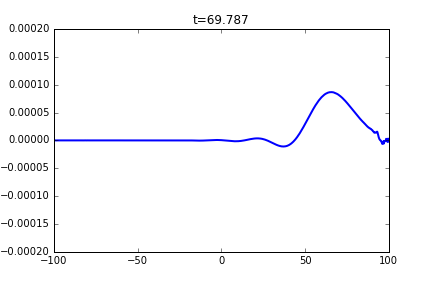
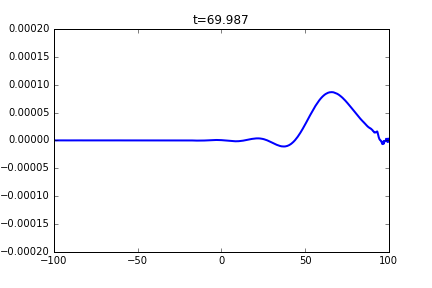
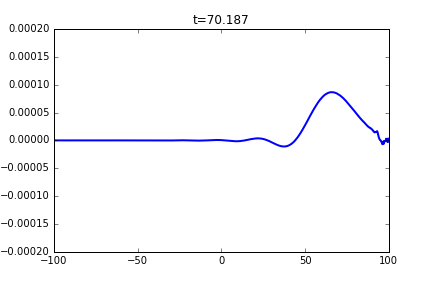
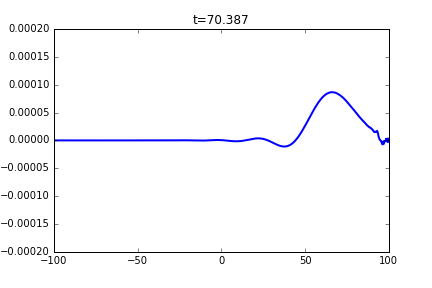
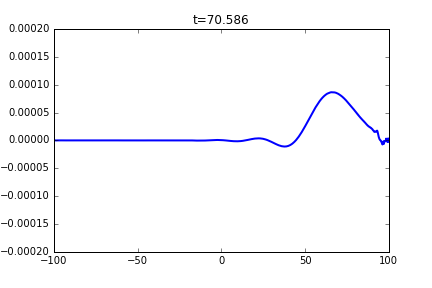
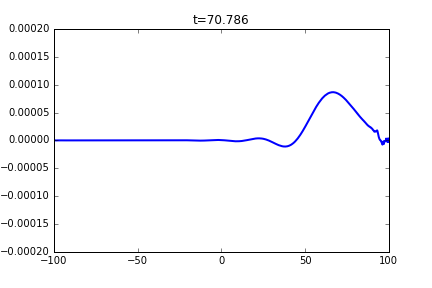
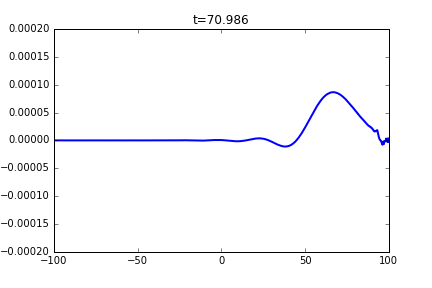
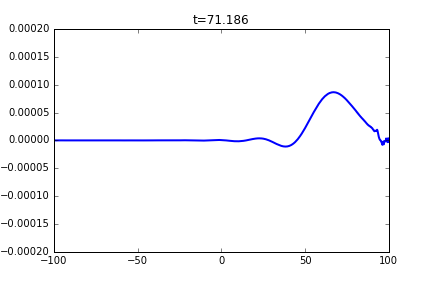
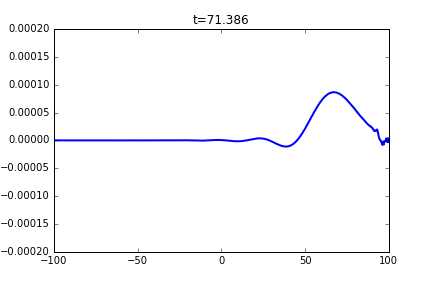
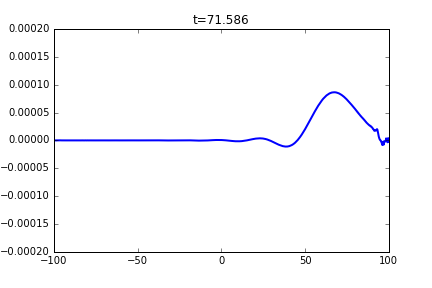
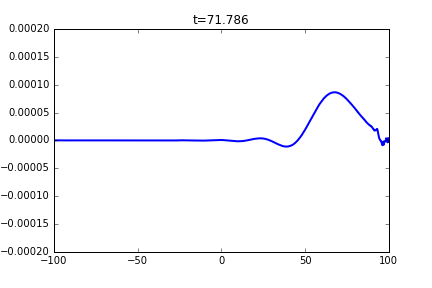
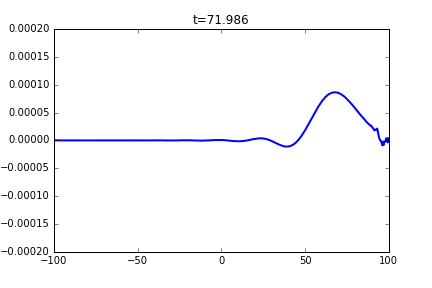
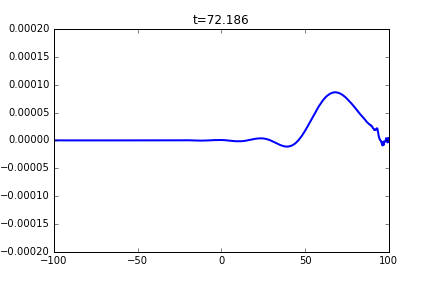
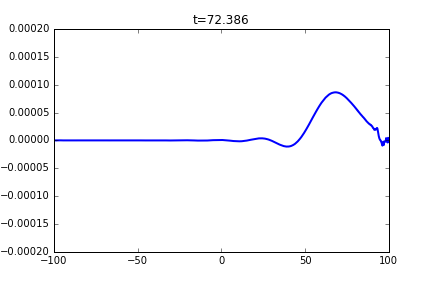
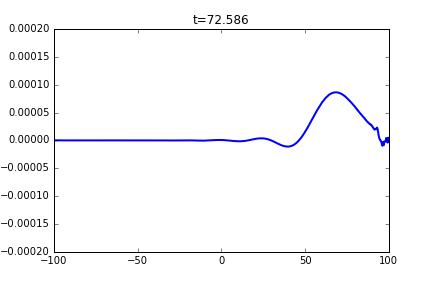
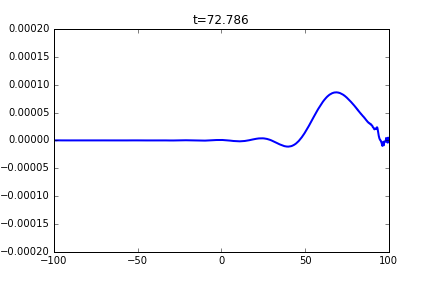
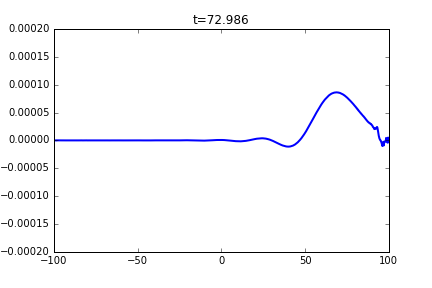
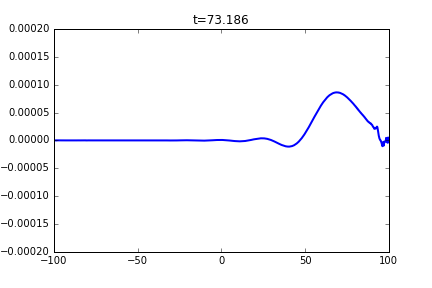
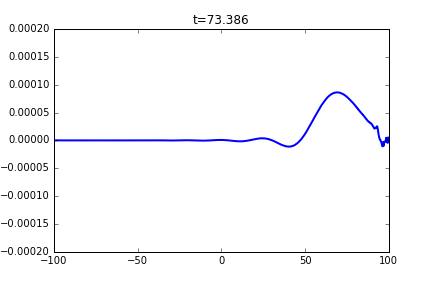
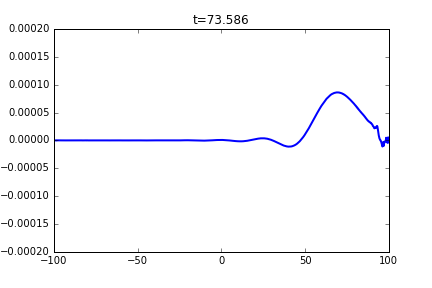
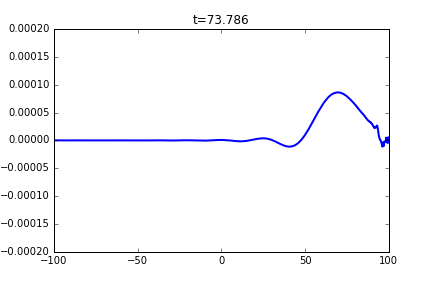
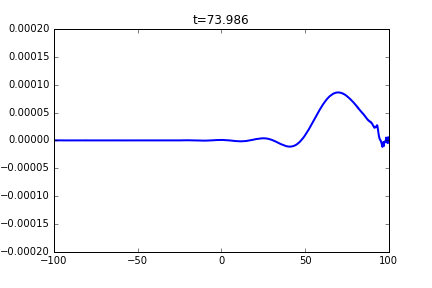
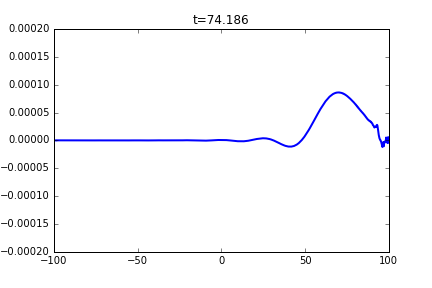
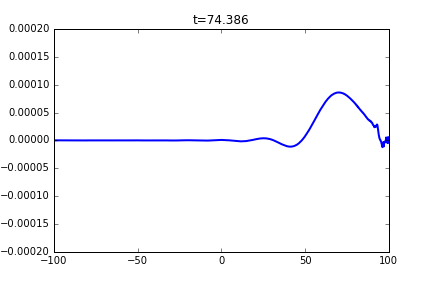
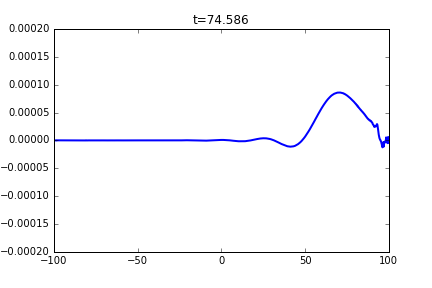
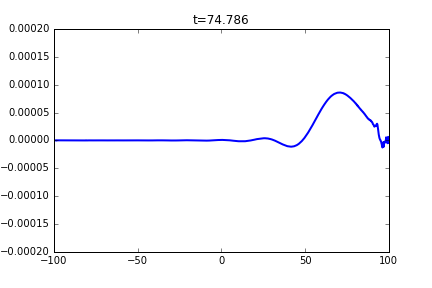
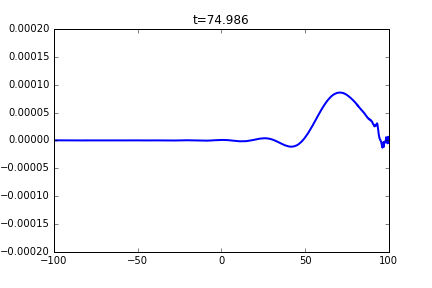
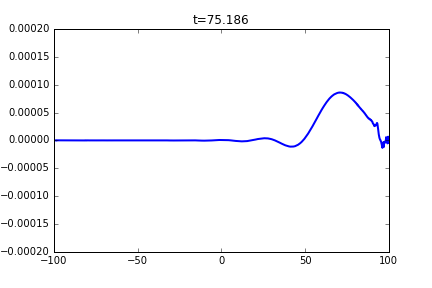
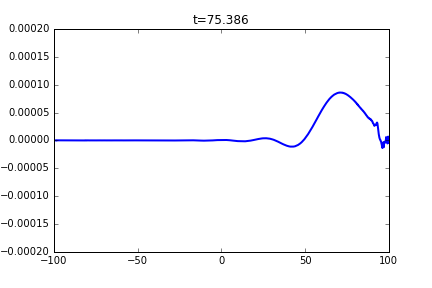
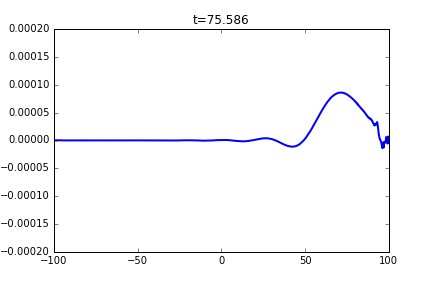
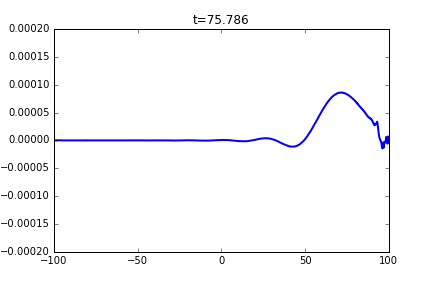
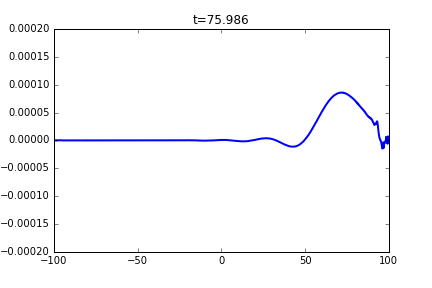
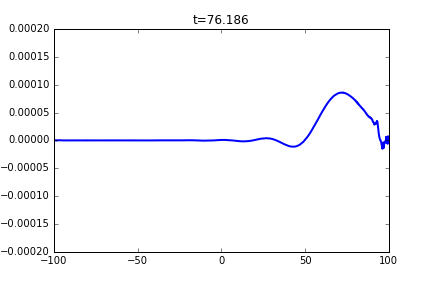
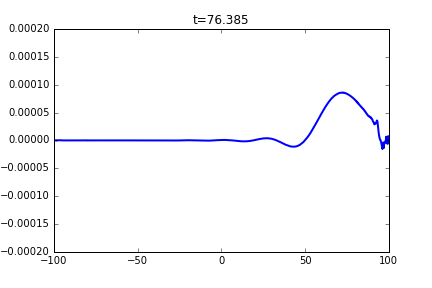
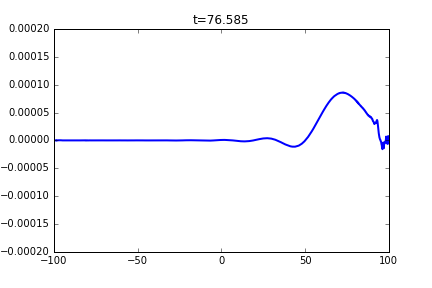
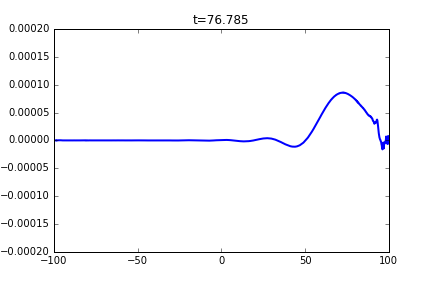
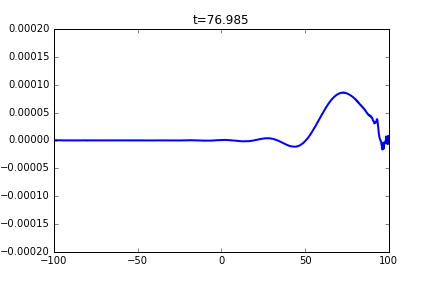
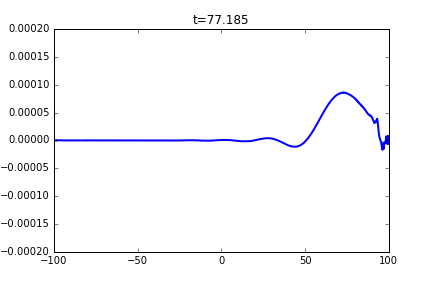
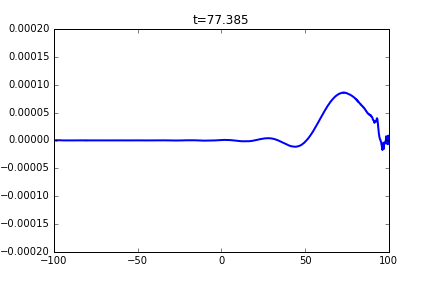
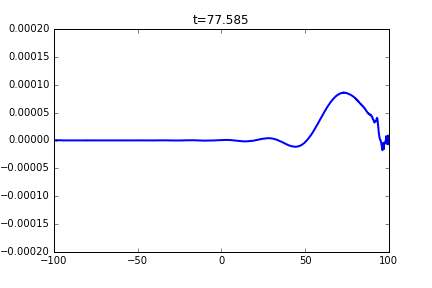
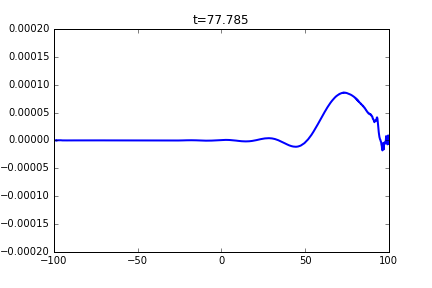
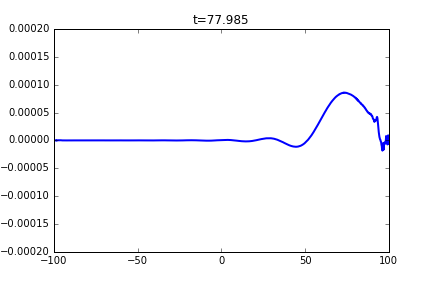
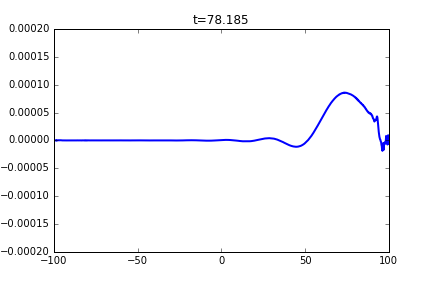
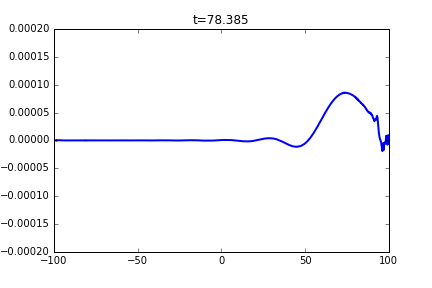
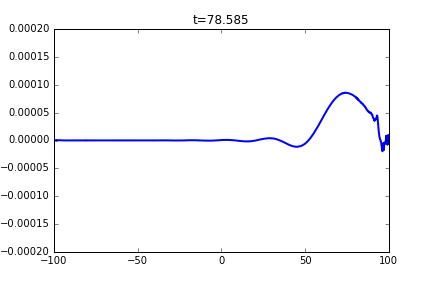
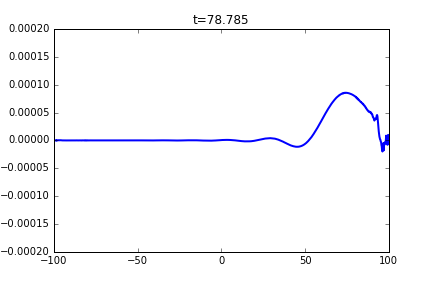
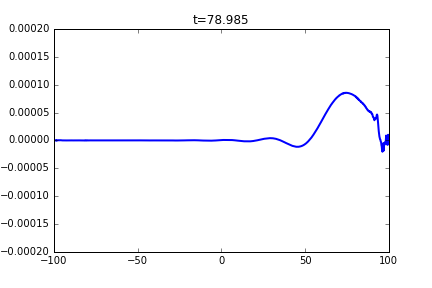
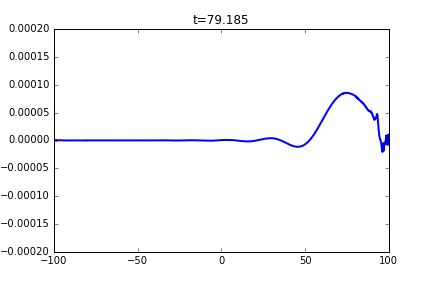
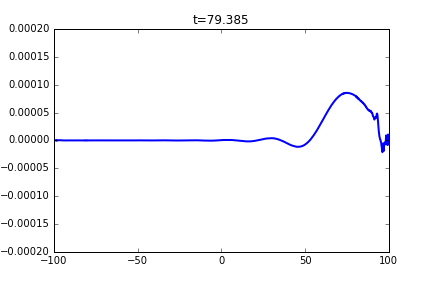
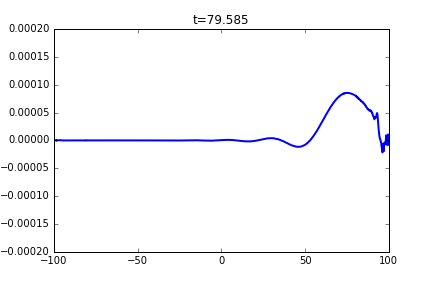
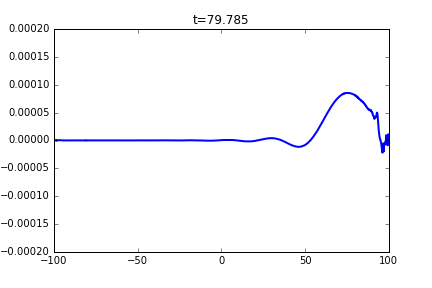
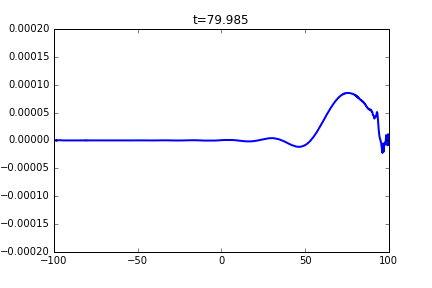
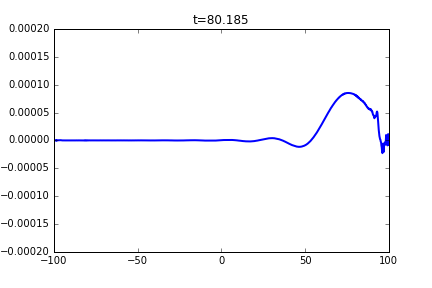
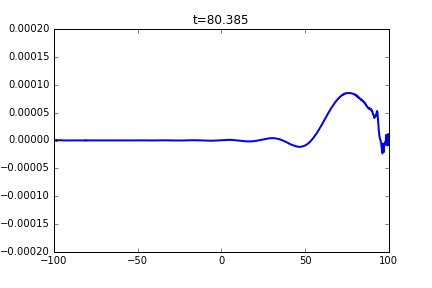
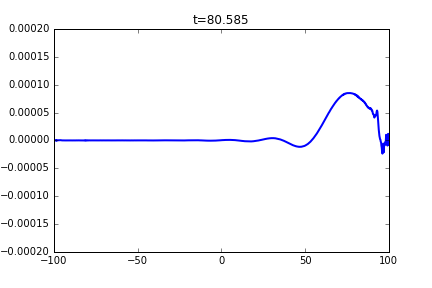
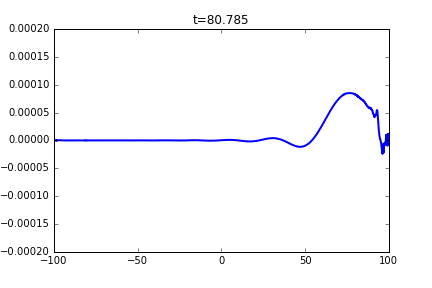
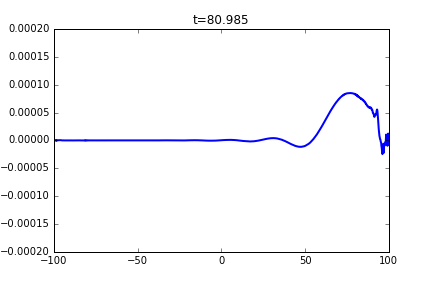
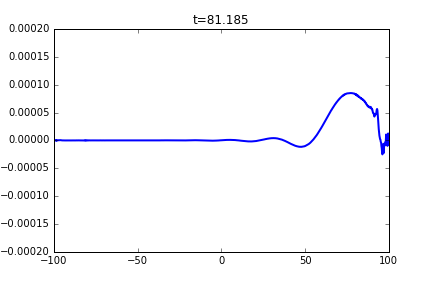
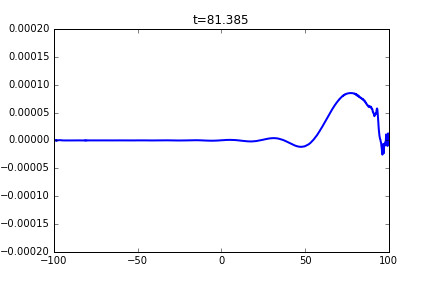
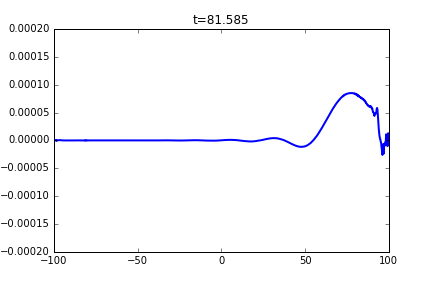
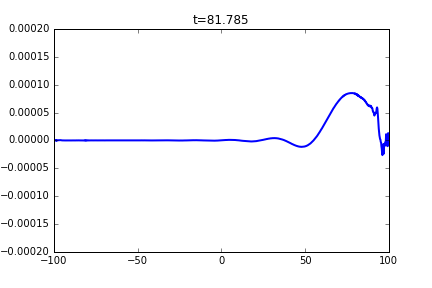
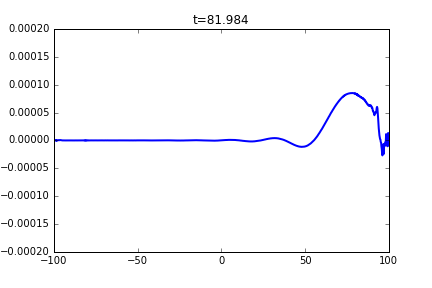
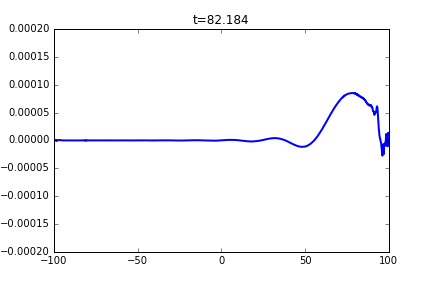
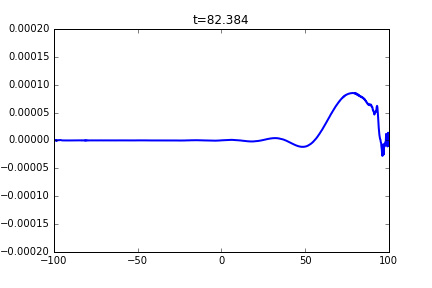
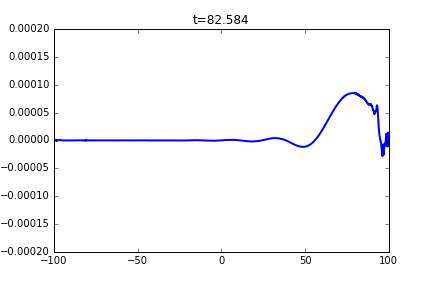
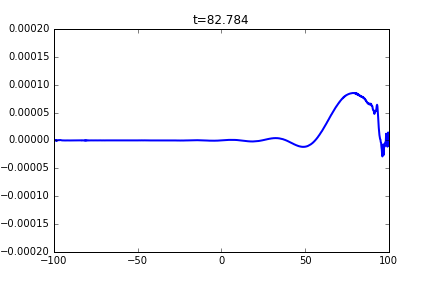
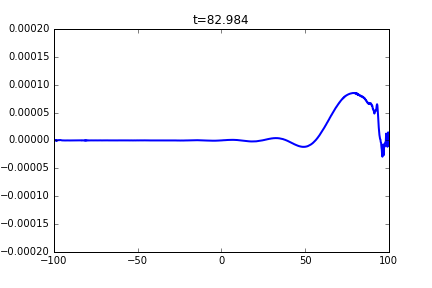
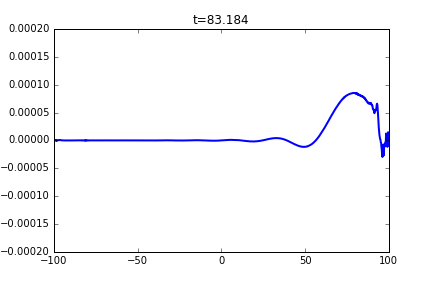
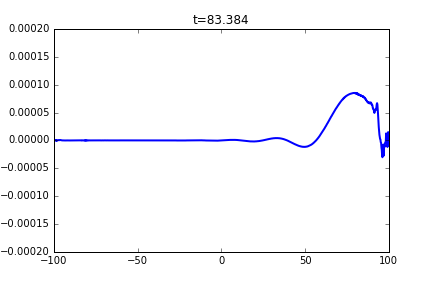
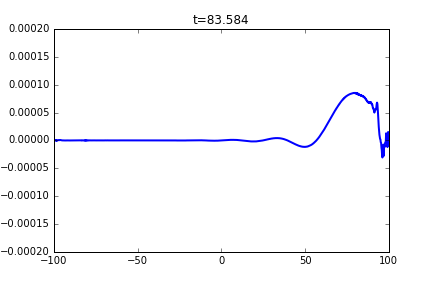
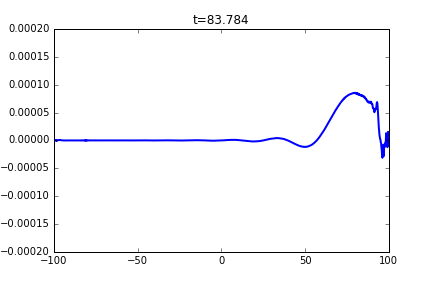
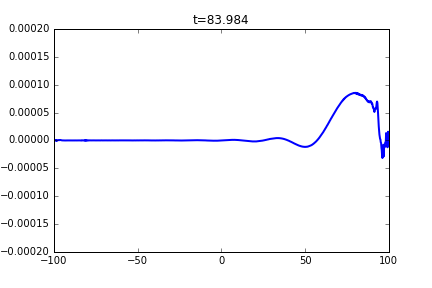
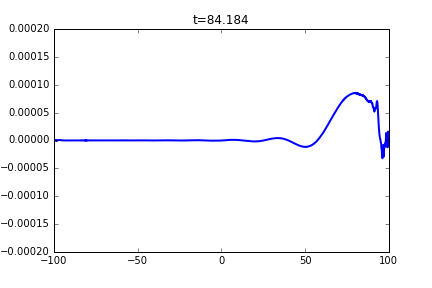
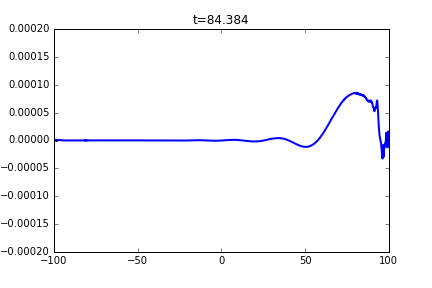
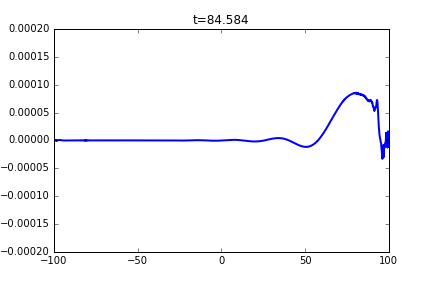
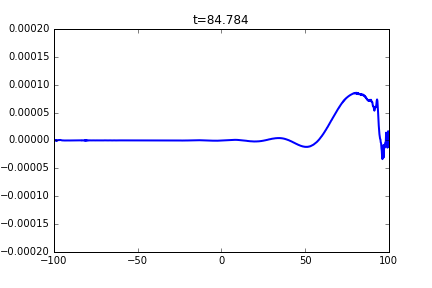
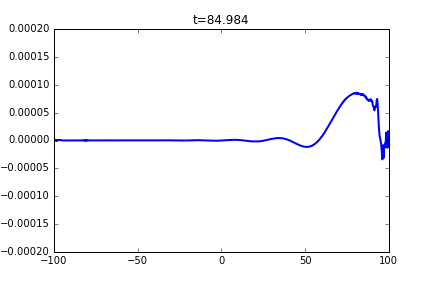
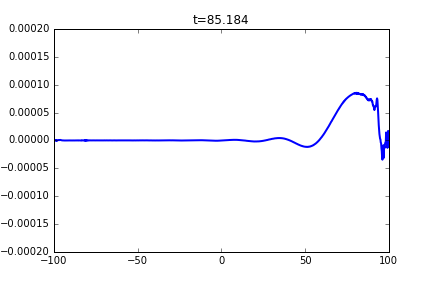
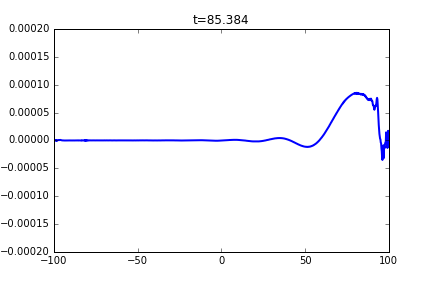
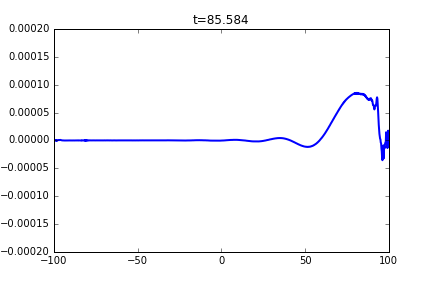
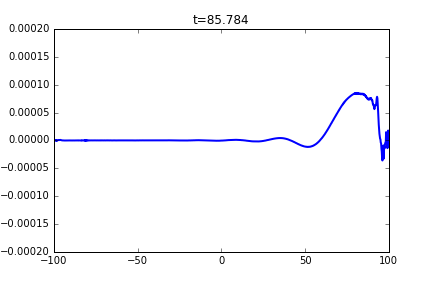
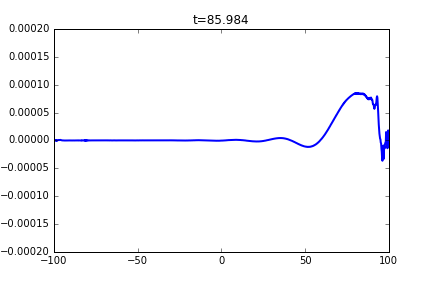
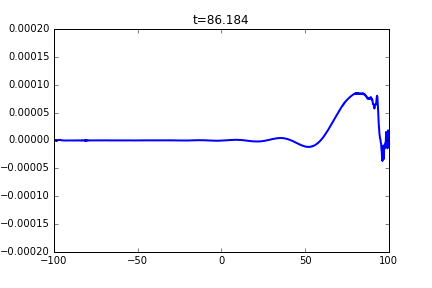
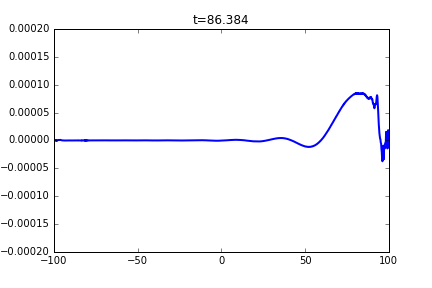
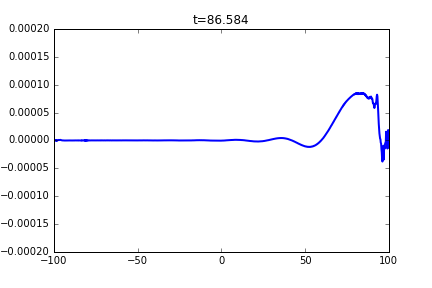
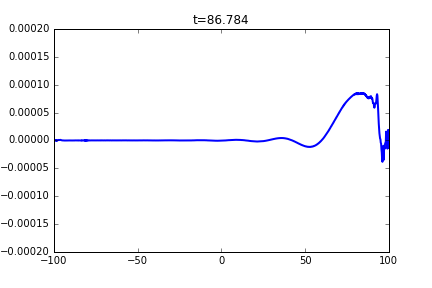
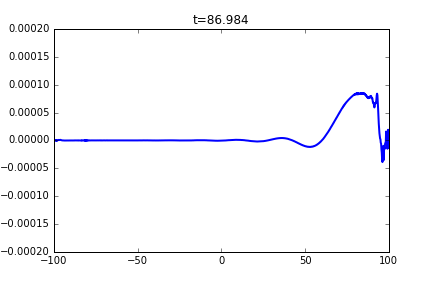
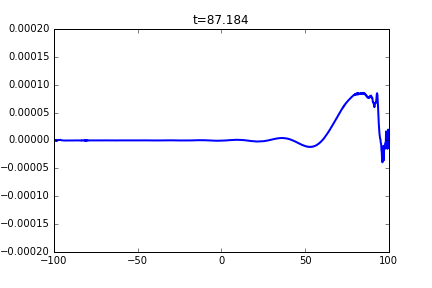
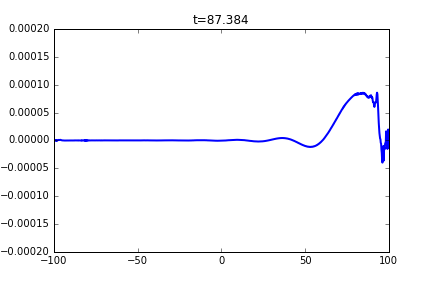
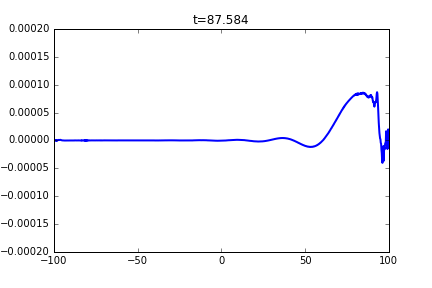
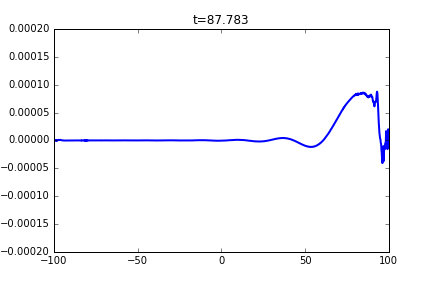
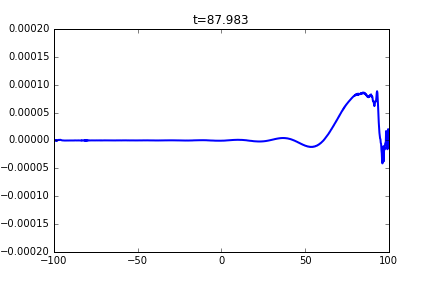
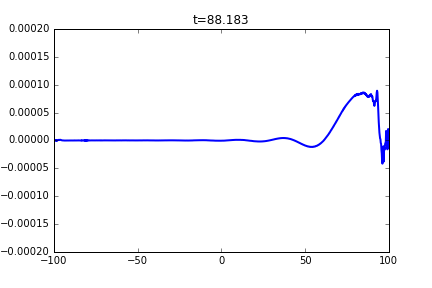
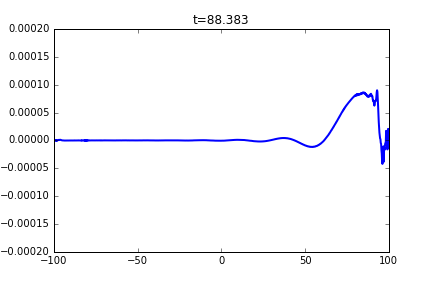
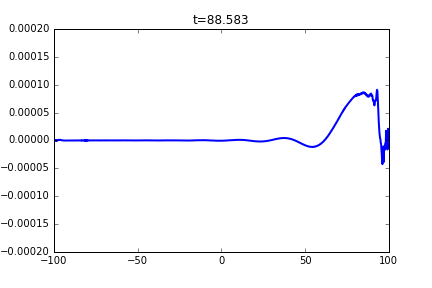
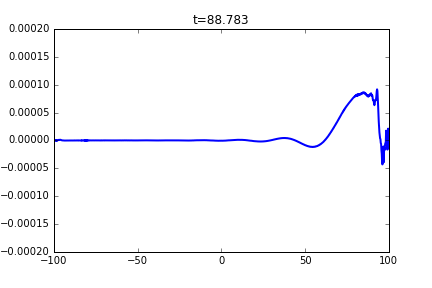
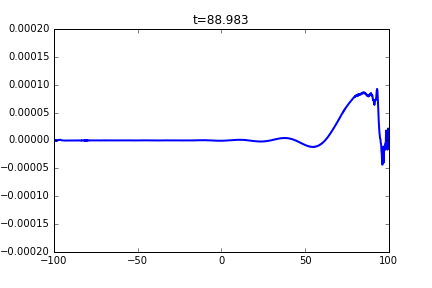
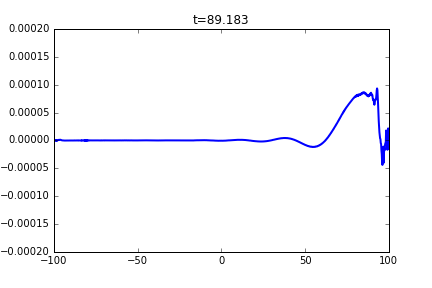
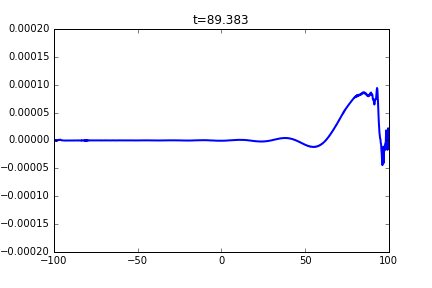
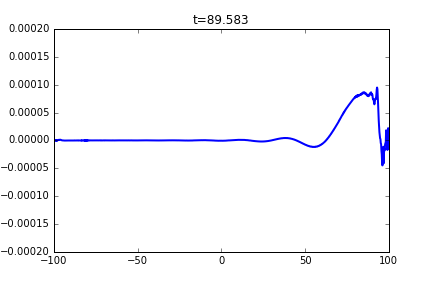
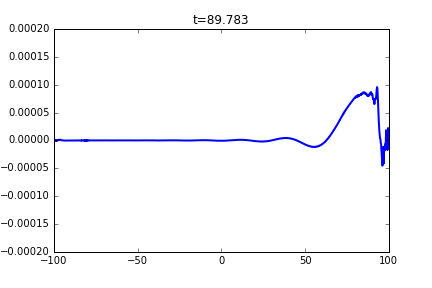
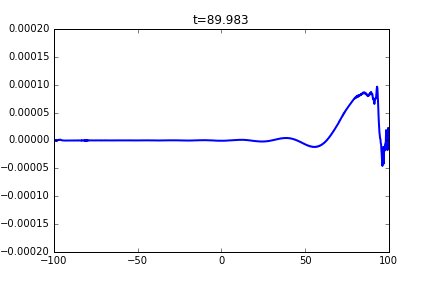
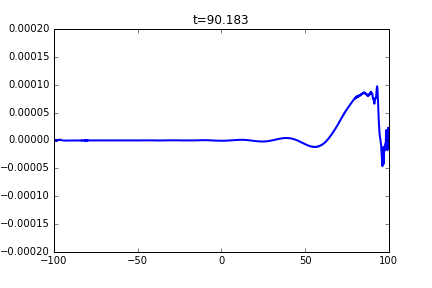
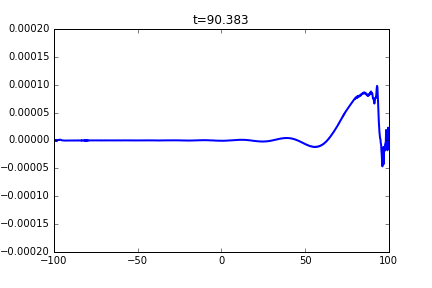
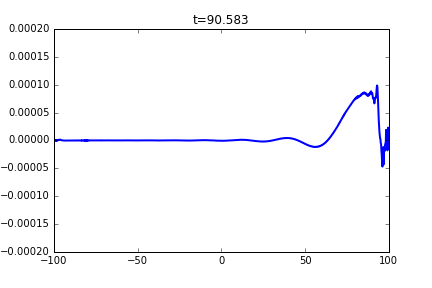
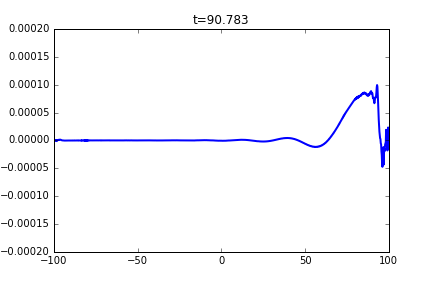
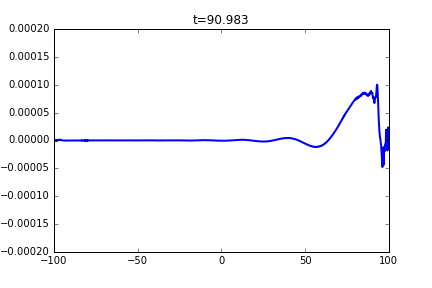
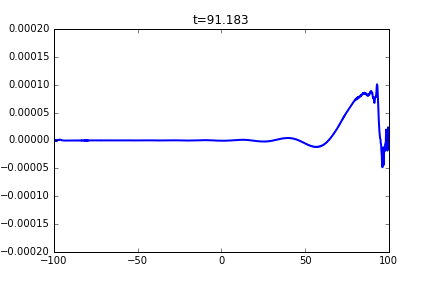
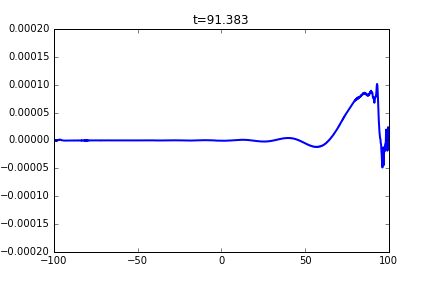
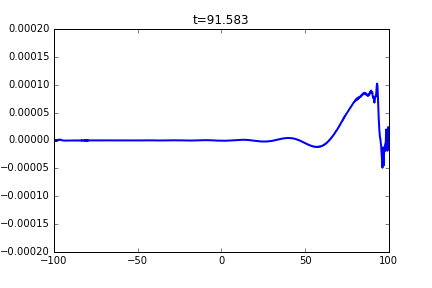
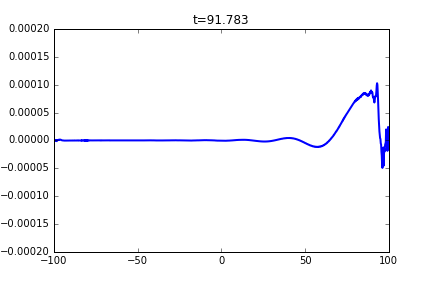
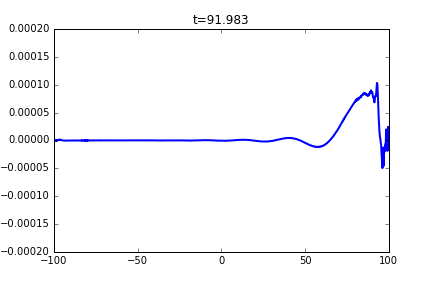
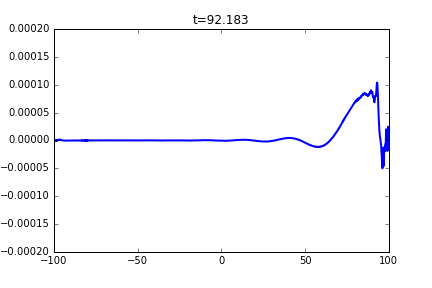
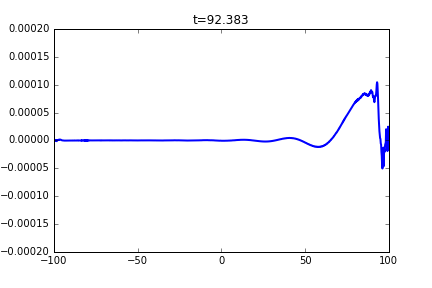
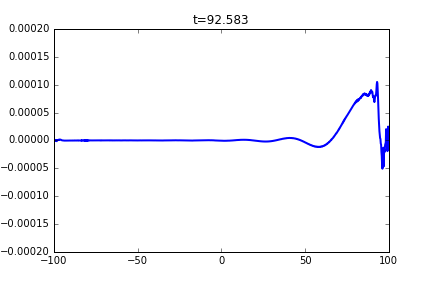
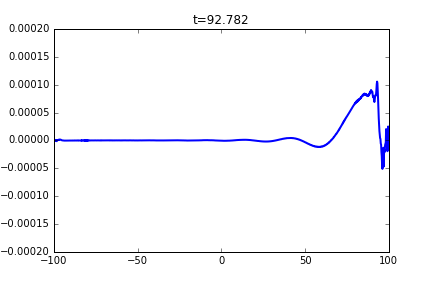
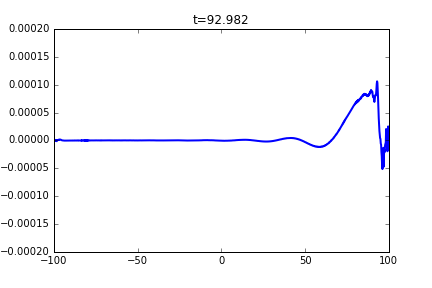
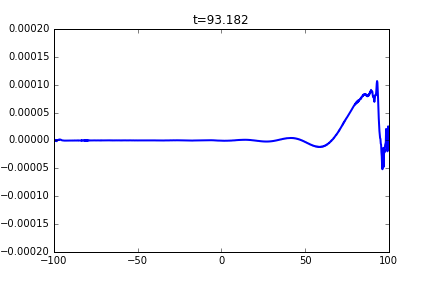
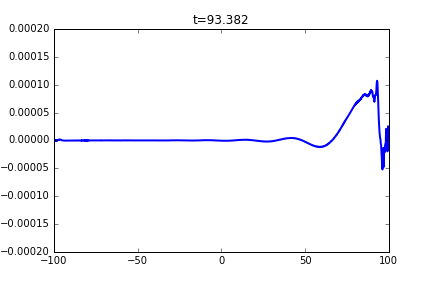
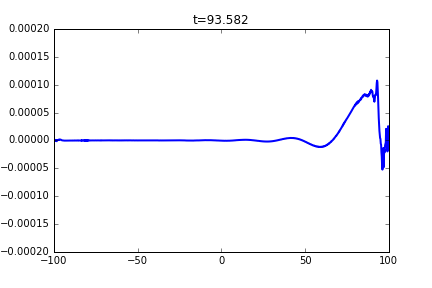
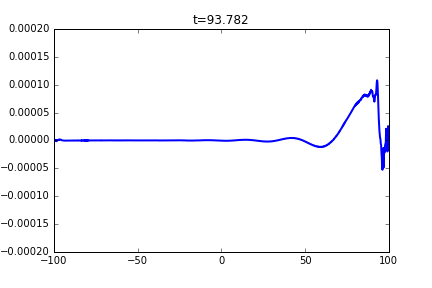
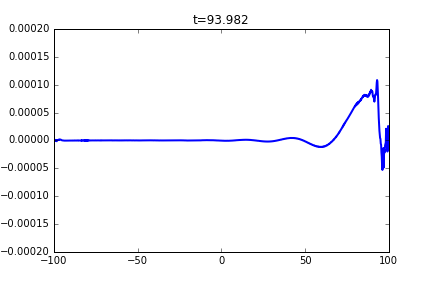
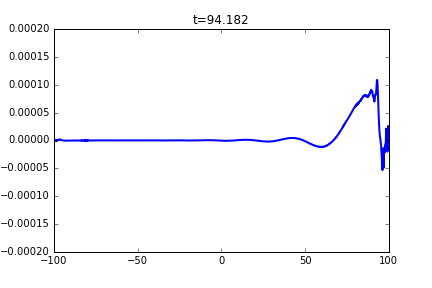
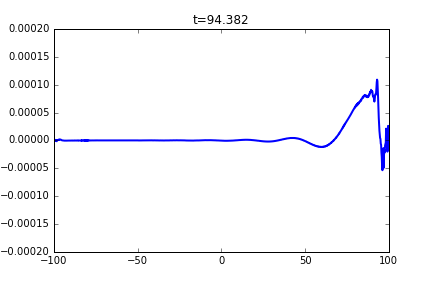
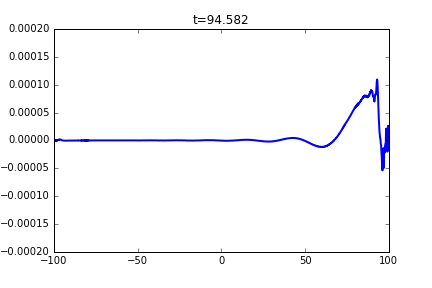
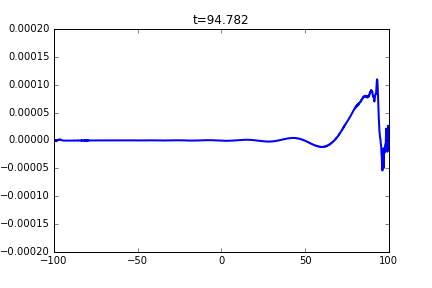
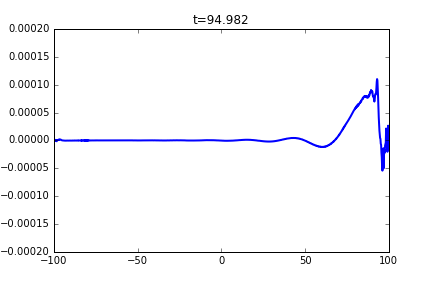
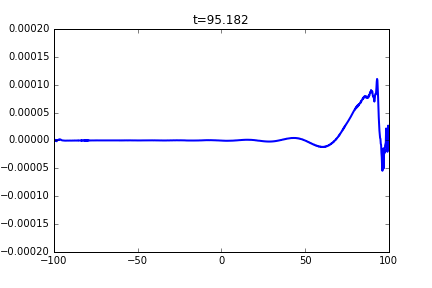
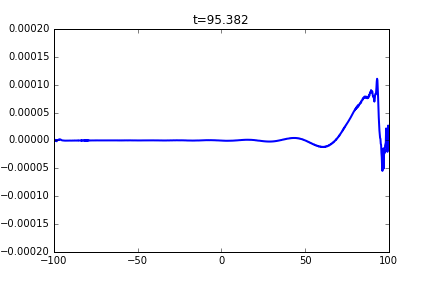
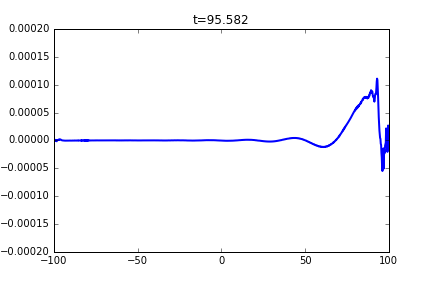
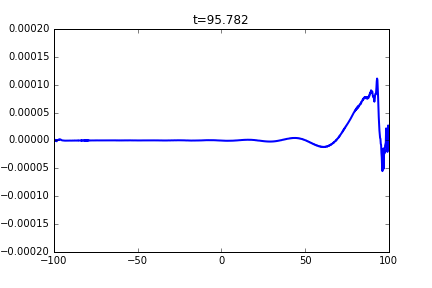
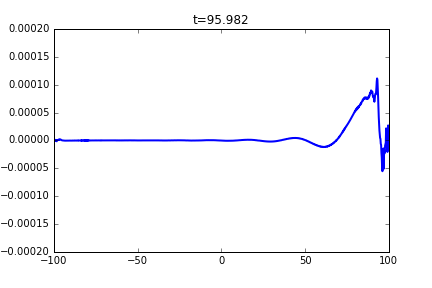
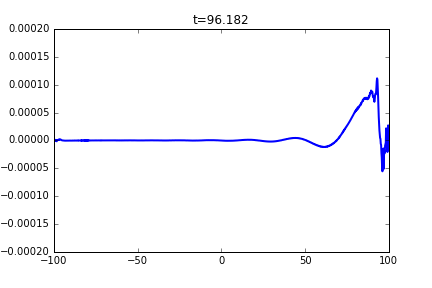
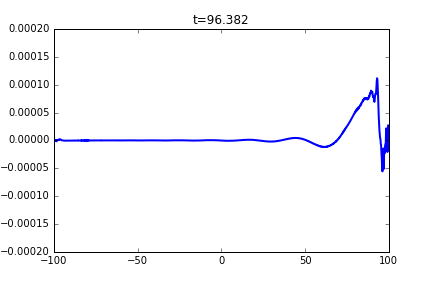
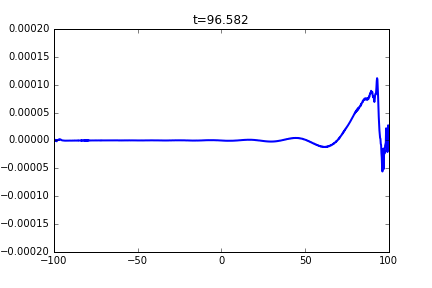
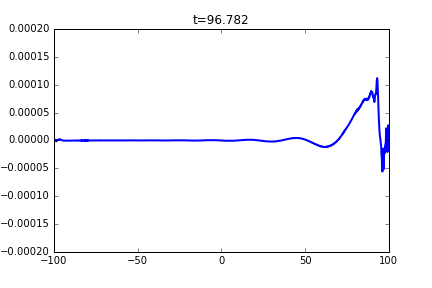
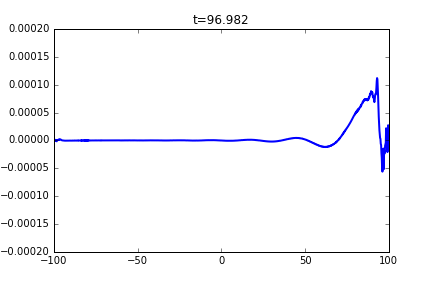
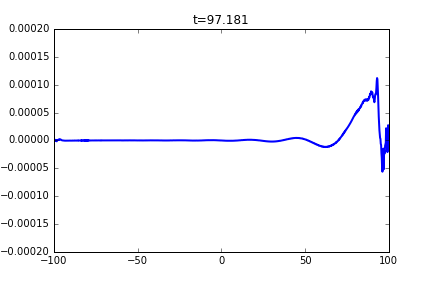
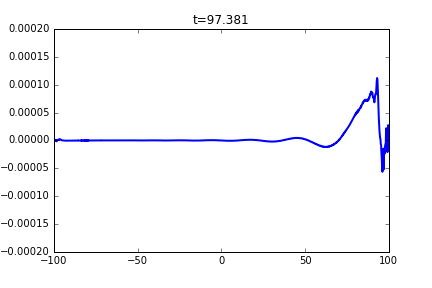
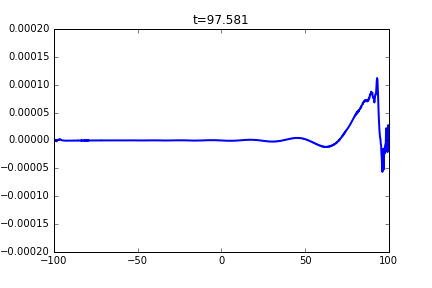
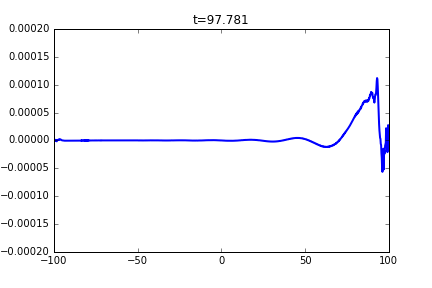
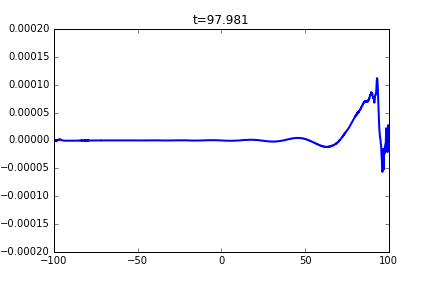
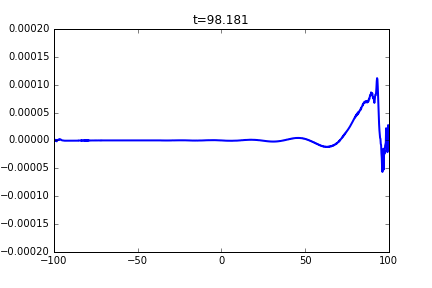
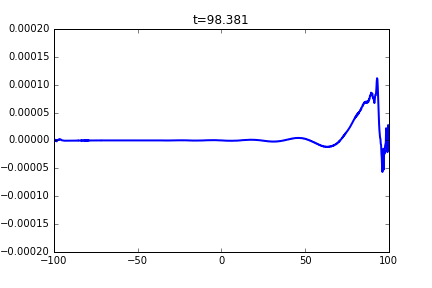
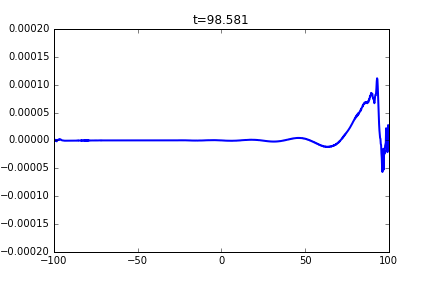
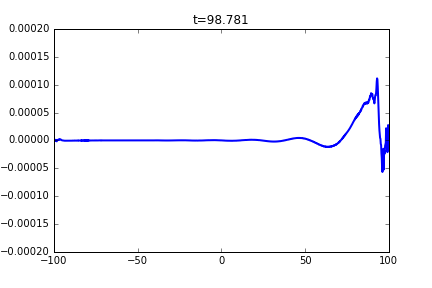
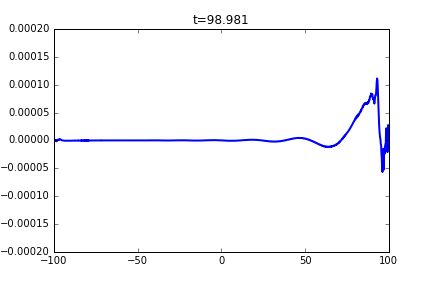
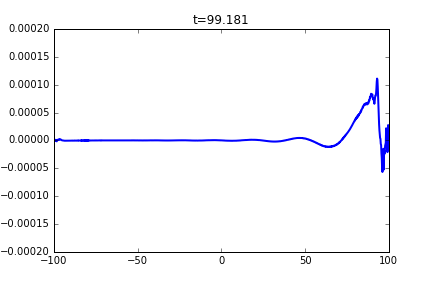
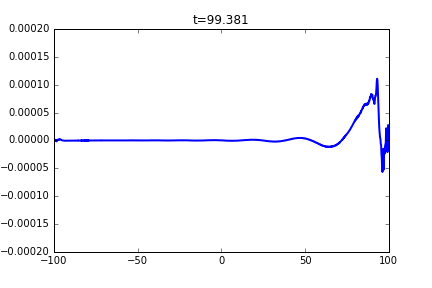
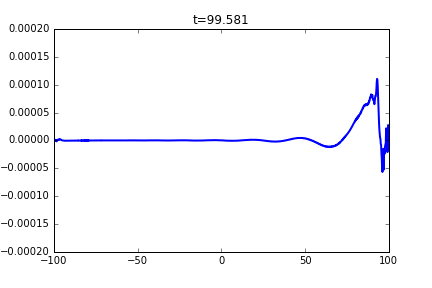
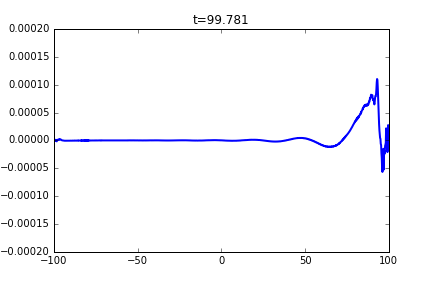
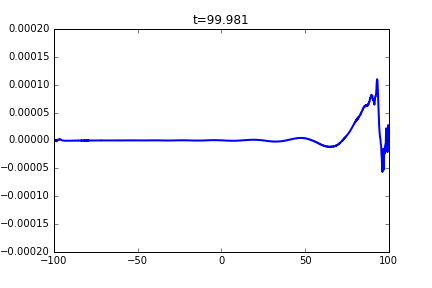
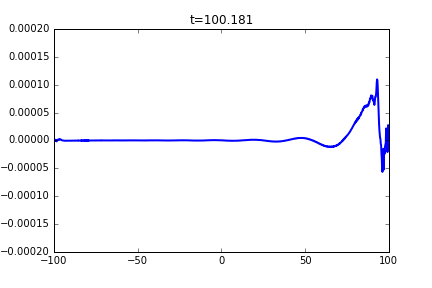

In [14]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, xmax), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    title.set_text('t=%.3f'%(tall[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=300)

In [ ]:
### Wave 4    A 1 wvl 1
eps = 0.001
B = 0.1
A = 10.
wvl = 1.
h0min = 1.5*A/eps
h0max = B*wvl/(2.*np.pi)
h0 = 0.5*(h0min+h0max)
alpha2 = h0*h0/6.

L = 5.*wvl
xmin = -L
xmax = L
N = 1000
dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)


print(r'*** Wave 4 ***')
print(r'Amplitude : %f' %A)
print(r'Wavelength : %f' %wvl)
print(r'1/(2.*Wavelength^2) : %f' %(1./(2.*wvl*wvl)))
print(r'h0min : %f' %h0min)
print(r'h0max : %f' %h0max)
print(r'eps : %f' %eps)
print(r'B : %f' %B)
print(r'alpha^2 : %f' %alpha2)
print(r'Space steps : %d' %x.size)

In [ ]:
u = np.zeros_like(x)
#u = np.where( (x>=-.5*wvl)*(x<=.5*wvl), A, u)   #### Square wave not valid!!!!
u = A*np.exp(-(x-0.)**2/(2.*wvl*wvl))
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=.01,a=1,b=1,periodic=0)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, xmax), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    title.set_text('t=%.3f'%(tall[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=300)

## Comparison of domains

### First case

In [ ]:
L = .5
L0 = L
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)
x0 = x
Nw = x.size

A = .001
wvl = .1
h0 = 10
eps = 3./2.*A/h0
B = 2.*np.pi/wvl*h0*np.sqrt(eps)
print(r'eps = %f' %eps)
print(r'B = %f' %B)

u = np.zeros_like(x)
u = A*np.exp(-(x-0.)**2/(wvl*wvl))
u1, t1 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

u1w = u1

### Second case

In [ ]:
L = 50
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)

u = np.zeros_like(x)
u = A*np.exp(-(x-0.)**2/(wvl*wvl))
u2, t2 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

center = u2.shape[0]/2
u2w = u2[center-Nw/2:center+Nw/2+1,:]

### Third case

In [ ]:
L = 100
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)

u = np.zeros_like(x)
u = A*np.exp(-(x-0.)**2/(wvl*wvl))
u3, t3 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

center = u3.shape[0]/2
u3w = u3[center-Nw/2:center+Nw/2+1,:]
print (u1w.shape, u2w.shape, u3w.shape)

### Plot (all cases)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(8,4))
ax = plt.axes(xlim=(-L0, L0), ylim=(-2*A, 2*A))
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')
fig.legend((line1, line2, line3),(r'$L=10.$',r'$L=50.0$',r'$L=100.0$'),loc=0)
# def init():
#     line1.set_data([], [])
#     line2.set_data([], [])
#     return line1,line2

def animate(i):
    i1 = np.where(t1<=t3[i])[0][-1]
    i2 = np.where(t2<=t3[i])[0][-1]
    line1.set_data(x0, u1w[:,i1])
    line2.set_data(x0, u2w[:,i2])
    line3.set_data(x0, u3w[:,i])

    title.set_text('t1=%.3f, t2=%.3f, t3=%.3f'%(t1[i1],t2[i2], t3[i]))
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line1,line2

animation.FuncAnimation(fig, animate, frames=t3.shape[0]-1, interval=30)

### Plot (difference betwenn first and third cases)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(-L0, L0), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')

udif = u3w - u1w

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x0, udif[:,i])
    title.set_text('t=%.3f'%(t1[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=udif.shape[-1], interval=300)

In [ ]:
### TEST CHEBYSHEV (BURGERS)

import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy import interpolate as interp

%matplotlib inline


def computeF(u,A,B,di,dbi,N):
    for i in range(N+1):
        sum1 = 0
        sum2 = 0
        for n in range(1,N):
            sum1 = sum1 + A[i,n]*u[n]
            sum2 = sum2 + B[i,n]*u[n]
        F[i] = -alpha*u[i]*sum1 + nu*sum2 - alpha*u[i]*di[i] * nu*dbi[i]
    return F

def computeF2(u,uxcoef,uxxcoef):
    for i in range(N+1):
        sum1 = 0
        sum2 = 0
        for n in range(1,N):
            sum1 = sum1 + A[i,n]*u[n]
            sum2 = sum2 + B[i,n]*u[n]
        F[i] = -alpha*u[i]*sum1 + nu*sum2 - alpha*u[i]*di[i] * nu*dbi[i]
    return F



alpha = 1
nu = 0.01
N = 15
c = 0.001
dt = 0.001
a = 0.
b = 1.
lamb = 2./(b-a)

lins = np.linspace(0,N,N+1)
x = .5*((a+b) - (b-a)*np.cos((np.pi*lins)/N))
roots = (2.*x-(b+a))/(b-a)

C = np.ones(N+1)
C[0] = .5
C[N] = .5


u = 4.*x*(1.-x)
uroots = 4*roots*(1-roots)
ul = 0
ur = 0


### Polynomials on the points
T = np.diag(np.ones(N+1))
Troots = cheb.chebval(roots,T)

Txroots = np.zeros(Troots.shape)
A = np.zeros(Troots.shape)
B = np.zeros(Troots.shape)

ucoef = np.zeros(N+1)

for j in range(N+1) :
    for n in range(N+1):
        if n > 0 and n < N:
            ucoef[j] = ucoef[j] + Troots[j,n]*u[n]
        else:
            ucoef[j] = ucoef[j] + .5*Troots[j,n]*u[n]
    ucoef[j] = 2./N*ucoef[j]


    
for i in range(N+1):
    for j in range(N+1):
        for n in range(j):
            if (n+j)%2 == 1:
                Txroots[j,i] = Txroots[j,i] + C[n]*Troots[n,i]
        Txroots[j,i] = Txroots[j,i]*2.*j*lamb

ucoef2 = ucoef
uxcoef2 = cheb.chebder(ucoef2,1)
ucoef = cheb.chebfit(roots,uroots,N)
uxcoef = np.zeros(N+1)


for k in range(N):
    for p in range(k+1,N+1) :
        if (p+k)%2 == 1:
            uxcoef[k] = uxcoef[k] + p*ucoef[p]
    if (k > 0):
        uxcoef[k] = 2.*uxcoef[k]


        
for i in range(N+1):
    for n in range(N+1):
        for j in range(N+1):
            if j > 0 and j < N:
                A[i,n] = A[i,n] + Txroots[j,i]*Troots[j,n]
            else:
                A[i,n] = A[i,n] + .5*Txroots[j,i]*Troots[j,n]
        A[i,n] = A[i,n]*(2.*C[n])/N
        
        
B = np.dot(A,A)

uxcoef = cheb.chebder(ucoef,m=1)
uxxcoef = cheb.chebder(ucoef,m=2)
u2 = cheb.chebval(x,ucoef)
ux = cheb.chebval(x,uxcoef)
uxx = cheb.chebval(x,uxxcoef)
print(uxcoef,uxcoef2)

di = ul*A[:,0] + ur*A[:,N]
dbi = ul*B[:,0] + ur*B[:,N]

t = 0.
tmax = .5

plt.plot(x,u)
F = np.zeros(N+1)
while t < tmax:
    t = t+dt
    #F = -alpha*u*np.dot(A[:,1:N],u[1:N]) + nu*np.dot(B[:,1:N],u[1:N]) - alpha*di + nu*dbi
#    for i in range(N+1):
#        sum1 = 0
#        sum2 = 0
#        for n in range(1,N):
#            sum1 = sum1 + A[i,n]*u[n]
#            sum2 = sum2 + B[i,n]*u[n]
#        F[i] = -alpha*u[i]*sum1 + nu*sum2 - alpha*u[i]*di[i] * nu*dbi[i]
    F1 = computeF(u,A,B,di,dbi,N)
    F2 = computeF(u+dt/2.*F1,A,B,di,dbi,N)
    F3 = computeF(u+dt/2.*F2,A,B,di,dbi,N)
    F4 = computeF(u+dt*F3,A,B,di,dbi,N)
    u = u + dt/6.*(F1 + 2.*F2 + 2.*F3 + F4)
    
    #ucoef = cheb.chebfit(roots,uroots,N)
    #uxcoef = cheb.chebder(ucoef,m=1)
    #uxxcoef = cheb.chebder(ucoef,m=2)
    #ux = cheb.chebval(x,uxcoef)
    #uxx = cheb.chebval(x,uxxcoef)
    #F = -alpha*u*ux + nu*uxx
    #u = u + dt*F
    u[0] = ul
    u[N] = ur
    

print(u)
plt.plot(x,u)
plt.show()
